<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/UK/RDSA/RDSA_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "RDSA.AS"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  18.65  19.75  18.65  19.68      10.71   5717100
2009-01-05  19.98  20.10  19.37  20.08      10.93  19556820
2009-01-06  20.20  20.95  19.97  20.57      11.19  19556820
2009-01-07  20.50  20.57  19.77  20.07      10.92  19556820
2009-01-08  19.80  20.39  19.68  20.28      11.04  19556820
...           ...    ...    ...    ...        ...       ...
2018-12-21  24.85  25.15  24.73  25.15      24.32  20535890
2018-12-24  25.22  25.26  25.02  25.03      24.21   3124594
2018-12-27  25.50  25.54  24.64  24.95      24.13   9251440
2018-12-28  25.15  25.58  25.12  25.50      24.67   7727230
2018-12-31  25.74  25.86  25.58  25.66      24.81   2458190

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean     24.695352    24.896212    24.477897    24.692963    17.924676  7.541642e+06
std       3.144362     3.136839     3.164775     3.150835     4.360007  3.511994e+06
min      15.710000    16.370000    15.270000    15.380000     8.490000  6.489900e+05
25%      22.552500    22.800000    22.330000    22.570000    15.332500  5.203394e+06
50%      25.095000    25.275000    24.890000    25.110000    17.590000  6.784288e+06
75%      26.850000    27.037500    26.660000    26.840000    20.750000  9.049118e+06
max      31.270000    31.380000    31.080000    31.350000    29.310000  3.098321e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  17.50  17.78  17.38  17.52       9.67   9019400   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  16.735394  17.442840  15.472241  17.043507  17.054268  16.653609      16.730      16.690  15.270000  16.77500  17.401878  16.7590  17.008333  16.77500  17.273333  17.434161               17.770942                 16.77500               15.779058               18.268913                 16.77500               15.281087               18.766884                 16.77500               14.783116               19.264854                 16.77500               14.285146  17.054268  17.295426  17.280232               18.050210                17.054268               16.058327               18.548181                17.054268               15.560356               19.046152                17.054268               15.062385               19.544123                17.054268   
2009-03-16  17.65  17.85  17.35  17.78       9.82   8354900   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  17.257697  17.396554  15.610707  17.332607  17.215542  16.846353      16.860      16.870  15.470800  16.94750  17.710761  16.9750  17.231667  16.94750  17.650000  17.359564               18.090992                 16.94750               15.804008               18.662739                 16.94750               15.232261               19.234485                 16.94750               14.660515               19.806231                 16.94750               14.088769  17.215542  17.653309  17.223766               18.359034                17.215542               16.072050               18.930781                17.215542               15.500303               19.502527                17.215542               14.928557               20.074273                17.215542   
2009-03-17  17.61  17.69  17.07  17.47   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean     24.814948    25.013744    24.600865    24.812771    18.077771  7.443890e+06    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955    24.793246    24.772142     1.386713    24.812763    24.800912    24.819604    24.789864    24.765604    24.697452    24.800989    24.813044    24.801061    24.804965    24.800989    24.810466    24.777491               25.436260                24.800989               24.165718               25.753895                24.800989               23.848083               26.071530                24.800989               23.530447               26.389166                24.800989               23.212812    24.800912    24.810312    24.780858               25.436183                24.800912               24.165641               25.753818                24.800912               23.848006               26.071454   
std       3.053153     3.049847     3.067621     3.059274     4.263839  3.394542e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     3.038980     3.013552    24.886141     3.066859     3.040595     3.069158     3.047597     3.045849     3.116350     3.051056     3.064520     3.055888     3.049648     3.051056     3.056067     3.039253                3.055883                 3.051056                3.094646                3.076471                 3.051056                3.134054                3.108902                 3.051056                3.184665                3.152810                 3.051056                3.245957     3.040595     3.053381     3.041333                3.045387                 3.040595                3.084385                3.066020                 3.040595                3.123947                3.098534   
min      16.200000    16.400000    15.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.086264  0.092123  0.095710  0.090730   0.037255   9019400   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.027261  0.049766  0.760925  0.057818  0.046089  0.003915    0.031702    0.028433  0.000000  0.033703  0.087199  0.033628  0.048979  0.033703  0.074221  0.060252                0.081864                 0.033703                0.005805                0.101973                 0.033703                0.003238                0.120214                 0.033703                0.024662                0.136838                 0.033703                0.057296  0.046089  0.075101  0.051670                0.096253                 0.046089                0.033078                0.116335                 0.046089                0.028786                0.134491                 0.046089                0.041765                0.150986                 0.046089   
2009-03-16  0.096218  0.096796  0.093729  0.107824   0.044608   8354900   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.063214  0.046338  0.763174  0.076830  0.057267  0.017638    0.040662    0.040915  0.012464  0.045568  0.107343  0.048317  0.064130  0.045568  0.099108  0.054870                0.102251                 0.045568                0.007495                0.125838                 0.045568                0.000000                0.147235                 0.045568                0.016885                0.166733                 0.045568                0.045522  0.057267  0.098814  0.047616                0.116644                 0.057267                0.034003                0.140325                 0.057267                0.024817                0.161735                 0.057267                0.033241                0.181185                 0.057267   
2009-03-17  0.093563  0.086115  0.075248  0.0874

140218

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 38 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_c6l4o1
H2O cluster total nodes:    1
H2O cluster free memory:    8.22 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.739400  0.973595              0.333844  0.559537  0.313082
1  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.713027  0.938548              0.305556  0.558501  0.311924
2  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.713027  0.624780              0.314719  0.465320  0.216523
3  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.709004  0.644580              0.322733  0.476377  0.226935
4  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.700192  0.647923              0.330140  0.476150  0.226719
5  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.665070  0.873888              0.356737  0.536597  0.287936
6  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.663282  0.672337              0.339432  0.489060  0.239180
7              DeepLearning_1_AutoML_20190725_011737  0.642529  0.789462              0.396009  0.526874  0.277597
8  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.634227  0.714876              0.393582  0.503176  0.253186
9  DeepLearning_grid_1_AutoML_20190725_011737_mod...  0.577331  2.021631              0.469221  0.610899  0.373197

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006211
1                          SUB             0.463748           0.463748    0.002880
2                 STOCHF_fastk             0.425158           0.425158    0.002641
3           CDLCLOSINGMARUBOZU             0.400661           0.400661    0.002489
4                          COS             0.372027           0.372027    0.002311
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_24_3_5             0.121862           0.121862    0.000757
1036  BBANDS_middleband_12_7_3             0.120954           0.120954    0.000751
1037                  MAVP_8_8             0.119101           0.119101    0.000740
1038          CDLCOUNTERATTACK             0.116446           0.116446    0.000723
1039              CDLTASUKIGAP             0.115321           0.115321    0.000716

[1040 rows x 4 columns]

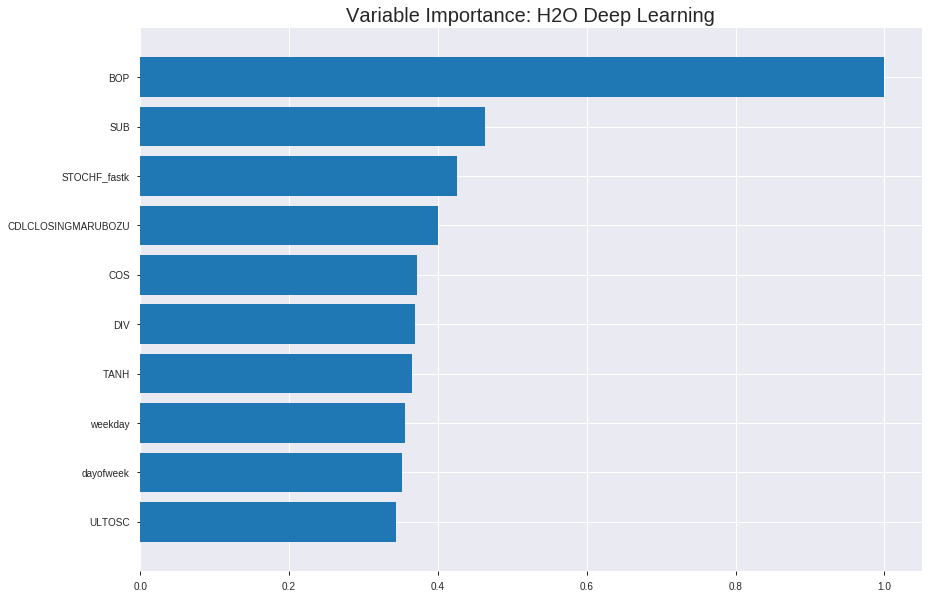

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_011737_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22504266238889464
RMSE: 0.4743866170002002
LogLoss: 0.6724883033020794
Mean Per-Class Error: 0.34317079012037155
AUC: 0.7178095974426256
pr_auc: 0.7265336426779944
Gini: 0.43561919488525125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20041306911934675: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      322  526   0.6203   (526.0/848.0)
1      105  801   0.1159   (105.0/906.0)
Total  427  1327  0.3597   (631.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.200413     0.717421  308
max f2                       0.0081665    0.845361  393
max f0point5                 0.546683     0.670672  170
max accuracy                 0.546683     0.655074  170
max precision                0.957209     1         0
max recall                   0.000685105  1         399
max specificity              0.957209     1         0
max absolute_mcc             0.546683     0.314935  170
max min_per_class_accuracy   0.509741     0.645695  189
max mean_per_class_accuracy  0.546683     0.656829  170

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 45.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.91141            1.82843   1.82843            0.944444         0.932799   0.944444                    0.932799            0.0187638       0.0187638                  82.8428    82.8428
    2        0.0205245                   0.875797           1.72087   1.77465            0.888889         0.894882   0.916667                    0.913841            0.01766         0.0364238                  72.0873    77.465
    3        0.0302166                   0.855417           1.93598   1.8264             1                0.865247   0.943396                    0.898254            0.0187638       0.0551876                  93.5982    82.6398
    4        0.0404789                   0.840259           1.50576   1.74511            0.777778         0.847095   0.901408                    0.885284            0.0154525       0.0706402                  50.5764    74.5111
    5        0.050171                    0.827106           1.70822   1.73798            0.882353         0.832972   0.897727                    0.875178            0.0165563       0.0871965                  70.822     73.7984
    6        0.100342                    0.781914           1.51799   1.62799            0.784091         0.804032   0.840909                    0.839605            0.0761589       0.163355                   51.7986    62.7985
    7        0.149943                    0.740694           1.53543   1.59737            0.793103         0.75955    0.825095                    0.813123            0.0761589       0.239514                   53.5434    59.7369
    8        0.200114                    0.707606           1.40799   1.54989            0.727273         0.722769   0.80057                     0.79047             0.0706402       0.310155                   40.7987    54.9889
    9        0.299886                    0.646731           1.20584   1.43542            0.622857         0.676349   0.741445                    0.752502            0.120309        0.430464                   20.584     43.5424
    10       0.400228                    0.583958           1.15499   1.36512            0.596591         0.616934   0.705128                    0.718513            0.115894        0.546358                   15.4989    36.5116
    11       0.5                         0.509238           0.984585  1.28918            0.508571         0.54657    0.665906                    0.684203            0.098234        0.644592                   -1.54147   28.9183
    12       0.599772                    0.40399            0.995648  1.24035            0.514286         0.454437   0.640684                    0.645982            0.0993377       0.743929                   -0.435194  24.0354
    13       0.700114                    0.267911           0.879992  1.18871            0.454545         0.343437   0.614007                    0.60262             0.0883002       0.83223                    -12.0008   18.8706
    14       0.799886                    0.144994           0.752267  1.13427            0.388571         0.206655   0.585887                    0.55323             0.0750552       0.907285                   -24.7733   13.4268
    15       0.899658                    0.0475013          0.542075  1.06859            0.28             0.0923981  0.551965                    0.502124            0.0540839       0.961369                   -45.7925   6.85935
    16       1                           0.000126515        0.384996  1                  0.198864         0.0214048  0.516534   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20615030474724985
RMSE: 0.45403777898678194
LogLoss: 0.6028767849653183
Mean Per-Class Error: 0.3020873351261365
AUC: 0.7388910231783838
pr_auc: 0.7615596335967725
Gini: 0.4777820463567677
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32822748110888517: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   157  0.6886   (157.0/228.0)
1      13   261  0.0474   (13.0/274.0)
Total  84   418  0.3386   (170.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328227     0.754335  321
max f2                       0.325072     0.863546  323
max f0point5                 0.546105     0.723776  218
max accuracy                 0.546105     0.703187  218
max precision                0.949211     1         0
max recall                   0.0502977    1         393
max specificity              0.949211     1         0
max absolute_mcc             0.546105     0.398756  218
max min_per_class_accuracy   0.578683     0.666667  197
max mean_per_class_accuracy  0.546105     0.697913  218

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 54.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.88679            1.83212   1.83212            1                0.916324  1                           0.916324            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.863383           1.83212   1.83212            1                0.87088   1                           0.895668            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.851753           1.46569   1.71761            0.8              0.85657   0.9375                      0.88345             0.0145985       0.0547445                  46.5693   71.7609
    4        0.0418327                   0.838799           1.46569   1.65763            0.8              0.846098  0.904762                    0.874556            0.0145985       0.0693431                  46.5693   65.7629
    5        0.0517928                   0.814393           1.46569   1.62072            0.8              0.822614  0.884615                    0.864567            0.0145985       0.0839416                  46.5693   62.0719
    6        0.101594                    0.770929           1.53898   1.58065            0.84             0.790659  0.862745                    0.828338            0.0766423       0.160584                   53.8978   58.065
    7        0.151394                    0.740776           1.53898   1.56694            0.84             0.754956  0.855263                    0.804199            0.0766423       0.237226                   53.8978   56.6942
    8        0.201195                    0.71148            1.46569   1.54188            0.8              0.726534  0.841584                    0.784975            0.0729927       0.310219                   46.5693   54.188
    9        0.300797                    0.66829            1.24584   1.44385            0.68             0.688004  0.788079                    0.752866            0.124088        0.434307                   24.5839   44.3854
    10       0.400398                    0.620577           1.09927   1.35814            0.6              0.640046  0.741294                    0.724801            0.109489        0.543796                   9.92701   35.8136
    11       0.5                         0.582929           1.17255   1.32117            0.64             0.602502  0.721116                    0.700439            0.116788        0.660584                   17.2555   32.1168
    12       0.599602                    0.534292           0.989343  1.26605            0.54             0.559176  0.69103                     0.676973            0.0985401       0.759124                   -1.06569  26.6047
    13       0.699203                    0.472659           0.732847  1.19009            0.4              0.500629  0.649573                    0.651853            0.0729927       0.832117                   -26.7153  19.0093
    14       0.798805                    0.371598           0.842774  1.14679            0.46             0.433205  0.625935                    0.62459             0.0839416       0.916058                   -15.7226  14.6786
    15       0.898406                    0.22572            0.586277  1.08465            0.32             0.30706   0.592018                    0.589387            0.0583942       0.974453                   -41.3723  8.46456
    16       1                           0.00757185         0.251467  1                  0.137255         0.120885  0.545817                    0.54179            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:19:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:19:29  1 min 51.549 sec  448 obs/sec       0.533637  1             936        0.650005         7.84286             -0.691876      0.553797        0.488965           1.39821          0.483466                         0.684945           10.4862               -0.892491        0.519025          0.596936             1.52676            0.454183
    2019-07-25 01:19:44  2 min  6.204 sec  436 obs/sec       3.85918   7             6769       0.547484         1.01149             -0.200269      0.650021        0.674951           1.72087          0.468643                         0.512502           0.760677              -0.0595303       0.657847          0.675399             1.83212            0.432271
    2019-07-25 01:19:58  2 min 20.117 sec  444 obs/sec       7.15165   13            12544      0.536676         1.00957             -0.153346      0.658403        0.675832           1.72087          0.41049                          0.500218           0.727093              -0.00934546      0.671581          0.685636             1.83212            0.360558
    2019-07-25 01:20:11  2 min 33.277 sec  455 obs/sec       10.4151   19            18268      0.495382         0.718413            0.0173136      0.679483        0.669735           1.72087          0.392246                         0.488887           0.67869               0.0358638        0.671933          0.711087             1.83212            0.38247
    2019-07-25 01:20:25  2 min 47.526 sec  468 obs/sec       14.203    26            24912      0.474387         0.672488            0.098844       0.71781         0.726534           1.82843          0.359749                         0.454038           0.602877              0.168416         0.738891          0.76156              1.83212            0.338645
    2019-07-25 01:20:38  2 min 59.696 sec  478 obs/sec       17.4709   32            30644      0.472945         0.645149            0.104312       0.702239        0.686988           1.72087          0.383124                         0.481264           0.659619              0.0656959        0.662137          0.680218             1.52676            0.356574
    2019-07-25 01:20:51  3 min 13.253 sec  489 obs/sec       21.3136   39            37384      0.500527         0.756953            -0.00320597    0.711106        0.726895           1.82843          0.387685                         0.481287           0.662268              0.0656048        0.693535          0.725921             1.83212            0.354582
    2019-07-25 01:21:05  3 min 26.763 sec  497 obs/sec       25.1705   46            44149      0.459001         0.611345            0.156352       0.742986        0.738899           1.82843          0.338084                         0.464398           0.620551              0.130033         0.708597          0.730507             1.83212            0.334661
    2019-07-25 01:21:17 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0062109913981085365
SUB                       0.4637480676174164     0.4637480676174164   0.0028803352588612293
STOCHF_fastk              0.4251581132411957     0.4251581132411957   0.0026406533841771217
CDLCLOSINGMARUBOZU        0.40066081285476685    0.40066081285476685  0.002488500862200131
COS                       0.3720271587371826     0.3720271587371826   0.0023106574827794005
---                       ---                    ---                  ---
BBANDS_middleband_24_3_5  0.12186215072870255    0.12186215072870255  0.0007568847699309775
BBANDS_middleband_12_7_3  0.12095358222723007    0.12095358222723007  0.0007512416587837395
MAVP_8_8                  0.11910106241703033    0.11910106241703033  0.0007397356741777634
CDLCOUNTERATTACK          0.11644618213176727    0.11644618213176727  0.0007232462355629865
CDLTASUKIGAP              0.11532136052846909    0.11532136052846909  0.0007162599782604949


See the whole table with table.as_data_frame()


('accuracy', 0.7250996015936255)

('F1', 0.7584097859327217)

('auc', 0.7393997445721584)

('logloss', 0.9735946586854568)

('mean_per_class_error', 0.2780012771392082)

('rmse', 0.5595373517168843)

('mse', 0.31308204796634437)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


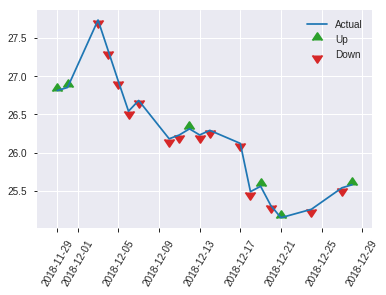


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31308204796634437
RMSE: 0.5595373517168843
LogLoss: 0.9735946586854568
Mean Per-Class Error: 0.2780012771392082
AUC: 0.7393997445721584
pr_auc: 0.7190344317908446
Gini: 0.4787994891443168
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03959471818495237: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   68   0.5862   (68.0/116.0)
1      11   124  0.0815   (11.0/135.0)
Total  59   192  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0395947    0.75841   191
max f2                       0.0214228    0.869854  212
max f0point5                 0.122802     0.741007  139
max accuracy                 0.122802     0.7251    139
max precision                0.79354      0.909091  10
max recall                   0.000796826  1         248
max specificity              0.91384      0.991379  0
max absolute_mcc             0.122802     0.445708  139
max min_per_class_accuracy   0.14884      0.706897  129
max mean_per_class_accuracy  0.122802     0.721999  139

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 24.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879747           1.23951   1.23951            0.666667         0.899432    0.666667                    0.899432            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.824825           1.85926   1.54938            1                0.853884    0.833333                    0.876658            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.80013            1.85926   1.62685            1                0.808751    0.875                       0.859681            0.0148148       0.0518519                  85.9259   62.6852
    4        0.0438247                   0.79354            1.85926   1.69024            1                0.79699     0.909091                    0.842584            0.0222222       0.0740741                  85.9259   69.0236
    5        0.0517928                   0.778878           0.92963   1.57322            0.5              0.784865    0.846154                    0.833704            0.00740741      0.0814815                  -7.03704  57.3219
    6        0.103586                    0.673593           1.28718   1.4302             0.692308         0.719581    0.769231                    0.776643            0.0666667       0.148148                   28.7179   43.0199
    7        0.151394                    0.56967            1.23951   1.36998            0.666667         0.618317    0.736842                    0.726645            0.0592593       0.207407                   23.9506   36.9981
    8        0.203187                    0.464365           1.4302    1.38533            0.769231         0.517454    0.745098                    0.673322            0.0740741       0.281481                   43.0199   38.533
    9        0.302789                    0.31324            1.41304   1.39444            0.76             0.390861    0.75                        0.580407            0.140741        0.422222                   41.3037   39.4444
    10       0.40239                     0.203218           1.2643    1.36223            0.68             0.259595    0.732673                    0.500998            0.125926        0.548148                   26.4296   36.223
    11       0.501992                    0.155319           1.41304   1.37231            0.76             0.173205    0.738095                    0.43596             0.140741        0.688889                   41.3037   37.231
    12       0.601594                    0.100691           0.966815  1.30518            0.52             0.126055    0.701987                    0.384651            0.0962963       0.785185                   -3.31852  30.5175
    13       0.701195                    0.0546852          0.520593  1.19373            0.28             0.0729369   0.642045                    0.340373            0.0518519       0.837037                   -47.9407  19.3729
    14       0.800797                    0.0295303          0.892444  1.15626            0.48             0.0430731   0.621891                    0.303396            0.0888889       0.925926                   -10.7556  15.6256
    15       0.900398                    0.0106628          0.446222  1.07771            0.24             0.0194467   0.579646                    0.271985            0.0444444       0.97037                    -55.3778  7.77122
    16       1                           0.000254617        0.297481  1                  0.16             0.00440902  0.537849    

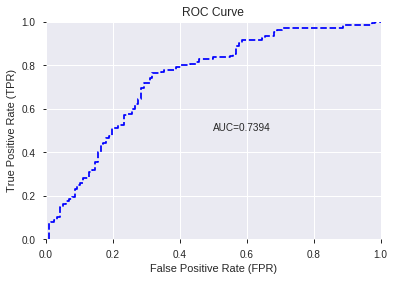

This function is available for GLM models only


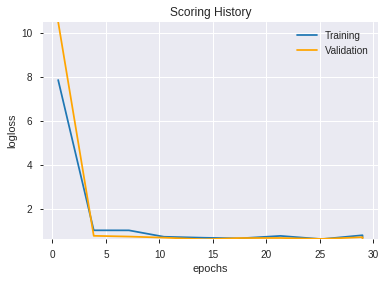

--2019-07-25 01:49:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_011737_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_011737_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_014954_model_7  0.712197  0.714423              0.386111  0.493979  0.244015
1  DeepLearning_grid_1_AutoML_20190725_014954_model_6  0.698914  0.635720              0.386111  0.469008  0.219968
2  DeepLearning_grid_1_AutoML_20190725_014954_model_9  0.695211  0.634156              0.384898  0.470067  0.220963
3  DeepLearning_grid_1_AutoML_20190725_014954_model_5  0.687739  0.626232              0.362133  0.467510  0.218566
4  DeepLearning_grid_1_AutoML_20190725_014954_model_8  0.685313  0.625127              0.386718  0.467044  0.218130
5  DeepLearning_grid_1_AutoML_20190725_014954_model_3  0.678225  1.079846              0.388602  0.510027  0.260127
6  DeepLearning_grid_1_AutoML_20190725_014954_model_1  0.677778  0.902823              0.368327  0.518029  0.268354
7  DeepLearning_grid_1_AutoML_20190725_014954_model_2  0.675032  0.915187              0.424298  0.499446  0.249446
8               DeepLearning_1_AutoML_20190725_014954  0.642465  0.796085              0.387388  0.505894  0.255929
9  DeepLearning_grid_1_AutoML_20190725_014954_model_4  0.583269  1.148686              0.474138  0.567533  0.322093

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.024512
1             CDLHAMMER             0.861357           0.861357    0.021114
2       CDLLADDERBOTTOM             0.860615           0.860615    0.021096
3        CDLSPINNINGTOP             0.848308           0.848308    0.020794
4     CDLDARKCLOUDCOVER             0.844245           0.844245    0.020694
5          STOCHF_fastk             0.841758           0.841758    0.020633
6                   COS             0.839776           0.839776    0.020585
7                   day             0.838752           0.838752    0.020560
8                 ADOSC             0.833800           0.833800    0.020438
9                  TANH             0.833541           0.833541    0.020432
10            CDLONNECK             0.830973           0.830973    0.020369
11        days_in_month             0.830816           0.830816    0.020365
12                  SIN             0.830261           0.830261    0.020351
13        CDLHANGINGMAN             0.830067           0.830067    0.020347
14       STOCHRSI_fastk             0.827595           0.827595    0.020286
15             CORREL_8             0.825310           0.825310    0.020230
16         weekday_name             0.824554           0.824554    0.020212
17       CDLRICKSHAWMAN             0.823454           0.823454    0.020185
18              weekday             0.822219           0.822219    0.020154
19       STOCHRSI_fastd             0.822089           0.822089    0.020151
20            dayofweek             0.819011           0.819011    0.020076
21            aroonup_8             0.817648           0.817648    0.020042
22        CDLHIKKAKEMOD             0.817160           0.817160    0.020030
23  CDLGAPSIDESIDEWHITE             0.814923           0.814923    0.019976
24              quarter             0.814514           0.814514    0.019965
25                  DIV             0.814291           0.814291    0.019960
26               TRANGE             0.812940           0.812940    0.019927
27          CDLLONGLINE             0.812365           0.812365    0.019913
28   CDLCLOSINGMARUBOZU             0.810552           0.810552    0.019868
29       CDLEVENINGSTAR             0.809589           0.809589    0.019845
30    CDLSTALLEDPATTERN             0.808738           0.808738    0.019824
31                  SUB             0.807263           0.807263    0.019788
32              BETA_30             0.806335           0.806335    0.019765
33               ULTOSC             0.805516           0.805516    0.019745
34              WILLR_8             0.805497           0.805497    0.019744
35             WILLR_14             0.804187           0.804187    0.019712
36           aroonup_20             0.801526           0.801526    0.019647
37             WILLR_12             0.800393           0.800393    0.019619
38          STOCH_slowd             0.797670           0.797670    0.019553
39              BETA_24             0.794332           0.794332    0.019471
40           aroonup_14             0.793016           0.793016    0.019439
41    CDL3WHITESOLDIERS             0.790805           0.790805    0.019384
42            CDL2CROWS             0.789312           0.789312    0.019348
43              CDLDOJI             0.789035           0.789035    0.019341
44               SAREXT             0.778039           0.778039    0.019071
45         HT_TRENDMODE             0.771019           0.771019    0.018899
46     CDLSTICKSANDWICH             0.766911           0.766911    0.018799
47           weekofyear             0.764655           0.764655    0.018743
48                  EXP             0.761813           0.761813    0.018674
49   CDLEVENINGDOJISTAR             0.747572           0.747572    0.018325

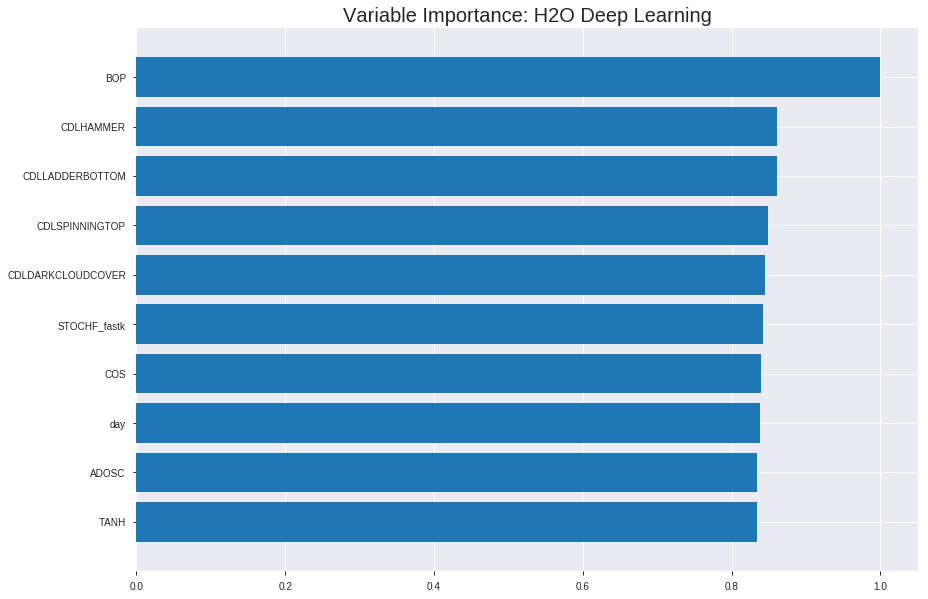

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_014954_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1998665138610899
RMSE: 0.4470643285491361
LogLoss: 0.5938741196047902
Mean Per-Class Error: 0.2852992627764588
AUC: 0.7853617393477446
pr_auc: 0.7831517685803054
Gini: 0.5707234786954891
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21050315535272174: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      366  482   0.5684   (482.0/848.0)
1      75   831   0.0828   (75.0/906.0)
Total  441  1313  0.3176   (557.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.210503     0.748986  309
max f2                       0.127488     0.857426  341
max f0point5                 0.464333     0.731191  196
max accuracy                 0.42017      0.715507  218
max precision                0.995402     1         0
max recall                   0.0014472    1         398
max specificity              0.995402     1         0
max absolute_mcc             0.42017      0.42998   218
max min_per_class_accuracy   0.438679     0.710817  209
max mean_per_class_accuracy  0.433718     0.714701  212

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 41.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.968201           1.82843   1.82843            0.944444         0.981878   0.944444                    0.981878            0.0187638       0.0187638                  82.8428   82.8428
    2        0.0205245                   0.944729           1.82843   1.82843            0.944444         0.95475    0.944444                    0.968314            0.0187638       0.0375276                  82.8428   82.8428
    3        0.0302166                   0.915377           1.8221    1.8264             0.941176         0.92959    0.943396                    0.955893            0.01766         0.0551876                  82.2101   82.6398
    4        0.0404789                   0.882285           1.93598   1.85418            1                0.899309   0.957746                    0.941548            0.0198675       0.0750552                  93.5982   85.418
    5        0.050171                    0.866324           1.8221    1.84798            0.941176         0.874265   0.954545                    0.92855             0.01766         0.0927152                  82.2101   84.7983
    6        0.100342                    0.750551           1.58399   1.71598            0.818182         0.805601   0.886364                    0.867075            0.0794702       0.172185                   58.3986   71.5984
    7        0.149943                    0.67969            1.6467    1.69306            0.850575         0.712554   0.874525                    0.81596             0.0816777       0.253863                   64.6698   69.3064
    8        0.200114                    0.626774           1.36399   1.61056            0.704545         0.651258   0.831909                    0.774667            0.0684327       0.322296                   36.3988   61.0561
    9        0.299886                    0.536342           1.4271    1.54952            0.737143         0.575983   0.80038                     0.708565            0.142384        0.46468                    42.7096   54.9522
    10       0.400228                    0.480767           1.27599   1.48094            0.659091         0.508095   0.764957                    0.658305            0.128035        0.592715                   27.5988   48.0944
    11       0.5                         0.440525           1.11734   1.40839            0.577143         0.460684   0.72748                     0.618871            0.111479        0.704194                   11.7338   40.8389
    12       0.599772                    0.378781           0.907146  1.32501            0.468571         0.412188   0.684411                    0.584489            0.0905077       0.794702                   -9.2854   32.5007
    13       0.700114                    0.273669           0.868992  1.25965            0.448864         0.333686   0.650651                    0.548543            0.0871965       0.881898                   -13.1008  25.965
    14       0.799886                    0.144707           0.630577  1.18118            0.325714         0.209529   0.610121                    0.506257            0.0629139       0.944812                   -36.9423  18.1184
    15       0.899658                    0.0426154          0.387196  1.09313            0.2              0.0862132  0.564639                    0.459674            0.0386313       0.983444                   -61.2804  9.31307
    16       1                           0.000120069        0.164998  1                  0.0852273        0.0156139  0.516534                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23063356904808396
RMSE: 0.4802432394610922
LogLoss: 0.6868309342524981
Mean Per-Class Error: 0.3558074017159687
AUC: 0.7048837879369958
pr_auc: 0.7474333993496655
Gini: 0.4097675758739916
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19946479931583275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   149  0.6535   (149.0/228.0)
1      25   249  0.0912   (25.0/274.0)
Total  104  398  0.3466   (174.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.199465     0.741071  319
max f2                       0.00896918   0.863924  388
max f0point5                 0.39382      0.677291  240
max accuracy                 0.350327     0.655378  261
max precision                0.98606      1         0
max recall                   0.00116624   1         398
max specificity              0.98606      1         0
max absolute_mcc             0.199465     0.313582  319
max min_per_class_accuracy   0.460895     0.624088  201
max mean_per_class_accuracy  0.39382      0.644193  240

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 42.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.927564           1.83212   1.83212            1                0.957868   1                           0.957868            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.891751           1.83212   1.83212            1                0.910993   1                           0.936561            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.852948           1.83212   1.83212            1                0.860943   1                           0.912931            0.0182482       0.0583942                  83.2117   83.2117
    4        0.0418327                   0.828992           1.83212   1.83212            1                0.841293   1                           0.895874            0.0182482       0.0766423                  83.2117   83.2117
    5        0.0517928                   0.793846           1.83212   1.83212            1                0.801899   1                           0.877802            0.0182482       0.0948905                  83.2117   83.2117
    6        0.101594                    0.715257           1.53898   1.68842            0.84             0.75849    0.921569                    0.819315            0.0766423       0.171533                   53.8978   68.8421
    7        0.151394                    0.656408           1.46569   1.61516            0.8              0.68441    0.881579                    0.774939            0.0729927       0.244526                   46.5693   61.5156
    8        0.201195                    0.614953           1.09927   1.48746            0.6              0.634574   0.811881                    0.740195            0.0547445       0.29927                    9.92701   48.7461
    9        0.300797                    0.541146           1.13591   1.37105            0.62             0.572408   0.748344                    0.684637            0.113139        0.412409                   13.5912   37.1054
    10       0.400398                    0.498025           0.989343  1.2761             0.54             0.516971   0.696517                    0.642929            0.0985401       0.510949                   -1.06569  27.6101
    11       0.5                         0.463772           1.09927   1.24088            0.6              0.480994   0.677291                    0.610671            0.109489        0.620438                   9.92701   24.0876
    12       0.599602                    0.397605           1.06263   1.21127            0.58             0.428508   0.66113                     0.580411            0.105839        0.726277                   6.26277   21.1267
    13       0.699203                    0.323553           0.916058  1.16921            0.5              0.362294   0.638177                    0.549341            0.0912409       0.817518                   -8.39416  16.9214
    14       0.798805                    0.181707           0.916058  1.13765            0.5              0.265778   0.620948                    0.513984            0.0912409       0.908759                   -8.39416  13.7649
    15       0.898406                    0.044275           0.549635  1.07246            0.3              0.115676   0.585366                    0.469825            0.0547445       0.963504                   -45.0365  7.24586
    16       1                           0.000141467        0.359239  1                  0.196078         0.0158374  0.545817                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:54:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:54:41  6.432 sec         186 obs/sec       0.559293  1             981        0.619768         1.28164             -0.53813       0.687659        0.680163           1.72087          0.387115                         0.640909           1.36985               -0.656973        0.636101          0.650552             1.22141            0.406375
    2019-07-25 01:54:53  18.915 sec        424 obs/sec       4.01995   7             7051       0.447064         0.593874            0.199659       0.785362        0.783152           1.82843          0.31756                          0.480243           0.686831              0.0696539        0.704884          0.747433             1.83212            0.346614
    2019-07-25 01:55:05  30.714 sec        518 obs/sec       8.05986   14            14137      0.467196         0.646988            0.125955       0.831648        0.832793           1.93598          0.249715                         0.53434            0.900417              -0.151749        0.687084          0.730458             1.83212            0.376494
    2019-07-25 01:55:17  42.326 sec        558 obs/sec       12.0268   21            21095      0.457019         0.648481            0.163619       0.876733        0.871867           1.93598          0.206385                         0.573243           1.14872               -0.325559        0.671445          0.684405             1.83212            0.348606
    2019-07-25 01:55:28  53.779 sec        586 obs/sec       16.0872   28            28217      0.355561         0.391631            0.493751       0.911661        0.88968            1.93598          0.17959                          0.531354           0.942531              -0.13891         0.659944          0.687626             1.83212            0.374502
    2019-07-25 01:55:40  1 min  5.427 sec  602 obs/sec       20.1203   35            35291      0.298752         0.291193            0.642598       0.953346        0.924503           1.93598          0.123147                         0.527268           0.950494              -0.121464        0.672093          0.696152             1.83212            0.37251
    2019-07-25 01:55:52  1 min 18.072 sec  617 obs/sec       24.6613   43            43256      0.275312         0.244478            0.696481       0.967075        0.897393           1.93598          0.0929304                        0.544781           1.09887               -0.197199        0.671125          0.684384             1.83212            0.39243
    2019-07-25 01:55:54  1 min 19.227 sec  616 obs/sec       24.6613   43            43256      0.447064         0.593874            0.199659       0.785362        0.783152           1.82843          0.31756                          0.480243           0.686831              0.0696539        0.704884          0.747433             1.83212            0.346614

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.02451213756331962
CDLHAMMER           0.8613573312759399     0.8613573312759399   0.02111370939540971
CDLLADDERBOTTOM     0.8606152534484863     0.8606152534484863   0.021095519481620476
CDLSPINNINGTOP      0.8483079075813293     0.8483079075813293   0.02079384012668537
CDLDARKCLOUDCOVER   0.8442448377609253     0.8442448377609253   0.020694245600318253
---                 ---                    ---                  ---
HT_TRENDMODE        0.7710187435150146     0.7710187435150146   0.018899317504937885
CDLSTICKSANDWICH    0.766910970211029      0.766910970211029    0.01879862720063166
weekofyear          0.7646552920341492     0.7646552920341492   0.018743335706861403
EXP                 0.7618128061294556     0.7618128061294556   0.018673660301343754
CDLEVENINGDOJISTAR  0.747572124004364      0.747572124004364    0.018324590742098003


See the whole table with table.as_data_frame()


('accuracy', 0.6812749003984063)

('F1', 0.7457627118644068)

('auc', 0.7121966794380588)

('logloss', 0.7144234493601305)

('mean_per_class_error', 0.32116858237547885)

('rmse', 0.4939789494501512)

('mse', 0.24401520249987504)

deeplearning prediction progress: |███████████████████████████████████████| 100%


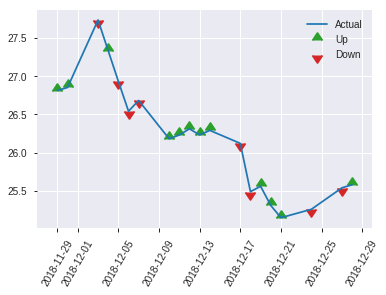


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24401520249987504
RMSE: 0.4939789494501512
LogLoss: 0.7144234493601305
Mean Per-Class Error: 0.32116858237547885
AUC: 0.7121966794380588
pr_auc: 0.6937439472718308
Gini: 0.4243933588761175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06056069543519544: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   87   0.75     (87.0/116.0)
1      3    132  0.0222   (3.0/135.0)
Total  32   219  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0605607    0.745763  218
max f2                       0.0316636    0.87013   229
max f0point5                 0.376359     0.702782  136
max accuracy                 0.376359     0.681275  136
max precision                0.919499     1         0
max recall                   0.00118411   1         247
max specificity              0.919499     1         0
max absolute_mcc             0.376359     0.358143  136
max min_per_class_accuracy   0.397017     0.655172  128
max mean_per_class_accuracy  0.376359     0.678831  136

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 38.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.873912           1.23951   1.23951            0.666667         0.895564   0.666667                    0.895564            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.85281            1.23951   1.23951            0.666667         0.860244   0.666667                    0.877904            0.0148148       0.0296296                  23.9506   23.9506
    3        0.0318725                   0.828787           1.85926   1.39444            1                0.831544   0.75                        0.866314            0.0148148       0.0444444                  85.9259   39.4444
    4        0.0438247                   0.78743            1.85926   1.52121            1                0.800955   0.818182                    0.848489            0.0222222       0.0666667                  85.9259   52.1212
    5        0.0517928                   0.76999            0         1.28718            0                0.778708   0.692308                    0.837753            0               0.0666667                  -100      28.7179
    6        0.103586                    0.688131           1.57322   1.4302             0.846154         0.723723   0.769231                    0.780738            0.0814815       0.148148                   57.3219   43.0199
    7        0.151394                    0.637475           1.23951   1.36998            0.666667         0.667655   0.736842                    0.745028            0.0592593       0.207407                   23.9506   36.9981
    8        0.203187                    0.590058           1.4302    1.38533            0.769231         0.608531   0.745098                    0.710235            0.0740741       0.281481                   43.0199   38.533
    9        0.302789                    0.519409           1.33867   1.36998            0.72             0.551955   0.736842                    0.658169            0.133333        0.414815                   33.8667   36.9981
    10       0.40239                     0.466709           1.04119   1.2886             0.56             0.488676   0.693069                    0.616215            0.103704        0.518519                   4.11852   28.8596
    11       0.501992                    0.406057           1.18993   1.26902            0.64             0.436781   0.68254                     0.580613            0.118519        0.637037                   18.9926   26.9018
    12       0.601594                    0.333267           1.18993   1.25592            0.64             0.368266   0.675497                    0.545457            0.118519        0.755556                   18.9926   25.5923
    13       0.701195                    0.208233           0.892444  1.20429            0.48             0.268461   0.647727                    0.506111            0.0888889       0.844444                   -10.7556  20.4293
    14       0.800797                    0.11325            0.669333  1.13776            0.36             0.163832   0.61194                     0.463539            0.0666667       0.911111                   -33.0667  13.7756
    15       0.900398                    0.0395976          0.743704  1.09417            0.4              0.0753766  0.588496                    0.4206              0.0740741       0.985185                   -25.6296  9.41658
    16       1                           0.000126299        0.148741  1                  0.08             0.0145203  0.537849                    

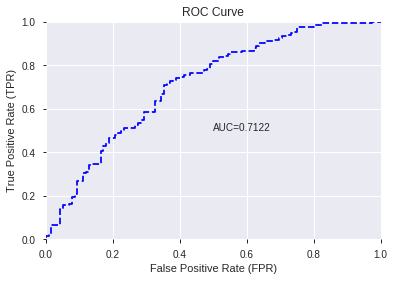

This function is available for GLM models only


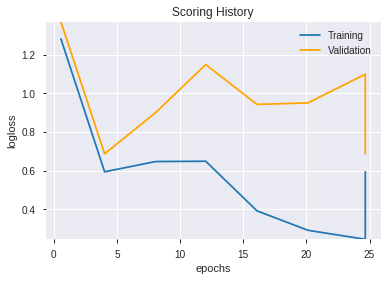

--2019-07-25 01:58:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_014954_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_014954_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLHAMMER',
 'CDLLADDERBOTTOM',
 'CDLSPINNINGTOP',
 'CDLDARKCLOUDCOVER',
 'STOCHF_fastk',
 'COS',
 'day',
 'ADOSC',
 'TANH',
 'CDLONNECK',
 'days_in_month',
 'SIN',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'CORREL_8',
 'weekday_name',
 'CDLRICKSHAWMAN',
 'weekday',
 'STOCHRSI_fastd',
 'dayofweek',
 'aroonup_8',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'quarter',
 'DIV',
 'TRANGE',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'SUB',
 'BETA_30',
 'ULTOSC',
 'WILLR_8',
 'WILLR_14',
 'aroonup_20',
 'WILLR_12',
 'STOCH_slowd',
 'BETA_24',
 'aroonup_14',
 'CDL3WHITESOLDIERS',
 'CDL2CROWS',
 'CDLDOJI',
 'SAREXT',
 'HT_TRENDMODE',
 'CDLSTICKSANDWICH',
 'weekofyear',
 'EXP',
 'CDLEVENINGDOJISTAR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190725_015826_model_1  0.700383  0.637336              0.389815  0.470808  0.22166

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.485164           1.000000    0.121552
1          STOCHF_fastk             0.247674           0.510495    0.062052
2                ULTOSC             0.228107           0.470164    0.057149
3             CDLHAMMER             0.194960           0.401843    0.048845
4           STOCH_slowd             0.174443           0.359554    0.043704
5             aroonup_8             0.153983           0.317383    0.038578
6         CDLHANGINGMAN             0.141519           0.291693    0.035456
7    CDLCLOSINGMARUBOZU             0.136732           0.281827    0.034257
8                   SUB             0.135140           0.278544    0.033858
9               CDLDOJI             0.126156           0.260028    0.031607
10             WILLR_14             0.116002           0.239098    0.029063
11              BETA_24             0.110852           0.228483    0.027773
12           aroonup_20             0.110435           0.227625    0.027668
13                  EXP             0.096382           0.198659    0.024147
14   CDLEVENINGDOJISTAR             0.094905           0.195615    0.023777
15               SAREXT             0.090201           0.185919    0.022599
16              WILLR_8             0.075206           0.155011    0.018842
17    CDLDARKCLOUDCOVER             0.074907           0.154396    0.018767
18       STOCHRSI_fastd             0.074402           0.153355    0.018641
19                  SIN             0.071950           0.148301    0.018026
20             WILLR_12             0.065533           0.135074    0.016418
21                  day             0.063116           0.130092    0.015813
22                 TANH             0.056613           0.116689    0.014184
23           aroonup_14             0.055505           0.114404    0.013906
24       STOCHRSI_fastk             0.053244           0.109744    0.013340
25             CORREL_8             0.047078           0.097036    0.011795
26       CDLEVENINGSTAR             0.045270           0.093309    0.011342
27     CDLSTICKSANDWICH             0.043073           0.088781    0.010791
28    CDL3WHITESOLDIERS             0.042045           0.086662    0.010534
29         HT_TRENDMODE             0.041952           0.086469    0.010510
30              BETA_30             0.041518           0.085575    0.010402
31           weekofyear             0.040676           0.083840    0.010191
32        CDLHIKKAKEMOD             0.038990           0.080365    0.009769
33  CDLGAPSIDESIDEWHITE             0.036688           0.075619    0.009192
34            dayofweek             0.036225           0.074666    0.009076
35              weekday             0.036007           0.074217    0.009021
36               TRANGE             0.035394           0.072953    0.008868
37                  COS             0.034160           0.070408    0.008558
38      CDLLADDERBOTTOM             0.034115           0.070317    0.008547
39            CDLONNECK             0.033951           0.069978    0.008506
40    CDLSTALLEDPATTERN             0.033278           0.068591    0.008337
41       CDLRICKSHAWMAN             0.031670           0.065276    0.007934
42          CDLLONGLINE             0.025538           0.052638    0.006398
43        days_in_month             0.023373           0.048176    0.005856
44         weekday_name             0.016338           0.033675    0.004093
45              quarter             0.013736           0.028312    0.003441
46            CDL2CROWS             0.009627           0.019842    0.002412
47                  DIV             0.006946           0.014316    0.001740
48                ADOSC             0.005774           0.011901    0.001447
49       CDLSPINNINGTOP             0.004869           0.010036    0.001220

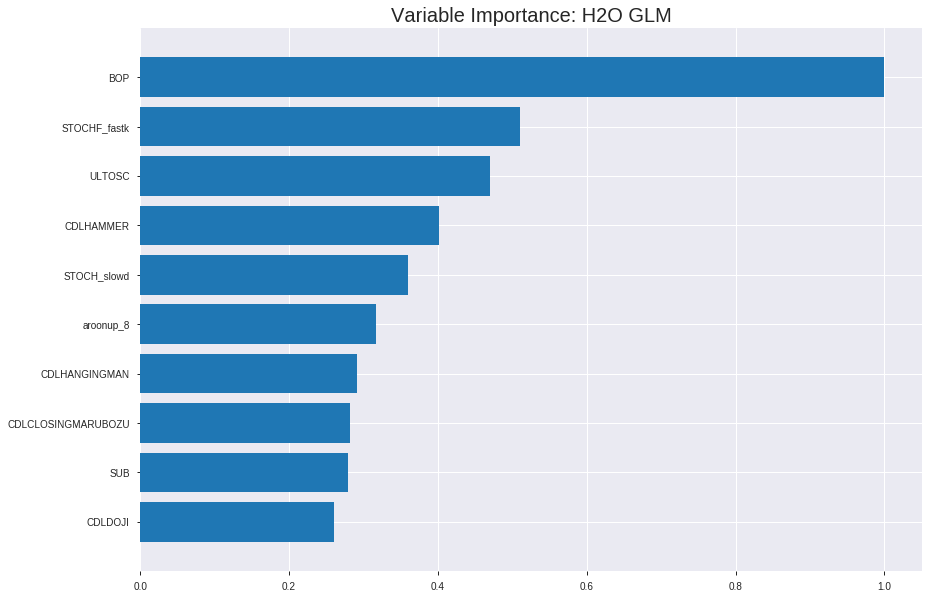

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_015826_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20131428728956435
RMSE: 0.4486806072135995
LogLoss: 0.5875366727597513
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.642057792962
Residual deviance: 2061.0786480412075
AIC: 2163.0786480412075
AUC: 0.7515293744012661
pr_auc: 0.7455610345522351
Gini: 0.5030587488025322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37899814830579365: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  459   0.5413   (459.0/848.0)
1      103  803   0.1137   (103.0/906.0)
Total  492  1262  0.3204   (562.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378998     0.740775  266
max f2                       0.257603     0.852018  322
max f0point5                 0.520767     0.700509  197
max accuracy                 0.520767     0.693843  197
max precision                0.967024     1         0
max recall                   0.113027     1         384
max specificity              0.967024     1         0
max absolute_mcc             0.435802     0.389809  237
max min_per_class_accuracy   0.550538     0.681604  182
max mean_per_class_accuracy  0.520767     0.69262   197

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.885034           1.93598   1.93598            1                0.910037  1                           0.910037            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.864968           1.50576   1.72087            0.777778         0.874768  0.888889                    0.892402            0.0154525       0.0353201                  50.5764   72.0873
    3        0.0302166                   0.848065           1.8221    1.75334            0.941176         0.854594  0.90566                     0.880275            0.01766         0.0529801                  82.2101   75.3342
    4        0.0404789                   0.831517           1.82843   1.77238            0.944444         0.840042  0.915493                    0.870075            0.0187638       0.0717439                  82.8428   77.2378
    5        0.050171                    0.816139           1.8221    1.78198            0.941176         0.824703  0.920455                    0.86131             0.01766         0.089404                   82.2101   78.1984
    6        0.100342                    0.765191           1.51799   1.64998            0.784091         0.78606   0.852273                    0.823685            0.0761589       0.165563                   51.7986   64.9985
    7        0.149943                    0.732953           1.46868   1.59001            0.758621         0.74733   0.821293                    0.798427            0.0728477       0.238411                   46.8676   59.0008
    8        0.200114                    0.703153           1.31999   1.52231            0.681818         0.71835   0.786325                    0.778351            0.0662252       0.304636                   31.9988   52.2311
    9        0.299886                    0.65187            1.34966   1.46487            0.697143         0.678475  0.756654                    0.745122            0.134658        0.439294                   34.9656   46.4869
    10       0.400228                    0.605928           1.19899   1.39821            0.619318         0.628766  0.722222                    0.71595             0.120309        0.559603                   19.8989   39.8209
    11       0.5                         0.553531           1.17265   1.3532             0.605714         0.581435  0.698974                    0.689108            0.116998        0.6766                     17.2652   35.3201
    12       0.599772                    0.473484           1.0399    1.30108            0.537143         0.514783  0.672053                    0.660109            0.103753        0.780353                   3.98991   30.1083
    13       0.700114                    0.392329           0.879992  1.24073            0.454545         0.432653  0.640879                    0.62751             0.0883002       0.868653                   -12.0008  24.0731
    14       0.799886                    0.312863           0.608452  1.16187            0.314286         0.354459  0.600143                    0.593451            0.0607064       0.92936                    -39.1548  16.1865
    15       0.899658                    0.213438           0.420385  1.07964            0.217143         0.263862  0.557668                    0.5569              0.0419426       0.971302                   -57.9615  7.96353
    16       1                           0.00932691         0.285997  1                  0.147727         0.154613  0.516534                    0.516534         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2090945917846186
RMSE: 0.457268621036496
LogLoss: 0.603523612799953
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 693.4256799911966
Residual deviance: 605.9377072511527
AIC: 707.9377072511527
AUC: 0.7301030861826099
pr_auc: 0.7658401509384737
Gini: 0.46020617236521977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3707853199063219: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   138  0.6053   (138.0/228.0)
1      29   245  0.1058   (29.0/274.0)
Total  119  383  0.3327   (167.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370785     0.745814  294
max f2                       0.205517     0.86483   365
max f0point5                 0.667334     0.705128  111
max accuracy                 0.410552     0.671315  269
max precision                0.902538     1         0
max recall                   0.102353     1         392
max specificity              0.902538     1         0
max absolute_mcc             0.667334     0.363934  111
max min_per_class_accuracy   0.564597     0.631387  194
max mean_per_class_accuracy  0.667334     0.665978  111

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.866156           1.83212   1.83212            1                0.888018  1                           0.888018            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.860224           1.46569   1.66556            0.8              0.861262  0.909091                    0.875856            0.0145985       0.0364964                  46.5693   66.5561
    3        0.0318725                   0.839934           1.46569   1.6031             0.8              0.846078  0.875                       0.866551            0.0145985       0.0510949                  46.5693   60.3102
    4        0.0418327                   0.83469            1.83212   1.65763            1                0.837221  0.904762                    0.859567            0.0182482       0.0693431                  83.2117   65.7629
    5        0.0517928                   0.824736           1.83212   1.69118            1                0.829494  0.923077                    0.853784            0.0182482       0.0875912                  83.2117   69.1185
    6        0.101594                    0.774043           1.61226   1.6525             0.88             0.794884  0.901961                    0.824912            0.080292        0.167883                   61.2263   65.2497
    7        0.151394                    0.732081           1.61226   1.63926            0.88             0.751244  0.894737                    0.800679            0.080292        0.248175                   61.2263   63.9262
    8        0.201195                    0.706987           1.39241   1.57816            0.76             0.716327  0.861386                    0.7798              0.0693431       0.317518                   39.2409   57.816
    9        0.300797                    0.66159            1.28248   1.48025            0.7              0.683445  0.807947                    0.747894            0.127737        0.445255                   28.2482   48.0253
    10       0.400398                    0.611422           0.916058  1.33991            0.5              0.636593  0.731343                    0.720207            0.0912409       0.536496                   -8.39416  33.9906
    11       0.5                         0.571226           0.916058  1.25547            0.5              0.591464  0.685259                    0.694561            0.0912409       0.627737                   -8.39416  25.5474
    12       0.599602                    0.493371           0.916058  1.19909            0.5              0.537581  0.654485                    0.668485            0.0912409       0.718978                   -8.39416  19.9093
    13       0.699203                    0.409345           1.2092    1.20053            0.66             0.450083  0.655271                    0.637374            0.120438        0.839416                   20.9197   20.0532
    14       0.798805                    0.333647           0.659562  1.13308            0.36             0.377236  0.618454                    0.604938            0.0656934       0.905109                   -34.0438  13.308
    15       0.898406                    0.234567           0.62292   1.07652            0.34             0.290397  0.587583                    0.570066            0.0620438       0.967153                   -37.708   7.6521
    16       1                           0.0587503          0.323315  1                  0.176471         0.162834  0.545817                    0.528694            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:58:26  0.000 sec   2            18        50            1.36843           1.36598
    2019-07-25 01:58:26  0.011 sec   4            11        51            1.35989           1.35817
    2019-07-25 01:58:26  0.025 sec   6            7         51            1.34811           1.34741
    2019-07-25 01:58:26  0.038 sec   8            4.4       51            1.33287           1.33351
    2019-07-25 01:58:26  0.056 sec   10           2.7       51            1.31443           1.31673
    2019-07-25 01:58:26  0.071 sec   12           1.7       51            1.29365           1.2979
    2019-07-25 01:58:26  0.080 sec   14           1         51            1.27186           1.27826
    2019-07-25 01:58:26  0.090 sec   16           0.65      51            1.25061           1.25933
    2019-07-25 01:58:26  0.100 sec   18           0.4       51            1.2313            1.24247
    2019-07-25 01:58:26  0.110 sec   20           0.25      51            1.21492           1.22877
    2019-07-25 01:58:26  0.121 sec   22           0.16      51            1.2018            1.21875
    2019-07-25 01:58:26  0.131 sec   24           0.096     51            1.19177           1.2123
    2019-07-25 01:58:26  0.142 sec   26           0.06      51            1.18435           1.20881
    2019-07-25 01:58:26  0.159 sec   28           0.037     51            1.17897           1.20736
    2019-07-25 01:58:26  0.179 sec   30           0.023     51            1.17507           1.20705
    2019-07-25 01:58:26  0.198 sec   32           0.014     51            1.17224           1.20721
    2019-07-25 01:58:26  0.211 sec   34           0.0089    51            1.17018           1.20757
    2019-07-25 01:58:26  0.222 sec   36           0.0055    51            1.16875           1.20799
    2019-07-25 01:58:26  0.232 sec   38           0.0034    51            1.16782           1.20847
    2019-07-25 01:58:26  0.245 sec   40           0.0021    51            1.16728           1.20896

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7422096317280452)

('auc', 0.7003831417624521)

('logloss', 0.637336220960133)

('mean_per_class_error', 0.3285121328224776)

('rmse', 0.47080767946387614)

('mse', 0.22165987104215992)

glm prediction progress: |████████████████████████████████████████████████| 100%


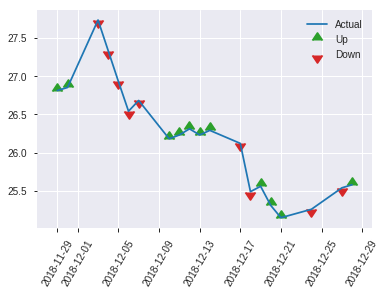


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22165987104215992
RMSE: 0.47080767946387614
LogLoss: 0.637336220960133
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.9774746766028
Residual deviance: 319.94278292198675
AIC: 421.94278292198675
AUC: 0.7003831417624521
pr_auc: 0.6756921308102863
Gini: 0.4007662835249042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607499156490512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   87   0.75     (87.0/116.0)
1      4    131  0.0296   (4.0/135.0)
Total  33   218  0.3625   (91.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26075      0.74221   217
max f2                       0.26075      0.864116  217
max f0point5                 0.470675     0.694635  147
max accuracy                 0.470675     0.677291  147
max precision                0.914953     1         0
max recall                   0.0818126    1         249
max specificity              0.914953     1         0
max absolute_mcc             0.470675     0.347624  147
max min_per_class_accuracy   0.502481     0.655172  128
max mean_per_class_accuracy  0.470675     0.671488  147

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892346           1.23951   1.23951            0.666667         0.907112  0.666667                    0.907112            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.866781           1.23951   1.23951            0.666667         0.877059  0.666667                    0.892085            0.0148148       0.0296296                  23.9506   23.9506
    3        0.0318725                   0.846649           0.92963   1.16204            0.5              0.854925  0.625                       0.882795            0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.832145           1.23951   1.18316            0.666667         0.83666   0.636364                    0.870213            0.0148148       0.0518519                  23.9506   18.3165
    5        0.0517928                   0.799807           1.85926   1.28718            1                0.805764  0.692308                    0.860298            0.0148148       0.0666667                  85.9259   28.7179
    6        0.103586                    0.738989           1.28718   1.28718            0.692308         0.767829  0.692308                    0.814063            0.0666667       0.133333                   28.7179   28.7179
    7        0.151394                    0.697698           1.70432   1.41891            0.916667         0.718762  0.763158                    0.783968            0.0814815       0.214815                   70.4321   41.8908
    8        0.203187                    0.663447           1.14416   1.34887            0.615385         0.679115  0.72549                     0.757241            0.0592593       0.274074                   14.416    34.8874
    9        0.302789                    0.62371            1.41304   1.36998            0.76             0.643314  0.736842                    0.719765            0.140741        0.414815                   41.3037   36.9981
    10       0.40239                     0.547707           1.2643    1.34382            0.68             0.585155  0.722772                    0.686446            0.125926        0.540741                   26.4296   34.3821
    11       0.501992                    0.510156           1.04119   1.28377            0.56             0.529734  0.690476                    0.655352            0.103704        0.644444                   4.11852   28.3774
    12       0.601594                    0.453599           1.04119   1.24361            0.56             0.48373   0.668874                    0.626938            0.103704        0.748148                   4.11852   24.361
    13       0.701195                    0.368303           0.818074  1.18316            0.44             0.402931  0.636364                    0.595119            0.0814815       0.82963                    -18.1926  18.3165
    14       0.800797                    0.304959           0.594963  1.11001            0.32             0.333957  0.597015                    0.562636            0.0592593       0.888889                   -40.5037  11.0006
    15       0.900398                    0.212581           0.818074  1.07771            0.44             0.269998  0.579646                    0.530264            0.0814815       0.97037                    -18.1926  7.77122
    16       1                           0.051474           0.297481  1                  0.16             0.15085   0.537849                    0.492474          

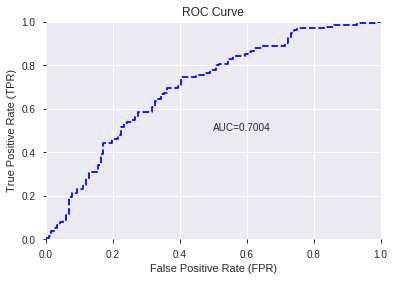

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


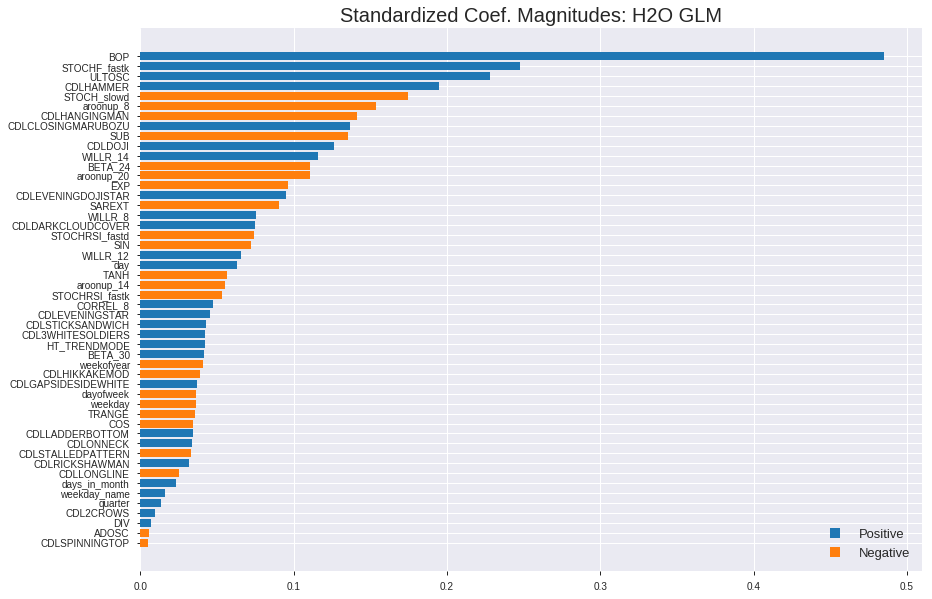

'log_likelihood'
--2019-07-25 01:58:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_015826_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_015826_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLHAMMER',
 'STOCH_slowd',
 'aroonup_8',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLDOJI',
 'WILLR_14',
 'BETA_24',
 'aroonup_20',
 'EXP',
 'CDLEVENINGDOJISTAR',
 'SAREXT',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastd',
 'SIN',
 'WILLR_12',
 'day',
 'TANH',
 'aroonup_14',
 'STOCHRSI_fastk',
 'CORREL_8',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH',
 'CDL3WHITESOLDIERS',
 'HT_TRENDMODE',
 'BETA_30',
 'weekofyear',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'dayofweek',
 'weekday',
 'TRANGE',
 'COS',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLSTALLEDPATTERN',
 'CDLRICKSHAWMAN',
 'CDLLONGLINE',
 'days_in_month',
 'weekday_name',
 'quarter',
 'CDL2CROWS',
 'DIV',
 'ADOSC',
 'CDLSPINNINGTOP']

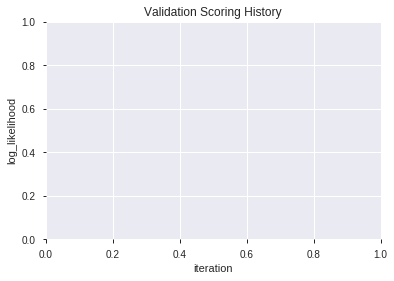

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_015840_model_2  0.712197  0.626137              0.330204  0.466482  0.217605
1  XGBoost_grid_1_AutoML_20190725_015840_model_6  0.703576  0.626478              0.336941  0.466578  0.217695
2  XGBoost_grid_1_AutoML_20190725_015840_model_4  0.702299  0.624901              0.336335  0.465879  0.217043
3               XGBoost_3_AutoML_20190725_015840  0.697637  0.631200              0.316124  0.468516  0.219507
4               XGBoost_2_AutoML_20190725_015840  0.694189  0.636945              0.318487  0.471045  0.221884
5  XGBoost_grid_1_AutoML_20190725_015840_model_3  0.691954  0.640338              0.337612  0.472149  0.222925
6  XGBoost_grid_1_AutoML_20190725_015840_model_1  0.690996  0.633772              0.357280  0.470552  0.221420
7               XGBoost_1_AutoML_20190725_015840  0.684291  0.645284              0.365900  0.474608  0.225252
8  XGBoost_grid_1_AutoML_20190725_015840_model_7  0.678799  0.653870              0.339496  0.478069  0.228550
9  XGBoost_grid_1_AutoML_20190725_015840_model_5  0.672031  0.658495              0.377554  0.481471  0.231814

variable  relative_importance  scaled_importance  percentage
0                  BOP          2152.103027           1.000000    0.300868
1         STOCHF_fastk           538.681824           0.250305    0.075309
2              BETA_30           279.281250           0.129771    0.039044
3                  SUB           277.614410           0.128997    0.038811
4                  EXP           261.503265           0.121511    0.036559
5                  DIV           250.024231           0.116177    0.034954
6       STOCHRSI_fastd           242.833496           0.112835    0.033949
7                ADOSC           229.101776           0.106455    0.032029
8                  COS           218.199417           0.101389    0.030505
9               SAREXT           216.157394           0.100440    0.030219
10            CORREL_8           209.156113           0.097187    0.029240
11                 SIN           207.497604           0.096416    0.029009
12         STOCH_slowd           204.492523           0.095020    0.028588
13             BETA_24           187.631363           0.087185    0.026231
14              ULTOSC           166.632126           0.077428    0.023295
15      STOCHRSI_fastk           160.156570           0.074419    0.022390
16          weekofyear           158.191772           0.073506    0.022115
17                 day           152.520462           0.070870    0.021323
18            WILLR_12           126.301720           0.058688    0.017657
19              TRANGE           125.047501           0.058105    0.017482
20           dayofweek           115.487152           0.053662    0.016145
21             WILLR_8           110.731506           0.051453    0.015480
22            WILLR_14           100.549835           0.046722    0.014057
23           CDLHAMMER            89.768753           0.041712    0.012550
24           aroonup_8            77.342049           0.035938    0.010813
25          aroonup_14            70.399582           0.032712    0.009842
26          aroonup_20            60.684807           0.028198    0.008484
27        weekday_name            33.720036           0.015668    0.004714
28      CDLSPINNINGTOP            28.328173           0.013163    0.003960
29             CDLDOJI            26.622087           0.012370    0.003722
30      CDLRICKSHAWMAN            17.238249           0.008010    0.002410
31             quarter            12.908432           0.005998    0.001805
32       days_in_month            12.554960           0.005834    0.001755
33         CDLLONGLINE             9.095932           0.004227    0.001272
34   CDLDARKCLOUDCOVER             8.116921           0.003772    0.001135
35  CDLCLOSINGMARUBOZU             7.643034           0.003551    0.001069
36             weekday             7.436315           0.003455    0.001040
37        HT_TRENDMODE             1.235263           0.000574    0.000173

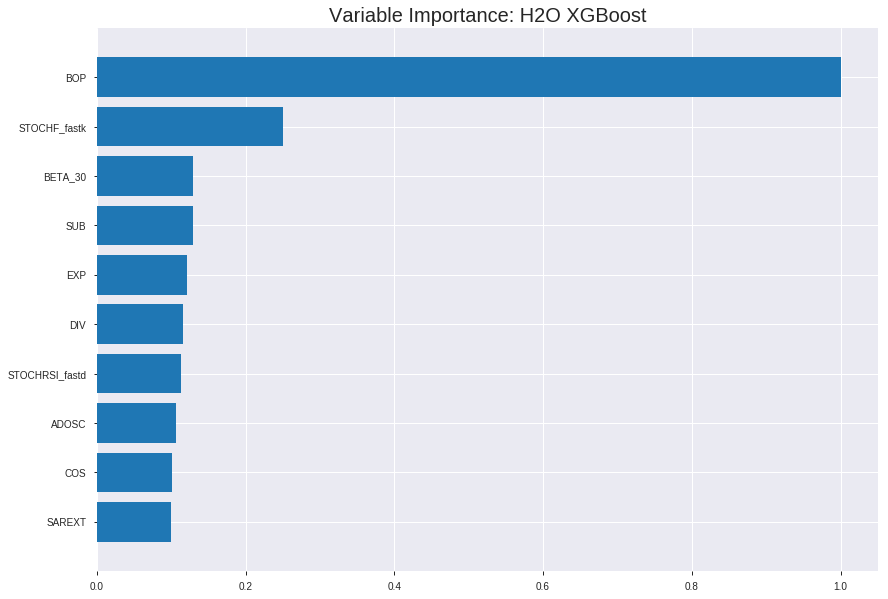

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_015840_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16674454358268895
RMSE: 0.40834365867818856
LogLoss: 0.5129031736595431
Mean Per-Class Error: 0.21293186929901287
AUC: 0.8693543306676663
pr_auc: 0.8804863368325632
Gini: 0.7387086613353326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4842221438884735: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      561  287   0.3384   (287.0/848.0)
1      119  787   0.1313   (119.0/906.0)
Total  680  1074  0.2315   (406.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484222     0.794949  215
max f2                       0.276929     0.878472  323
max f0point5                 0.593404     0.809536  149
max accuracy                 0.559149     0.786773  171
max precision                0.843765     1         0
max recall                   0.172341     1         379
max specificity              0.843765     1         0
max absolute_mcc             0.559149     0.573823  171
max min_per_class_accuracy   0.554891     0.784768  174
max mean_per_class_accuracy  0.559149     0.787068  171

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.812134           1.93598    1.93598            1                0.823153  1                           0.823153            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.788102           1.82843    1.88221            0.944444         0.795211  0.972222                    0.809182            0.0187638       0.0386313                  82.8428   88.2205
    3        0.0302166                   0.779402           1.93598    1.89945            1                0.784163  0.981132                    0.801157            0.0187638       0.0573951                  93.5982   89.9454
    4        0.0404789                   0.772097           1.93598    1.90871            1                0.774602  0.985915                    0.794425            0.0198675       0.0772627                  93.5982   90.8715
    5        0.050171                    0.765424           1.93598    1.91398            1                0.768931  0.988636                    0.7895              0.0187638       0.0960265                  93.5982   91.3983
    6        0.100342                    0.736551           1.93598    1.92498            1                0.749859  0.994318                    0.76968             0.0971302       0.193157                   93.5982   92.4982
    7        0.149943                    0.712184           1.86922    1.90654            0.965517         0.724708  0.984791                    0.754803            0.0927152       0.285872                   86.9224   90.6538
    8        0.200114                    0.690659           1.60599    1.83119            0.829545         0.70188   0.945869                    0.741535            0.080574        0.366446                   60.5985   83.1186
    9        0.299886                    0.648142           1.62623    1.763              0.84             0.668528  0.910646                    0.717245            0.162252        0.528698                   62.6225   76.2995
    10       0.400228                    0.605786           1.29799    1.64641            0.670455         0.626906  0.850427                    0.694596            0.130243        0.65894                    29.7988   64.6412
    11       0.5                         0.558566           1.18371    1.55408            0.611429         0.582749  0.802737                    0.672278            0.118102        0.777042                   18.3715   55.4084
    12       0.599772                    0.49475            0.818644   1.43174            0.422857         0.527668  0.739544                    0.648222            0.0816777       0.85872                    -18.1356  43.1744
    13       0.700114                    0.408469           0.604994   1.31325            0.3125           0.452387  0.678339                    0.620154            0.0607064       0.919426                   -39.5006  31.3252
    14       0.799886                    0.305409           0.542075   1.21706            0.28             0.358657  0.628653                    0.587537            0.0540839       0.97351                    -45.7925  21.7061
    15       0.899658                    0.217356           0.232318   1.10785            0.12             0.258895  0.572243                    0.551091            0.0231788       0.996689                   -76.7682  10.7853
    16       1                           0.125604           0.0329997  1                  0.0170455        0.178193  0.516534                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21710307919013366
RMSE: 0.46594321455530785
LogLoss: 0.6237838072844152
Mean Per-Class Error: 0.33189268792419013
AUC: 0.7084053656037904
pr_auc: 0.7225939834034724
Gini: 0.41681073120758083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3538801968097687: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   147  0.6447   (147.0/228.0)
1      31   243  0.1131   (31.0/274.0)
Total  112  390  0.3546   (178.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35388      0.731928  300
max f2                       0.204421     0.86471   369
max f0point5                 0.629637     0.703883  133
max accuracy                 0.49067      0.659363  239
max precision                0.81964      1         0
max recall                   0.15147      1         394
max specificity              0.81964      1         0
max absolute_mcc             0.629637     0.345507  133
max min_per_class_accuracy   0.579464     0.649123  183
max mean_per_class_accuracy  0.629637     0.668107  133

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.776675           1.52676   1.52676            0.833333         0.791897  0.833333                    0.791897            0.0182482       0.0182482                  52.6764   52.6764
    2        0.0219124                   0.769132           1.83212   1.66556            1                0.770363  0.909091                    0.782109            0.0182482       0.0364964                  83.2117   66.5561
    3        0.0318725                   0.756583           1.83212   1.71761            1                0.759018  0.9375                      0.774893            0.0182482       0.0547445                  83.2117   71.7609
    4        0.0418327                   0.750203           1.46569   1.65763            0.8              0.753175  0.904762                    0.769722            0.0145985       0.0693431                  46.5693   65.7629
    5        0.0517928                   0.745964           1.09927   1.55025            0.6              0.747033  0.846154                    0.765359            0.0109489       0.080292                   9.92701   55.0253
    6        0.101594                    0.717531           1.39241   1.47288            0.76             0.731355  0.803922                    0.74869             0.0693431       0.149635                   39.2409   47.2878
    7        0.151394                    0.697328           1.09927   1.34998            0.6              0.706914  0.736842                    0.734948            0.0547445       0.20438                    9.92701   34.9981
    8        0.201195                    0.679906           1.53898   1.39676            0.84             0.688013  0.762376                    0.72333             0.0766423       0.281022                   53.8978   39.6762
    9        0.300797                    0.65042            1.46569   1.41959            0.8              0.666368  0.774834                    0.704469            0.145985        0.427007                   46.5693   41.9587
    10       0.400398                    0.622726           1.24584   1.37637            0.68             0.636466  0.751244                    0.687553            0.124088        0.551095                   24.5839   37.6366
    11       0.5                         0.584687           0.806131  1.26277            0.44             0.609195  0.689243                    0.671944            0.080292        0.631387                   -19.3869  26.2774
    12       0.599602                    0.520702           1.02599   1.22344            0.56             0.556647  0.667774                    0.652791            0.10219         0.733577                   2.59854   22.344
    13       0.699203                    0.436747           0.842774  1.16921            0.46             0.480367  0.638177                    0.628229            0.0839416       0.817518                   -15.7226  16.9214
    14       0.798805                    0.33998            0.806131  1.12394            0.44             0.379642  0.613466                    0.597234            0.080292        0.89781                    -19.3869  12.3942
    15       0.898406                    0.246432           0.62292   1.0684             0.34             0.294819  0.583149                    0.563706            0.0620438       0.959854                   -37.708   6.83963
    16       1                           0.138546           0.395162  1                  0.215686         0.190624  0.545817                    0.525804          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:58:44  0.558 sec   0                  0.5              0.693147            0.5             0                  1                0.483466                         0.5                0.693147              0.5               0                    1                  0.454183
    2019-07-25 01:58:44  0.622 sec   5                  0.4812           0.656132            0.794738        0.655021           1.60699          0.27081                          0.488722           0.670778              0.690277          0.642533             1.42498            0.350598
    2019-07-25 01:58:44  0.666 sec   10                 0.466952         0.628542            0.805296        0.7874             1.83409          0.263968                         0.481609           0.6567                0.68762           0.702657             1.52676            0.364542
    2019-07-25 01:58:44  0.715 sec   15                 0.455428         0.606236            0.813977        0.803254           1.82843          0.27423                          0.475985           0.645473              0.695744          0.708345             1.52676            0.35259
    2019-07-25 01:58:44  0.768 sec   20                 0.446024         0.587907            0.822848        0.822501           1.93598          0.259977                         0.472373           0.638094              0.70069           0.715952             1.52676            0.36255
    2019-07-25 01:58:44  0.816 sec   25                 0.438502         0.573029            0.830135        0.835221           1.93598          0.266249                         0.471208           0.635518              0.699826          0.719178             1.52676            0.360558
    2019-07-25 01:58:44  0.866 sec   30                 0.431922         0.559915            0.837275        0.844684           1.93598          0.253136                         0.469696           0.632305              0.701818          0.714337             1.52676            0.368526
    2019-07-25 01:58:44  0.918 sec   35                 0.426581         0.549198            0.843242        0.851389           1.93598          0.257127                         0.46889            0.630464              0.702699          0.717095             1.52676            0.366534
    2019-07-25 01:58:44  0.974 sec   40                 0.421527         0.539074            0.849955        0.859707           1.93598          0.250855                         0.46777            0.627971              0.705876          0.723691             1.52676            0.370518
    2019-07-25 01:58:44  1.030 sec   45                 0.417102         0.530297            0.856554        0.866838           1.93598          0.244584                         0.466982           0.626213              0.707093          0.722429             1.52676            0.37251
    2019-07-25 01:58:44  1.087 sec   50                 0.412876         0.521889            0.862963        0.873374           1.93598          0.22577                          0.466677           0.62544               0.705532          0.720691             1.52676            0.354582
    2019-07-25 01:58:44  1.150 sec   55                 0.408344         0.512903            0.869354        0.880486           1.93598          0.231471                         0.465943           0.623784              0.708405          0.72

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2152.10302734375       1.0                    0.3008675738312025
STOCHF_fastk        538.6818237304688      0.2503048492038697     0.07530861269815327
BETA_30             279.28125              0.12977131970522113    0.0390439821125832
SUB                 277.6144104003906      0.12899680306803823    0.03881095517106208
EXP                 261.5032653808594      0.12151056992081918    0.036558590366923556
---                 ---                    ---                    ---
CDLLONGLINE         9.095932006835938      0.004226531858032216   0.0012716263858464374
CDLDARKCLOUDCOVER   8.116921424865723      0.003771623069033129   0.0011347590821857915
CDLCLOSINGMARUBOZU  7.6430344581604        0.0035514259127240183  0.0010685088980025392
weekday             7.436314582824707      0.0034553710897396194  0.0010396091164564375
HT_TRENDMODE        1.2352628707885742     0.0005739794308608019  0.00017269179879210388


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7492063492063492)

('auc', 0.7121966794380588)

('logloss', 0.6261374633489114)

('mean_per_class_error', 0.3295977011494253)

('rmse', 0.4664818902205955)

('mse', 0.21760535390377972)

xgboost prediction progress: |████████████████████████████████████████████| 100%


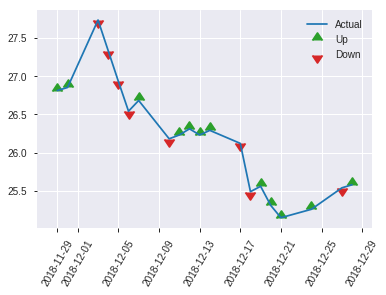


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21760535390377972
RMSE: 0.4664818902205955
LogLoss: 0.6261374633489114
Mean Per-Class Error: 0.3295977011494253
AUC: 0.7121966794380588
pr_auc: 0.7105485737853288
Gini: 0.4243933588761175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3690261244773865: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   62   0.5345   (62.0/116.0)
1      17   118  0.1259   (17.0/135.0)
Total  71   180  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369026     0.749206  179
max f2                       0.138755     0.85335   250
max f0point5                 0.372379     0.690673  177
max accuracy                 0.372379     0.685259  177
max precision                0.790888     1         0
max recall                   0.138755     1         250
max specificity              0.790888     1         0
max absolute_mcc             0.369026     0.375913  179
max min_per_class_accuracy   0.51423      0.637931  128
max mean_per_class_accuracy  0.372379     0.670402  177

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 47.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.77208            1.23951   1.23951            0.666667         0.789784  0.666667                    0.789784            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.727415           1.85926   1.54938            1                0.737326  0.833333                    0.763555            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.724187           0.92963   1.39444            0.5              0.725351  0.75                        0.754004            0.00740741      0.0444444                  -7.03704  39.4444
    4        0.0438247                   0.716276           1.85926   1.52121            1                0.720164  0.818182                    0.744775            0.0222222       0.0666667                  85.9259   52.1212
    5        0.0517928                   0.705773           1.85926   1.57322            1                0.710548  0.846154                    0.739509            0.0148148       0.0814815                  85.9259   57.3219
    6        0.103586                    0.677981           1.4302    1.50171            0.769231         0.69154   0.807692                    0.715525            0.0740741       0.155556                   43.0199   50.1709
    7        0.151394                    0.663544           1.39444   1.46784            0.75             0.671502  0.789474                    0.701623            0.0666667       0.222222                   39.4444   46.7836
    8        0.203187                    0.63434            1.14416   1.38533            0.615385         0.64733   0.745098                    0.687783            0.0592593       0.281481                   14.416    38.533
    9        0.302789                    0.596766           1.33867   1.36998            0.72             0.616378  0.736842                    0.664295            0.133333        0.414815                   33.8667   36.9981
    10       0.40239                     0.557471           1.18993   1.32541            0.64             0.579579  0.712871                    0.643325            0.118519        0.533333                   18.9926   32.5413
    11       0.501992                    0.517956           0.966815  1.25426            0.52             0.53544   0.674603                    0.62192             0.0962963       0.62963                    -3.31852  25.4262
    12       0.601594                    0.450304           1.18993   1.24361            0.64             0.49135   0.668874                    0.600302            0.118519        0.748148                   18.9926   24.361
    13       0.701195                    0.378658           1.04119   1.21486            0.56             0.414997  0.653409                    0.57398             0.103704        0.851852                   4.11852   21.4857
    14       0.800797                    0.299394           0.594963  1.13776            0.32             0.336938  0.61194                     0.544497            0.0592593       0.911111                   -40.5037  13.7756
    15       0.900398                    0.214946           0.520593  1.06949            0.28             0.251207  0.575221                    0.512054            0.0518519       0.962963                   -47.9407  6.94854
    16       1                           0.138755           0.371852  1                  0.2              0.176991  0.537849                    0.478681           

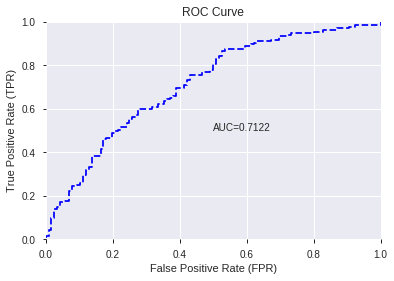

This function is available for GLM models only


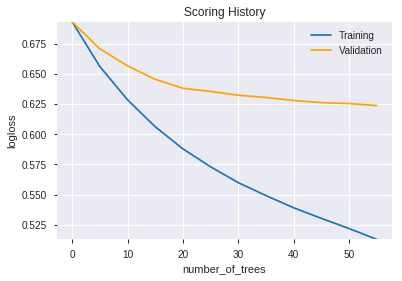

--2019-07-25 01:58:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_015840_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_015840_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'BETA_30',
 'SUB',
 'EXP',
 'DIV',
 'STOCHRSI_fastd',
 'ADOSC',
 'COS',
 'SAREXT',
 'CORREL_8',
 'SIN',
 'STOCH_slowd',
 'BETA_24',
 'ULTOSC',
 'STOCHRSI_fastk',
 'weekofyear',
 'day',
 'WILLR_12',
 'TRANGE',
 'dayofweek',
 'WILLR_8',
 'WILLR_14',
 'CDLHAMMER',
 'aroonup_8',
 'aroonup_14',
 'aroonup_20',
 'weekday_name',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'quarter',
 'days_in_month',
 'CDLLONGLINE',
 'CDLDARKCLOUDCOVER',
 'CDLCLOSINGMARUBOZU',
 'weekday',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_015901_model_1  0.714049  0.627272               0.33196  0.467939  0.218967

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.281429           1.000000  3.248632e-02
1                    CDLHAMMER             0.132350           0.470280  1.527766e-02
2                       ULTOSC             0.117349           0.416977  1.354603e-02
3                 STOCHF_fastk             0.114541           0.406998  1.322186e-02
4           CDLCLOSINGMARUBOZU             0.110743           0.393502  1.278344e-02
...                        ...                  ...                ...           ...
1035  BBANDS_middleband_12_1_4             0.000022           0.000077  2.498097e-06
1036  BBANDS_middleband_12_1_3             0.000021           0.000076  2.454066e-06
1037                    WMA_12             0.000008           0.000027  8.925117e-07
1038                   MA_12_1             0.000004           0.000013  4.372587e-07
1039   BBANDS_upperband_12_2_5             0.000003           0.000011  3.734445e-07

[1040 rows x 4 columns]

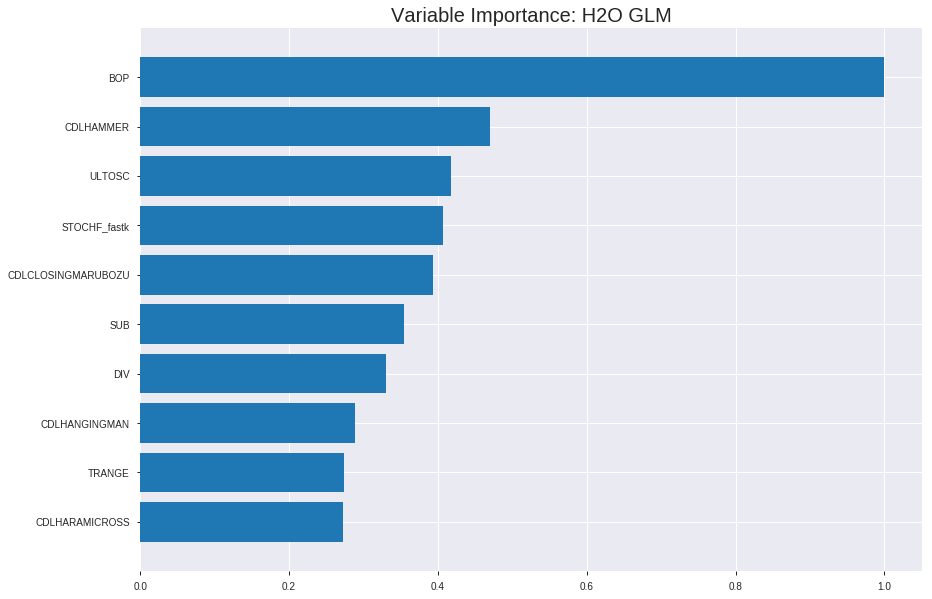

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_015901_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19543081937309442
RMSE: 0.44207558106402395
LogLoss: 0.5747883367376956
Null degrees of freedom: 1753
Residual degrees of freedom: 713
Null deviance: 2429.642057792962
Residual deviance: 2016.357485275836
AIC: 4098.357485275836
AUC: 0.7730050449831314
pr_auc: 0.7722982073471112
Gini: 0.5460100899662628
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4336646132539279: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      460  388   0.4575   (388.0/848.0)
1      130  776   0.1435   (130.0/906.0)
Total  590  1164  0.2953   (518.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433665     0.749758  243
max f2                       0.217464     0.853519  349
max f0point5                 0.542326     0.718651  183
max accuracy                 0.465976     0.710946  226
max precision                0.931772     1         0
max recall                   0.12249      1         384
max specificity              0.931772     1         0
max absolute_mcc             0.465976     0.426279  226
max min_per_class_accuracy   0.539875     0.703091  185
max mean_per_class_accuracy  0.465976     0.707289  226

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.85568            1.93598   1.93598            1                0.883346  1                           0.883346            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.837112           1.72087   1.82843            0.888889         0.845716  0.944444                    0.864531            0.01766         0.0375276                  72.0873   82.8428
    3        0.0302166                   0.823939           1.8221    1.8264             0.941176         0.830367  0.943396                    0.853573            0.01766         0.0551876                  82.2101   82.6398
    4        0.0404789                   0.810771           1.72087   1.79965            0.888889         0.817334  0.929577                    0.844385            0.01766         0.0728477                  72.0873   79.9646
    5        0.050171                    0.797615           1.48046   1.73798            0.764706         0.804868  0.897727                    0.836751            0.0143488       0.0871965                  48.0457   73.7984
    6        0.100342                    0.75195            1.69398   1.71598            0.875            0.772556  0.886364                    0.804654            0.084989        0.172185                   69.3985   71.5984
    7        0.149943                    0.720688           1.57994   1.67098            0.816092         0.73691   0.863118                    0.782244            0.0783664       0.250552                   57.994    67.0981
    8        0.200114                    0.690694           1.42999   1.61056            0.738636         0.70411   0.831909                    0.762655            0.0717439       0.322296                   42.9987   61.0561
    9        0.299886                    0.641905           1.36072   1.52744            0.702857         0.667306  0.788973                    0.730933            0.135762        0.458057                   36.0719   52.7439
    10       0.400228                    0.594051           1.18799   1.44233            0.613636         0.61947   0.745014                    0.702987            0.119205        0.577263                   18.7989   44.2334
    11       0.5                         0.542044           1.23903   1.40177            0.64             0.568705  0.724059                    0.676192            0.12362         0.700883                   23.9029   40.1766
    12       0.599772                    0.480398           0.951397  1.32685            0.491429         0.512624  0.685361                    0.648983            0.0949227       0.795806                   -4.8603   32.6847
    13       0.700114                    0.403473           0.857992  1.25965            0.443182         0.441835  0.650651                    0.619294            0.0860927       0.881898                   -14.2008  25.965
    14       0.799886                    0.327953           0.464636  1.16049            0.24             0.366229  0.59943                     0.587728            0.0463576       0.928256                   -53.5364  16.0485
    15       0.899658                    0.241248           0.497824  1.087              0.257143         0.288461  0.56147                     0.55454             0.0496689       0.977925                   -50.2176  8.69964
    16       1                           0.0300687          0.219998  1                  0.113636         0.175776  0.516534                    0.516534          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21044170707547374
RMSE: 0.4587392582671269
LogLoss: 0.6058758984135242
Null degrees of freedom: 501
Residual degrees of freedom: -539
Null deviance: 693.4256799911966
Residual deviance: 608.2994020071783
AIC: 2690.2994020071783
AUC: 0.7256530925854784
pr_auc: 0.768466326690959
Gini: 0.4513061851709568
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3012687546430218: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   171  0.75     (171.0/228.0)
1      13   261  0.0474   (13.0/274.0)
Total  70   432  0.3665   (184.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301269     0.739377  339
max f2                       0.160706     0.864353  387
max f0point5                 0.63368      0.702648  133
max accuracy                 0.58943      0.665339  177
max precision                0.888091     1         0
max recall                   0.160706     1         387
max specificity              0.888091     1         0
max absolute_mcc             0.66613      0.349886  105
max min_per_class_accuracy   0.566305     0.645985  195
max mean_per_class_accuracy  0.58943      0.6695    177

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 54.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.859239           1.83212   1.83212            1                0.869916  1                           0.869916            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.837515           1.83212   1.83212            1                0.84637   1                           0.859213            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.824781           1.83212   1.83212            1                0.831069  1                           0.850418            0.0182482       0.0583942                  83.2117   83.2117
    4        0.0418327                   0.814689           1.46569   1.74487            0.8              0.816645  0.952381                    0.842377            0.0145985       0.0729927                  46.5693   74.4873
    5        0.0517928                   0.806544           1.83212   1.76165            1                0.809835  0.961538                    0.836119            0.0182482       0.0912409                  83.2117   76.1651
    6        0.101594                    0.773457           1.53898   1.6525             0.84             0.786822  0.901961                    0.811954            0.0766423       0.167883                   53.8978   65.2497
    7        0.151394                    0.72896            1.46569   1.59105            0.8              0.752988  0.868421                    0.792557            0.0729927       0.240876                   46.5693   59.1049
    8        0.201195                    0.697986           1.46569   1.56002            0.8              0.716448  0.851485                    0.773718            0.0729927       0.313869                   46.5693   56.002
    9        0.300797                    0.655674           1.24584   1.45599            0.68             0.675506  0.794702                    0.741198            0.124088        0.437956                   24.5839   45.5987
    10       0.400398                    0.620193           1.06263   1.35814            0.58             0.635755  0.741294                    0.714968            0.105839        0.543796                   6.26277   35.8136
    11       0.5                         0.570552           0.916058  1.27007            0.5              0.59708   0.693227                    0.691484            0.0912409       0.635036                   -8.39416  27.0073
    12       0.599602                    0.526601           0.732847  1.18083            0.4              0.551441  0.644518                    0.668221            0.0729927       0.708029                   -26.7153  18.0833
    13       0.699203                    0.444998           1.02599   1.15877            0.56             0.490646  0.632479                    0.642926            0.10219         0.810219                   2.59854   15.8775
    14       0.798805                    0.364088           0.879416  1.12394            0.48             0.39882   0.613466                    0.612489            0.0875912       0.89781                    -12.0584  12.3942
    15       0.898406                    0.262684           0.732847  1.08058            0.4              0.316574  0.5898                      0.579682            0.0729927       0.970803                   -26.7153  8.05833
    16       1                           0.0619488          0.287391  1                  0.156863         0.198803  0.545817                    0.540987          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 01:59:04  0.000 sec   2            .18E2     1041          1.354981679532798   1.3535159370594871
     2019-07-25 01:59:06  1.810 sec   4            .13E2     1041          1.348318917876601   1.3482583235663066
     2019-07-25 01:59:08  3.620 sec   6            .96E1     1041          1.3402018542063119  1.3415126208557242
     2019-07-25 01:59:10  5.484 sec   8            .7E1      1041          1.330637602236124   1.333528905017626
     2019-07-25 01:59:12  7.336 sec   10           .51E1     1041          1.3195364048094131  1.3242959326784272
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 01:59:36  31.394 sec  36           .82E-1    1041          1.1396374371391522  1.2127984780877605
     2019-07-25 01:59:37  33.245 sec  38           .6E-1     1041          1.1306999401258315  1.2164719978738199
     2019-07-25 01:59:39  35.117 sec  40           .44E-1    1041          1.122681470255353   1.222734707497281
     2019-07-25 01:59:42  38.017 sec  42           .32E-1    1041          1.1154274252292848  1.2314418823856739
     2019-07-25 01:59:44  39.922 sec  44           .23E-1    1041          1.108779540257127   1.2424377234337611


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7664670658682635)

('auc', 0.7140485312899106)

('logloss', 0.627272391820092)

('mean_per_class_error', 0.3254150702426565)

('rmse', 0.4679388729193258)

('mse', 0.2189667887890089)

glm prediction progress: |████████████████████████████████████████████████| 100%


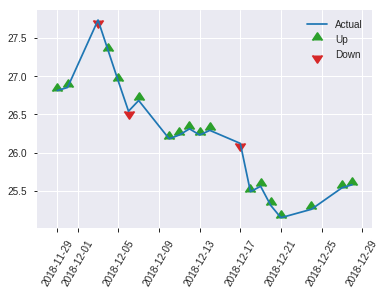


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2189667887890089
RMSE: 0.4679388729193258
LogLoss: 0.627272391820092
Null degrees of freedom: 250
Residual degrees of freedom: -790
Null deviance: 346.9774746766028
Residual deviance: 314.8907406936862
AIC: 2396.890740693686
AUC: 0.7140485312899106
pr_auc: 0.6887376268038776
Gini: 0.4280970625798213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30119753194032056: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   71   0.6121   (71.0/116.0)
1      7    128  0.0519   (7.0/135.0)
Total  52   199  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301198     0.766467  198
max f2                       0.244114     0.869565  218
max f0point5                 0.402172     0.696888  150
max accuracy                 0.345932     0.689243  180
max precision                0.857693     1         0
max recall                   0.105694     1         246
max specificity              0.857693     1         0
max absolute_mcc             0.301198     0.413437  198
max min_per_class_accuracy   0.477856     0.651852  125
max mean_per_class_accuracy  0.402172     0.674585  150

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 46.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.833556           1.85926   1.85926            1                0.849316  1                           0.849316            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.791053           1.23951   1.54938            0.666667         0.817645  0.833333                    0.833481            0.0148148       0.037037                   23.9506   54.9383
    3        0.0318725                   0.780071           0.92963   1.39444            0.5              0.785093  0.75                        0.821384            0.00740741      0.0444444                  -7.03704  39.4444
    4        0.0438247                   0.761334           1.23951   1.35219            0.666667         0.770367  0.727273                    0.80747             0.0148148       0.0592593                  23.9506   35.2189
    5        0.0517928                   0.758619           0.92963   1.28718            0.5              0.760201  0.692308                    0.800198            0.00740741      0.0666667                  -7.03704  28.7179
    6        0.103586                    0.708531           1.28718   1.28718            0.692308         0.730447  0.692308                    0.765323            0.0666667       0.133333                   28.7179   28.7179
    7        0.151394                    0.672412           1.39444   1.32105            0.75             0.692797  0.710526                    0.74242             0.0666667       0.2                        39.4444   32.1053
    8        0.203187                    0.647758           1.4302    1.34887            0.769231         0.659255  0.72549                     0.721221            0.0740741       0.274074                   43.0199   34.8874
    9        0.302789                    0.587821           1.33867   1.34552            0.72             0.613938  0.723684                    0.685931            0.133333        0.407407                   33.8667   34.5517
    10       0.40239                     0.54087            1.2643    1.32541            0.68             0.564231  0.712871                    0.655807            0.125926        0.533333                   26.4296   32.5413
    11       0.501992                    0.477856           1.18993   1.29853            0.64             0.509286  0.698413                    0.626735            0.118519        0.651852                   18.9926   29.853
    12       0.601594                    0.402172           1.11556   1.26824            0.6              0.441172  0.682119                    0.596013            0.111111        0.762963                   11.5556   26.8236
    13       0.701195                    0.351371           0.892444  1.21486            0.48             0.371707  0.653409                    0.564151            0.0888889       0.851852                   -10.7556  21.4857
    14       0.800797                    0.299549           0.966815  1.18401            0.52             0.328558  0.636816                    0.534849            0.0962963       0.948148                   -3.31852  18.4006
    15       0.900398                    0.219459           0.297481  1.08594            0.16             0.261055  0.584071                    0.504562            0.0296296       0.977778                   -70.2519  8.5939
    16       1                           0.0756398          0.223111  1                  0.12             0.149107  0.537849                    0.469158           

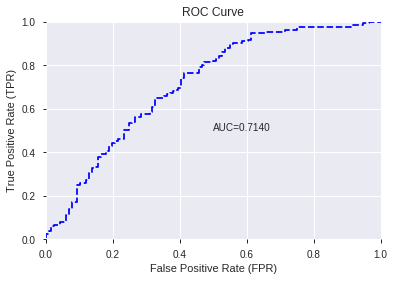

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


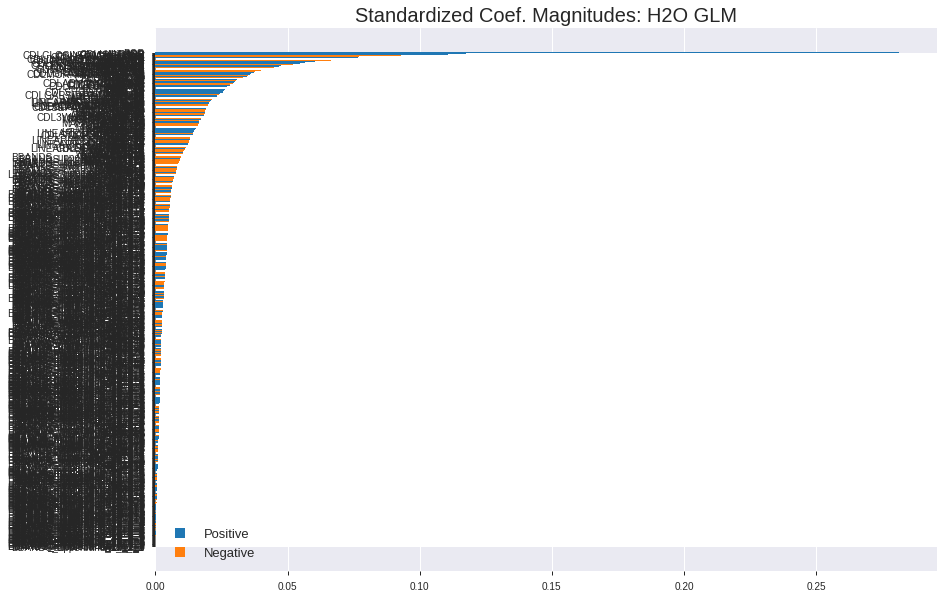

'log_likelihood'
--2019-07-25 02:00:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_015901_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_015901_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

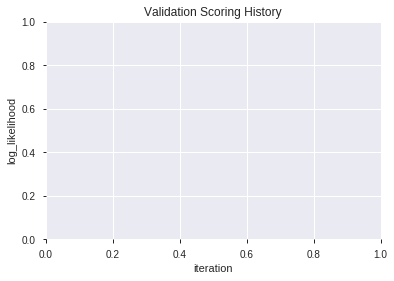

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_020011_model_5  0.705109  0.628071              0.352299  0.468116  0.219133
1  XGBoost_grid_1_AutoML_20190725_020011_model_2  0.702554  0.626044              0.325287  0.466768  0.217873
2  XGBoost_grid_1_AutoML_20190725_020011_model_4  0.701469  0.625723              0.342465  0.466681  0.217791
3               XGBoost_1_AutoML_20190725_020011  0.700702  0.619805              0.347382  0.463998  0.215294
4  XGBoost_grid_1_AutoML_20190725_020011_model_6  0.696679  0.620403              0.352905  0.464433  0.215698
5  XGBoost_grid_1_AutoML_20190725_020011_model_7  0.693167  0.629626              0.357822  0.468931  0.219896
6  XGBoost_grid_1_AutoML_20190725_020011_model_3  0.692848  0.632004              0.360920  0.469984  0.220885
7  XGBoost_grid_1_AutoML_20190725_020011_model_1  0.686271  0.633414              0.338825  0.469695  0.220614
8               XGBoost_3_AutoML_20190725_020011  0.684419  0.627721              0.341252  0.467777  0.218815
9               XGBoost_2_AutoML_20190725_020011  0.680524  0.632165              0.343678  0.470408  0.221284

variable  relative_importance  scaled_importance  percentage
0                        BOP          1225.672607           1.000000    0.050827
1               STOCHF_fastk           601.728394           0.490937    0.024953
2                     Volume           445.166290           0.363202    0.018460
3                        day           365.899414           0.298529    0.015173
4                       Open           316.109314           0.257907    0.013109
..                       ...                  ...                ...         ...
635  BBANDS_upperband_14_2_3             0.873561           0.000713    0.000036
636                   MA_8_4             0.761886           0.000622    0.000032
637  BBANDS_lowerband_12_7_3             0.715493           0.000584    0.000030
638  BBANDS_lowerband_14_1_3             0.363163           0.000296    0.000015
639  BBANDS_upperband_24_1_2             0.087692           0.000072    0.000004

[640 rows x 4 columns]

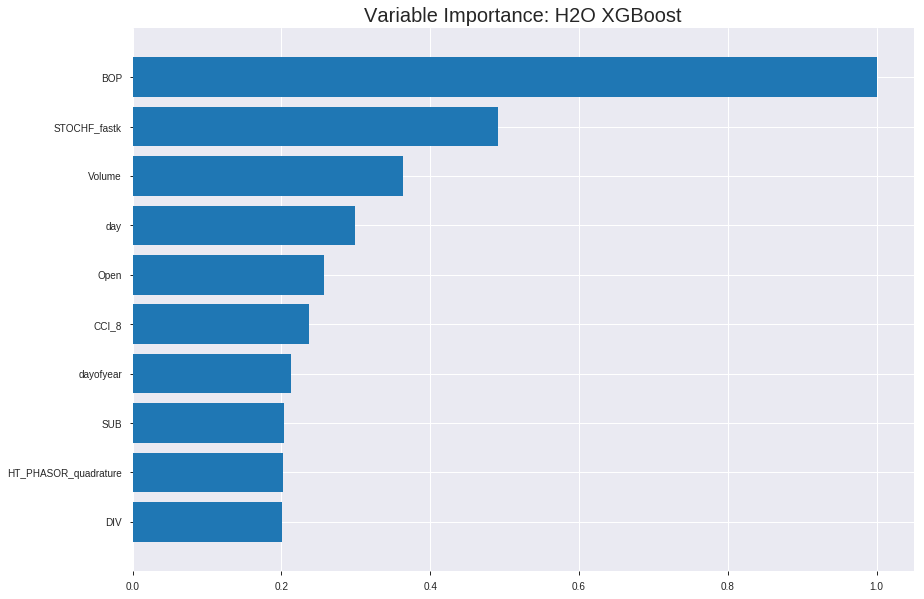

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_020011_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03205260812641193
RMSE: 0.17903242199783795
LogLoss: 0.18237676402899308
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988962472406181
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.490720272064209: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      848  0    0        (0.0/848.0)
1      0    906  0        (0.0/906.0)
Total  848  906  0        (0.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.49072      1        197
max f2                       0.49072      1        197
max f0point5                 0.49072      1        197
max accuracy                 0.49072      1        197
max precision                0.951923     1        0
max recall                   0.49072      1        197
max specificity              0.951923     1        0
max absolute_mcc             0.49072      1        197
max min_per_class_accuracy   0.49072      1        197
max mean_per_class_accuracy  0.49072      1        197

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.53 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102623                   0.932445           1.93598  1.93598            1                0.939571   1                           0.939571            0.0198675       0.0198675                  93.5982  93.5982
    2        0.0205245                   0.926835           1.93598  1.93598            1                0.929319   1                           0.934445            0.0198675       0.0397351                  93.5982  93.5982
    3        0.0302166                   0.92286            1.93598  1.93598            1                0.924804   1                           0.931353            0.0187638       0.0584989                  93.5982  93.5982
    4        0.0404789                   0.918876           1.93598  1.93598            1                0.920789   1                           0.928674            0.0198675       0.0783664                  93.5982  93.5982
    5        0.050171                    0.914842           1.93598  1.93598            1                0.916543   1                           0.926331            0.0187638       0.0971302                  93.5982  93.5982
    6        0.100342                    0.898933           1.93598  1.93598            1                0.906905   1                           0.916618            0.0971302       0.19426                    93.5982  93.5982
    7        0.149943                    0.883504           1.93598  1.93598            1                0.890703   1                           0.908045            0.0960265       0.290287                   93.5982  93.5982
    8        0.200114                    0.872032           1.93598  1.93598            1                0.877687   1                           0.900434            0.0971302       0.387417                   93.5982  93.5982
    9        0.299886                    0.841131           1.93598  1.93598            1                0.8567     1                           0.885884            0.193157        0.580574                   93.5982  93.5982
    10       0.400228                    0.799869           1.93598  1.93598            1                0.821353   1                           0.869705            0.19426         0.774834                   93.5982  93.5982
    11       0.5                         0.678739           1.93598  1.93598            1                0.761035   1                           0.848021            0.193157        0.967991                   93.5982  93.5982
    12       0.599772                    0.245645           0.32082  1.6673             0.165714         0.351796   0.861217                    0.765474            0.0320088       1                          -67.918  66.73
    13       0.700114                    0.182189           0        1.42834            0                0.212382   0.737785                    0.686203            0               1                          -100     42.8339
    14       0.799886                    0.133808           0        1.25018            0                0.15841    0.645759                    0.62037             0               1                          -100     25.0178
    15       0.899658                    0.0964288          0        1.11153            0                0.11598    0.574144                    0.564433            0               1                          -100     11.1534
    16       1                           0.0432162          0        1                  0                0.0750694  0.516534                    0.51533             0               



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22767901882813965
RMSE: 0.47715722652825837
LogLoss: 0.6480496576020227
Mean Per-Class Error: 0.35694391087207067
AUC: 0.670908567038033
pr_auc: 0.7003946708350786
Gini: 0.34181713407606606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27882739901542664: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      60   168  0.7368   (168.0/228.0)
1      21   253  0.0766   (21.0/274.0)
Total  81   421  0.3765   (189.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278827     0.728058  326
max f2                       0.0937318    0.861094  392
max f0point5                 0.454957     0.676761  251
max accuracy                 0.454957     0.657371  251
max precision                0.904532     1         0
max recall                   0.0937318    1         392
max specificity              0.904532     1         0
max absolute_mcc             0.454957     0.3028    251
max min_per_class_accuracy   0.550292     0.614035  193
max mean_per_class_accuracy  0.454957     0.643056  251

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.887416           1.83212   1.83212            1                0.892876  1                           0.892876            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.856581           1.46569   1.66556            0.8              0.864075  0.909091                    0.879784            0.0145985       0.0364964                  46.5693   66.5561
    3        0.0318725                   0.843253           1.83212   1.71761            1                0.849719  0.9375                      0.870389            0.0182482       0.0547445                  83.2117   71.7609
    4        0.0418327                   0.830943           1.09927   1.57039            0.6              0.835273  0.857143                    0.862028            0.0109489       0.0656934                  9.92701   57.0386
    5        0.0517928                   0.807929           1.46569   1.55025            0.8              0.816991  0.846154                    0.853367            0.0145985       0.080292                   46.5693   55.0253
    6        0.101594                    0.764918           1.46569   1.5088             0.8              0.786844  0.823529                    0.820758            0.0729927       0.153285                   46.5693   50.8802
    7        0.151394                    0.72927            1.24584   1.4223             0.68             0.745933  0.776316                    0.796144            0.0620438       0.215328                   24.5839   42.2301
    8        0.201195                    0.708915           1.17255   1.36048            0.64             0.720639  0.742574                    0.777455            0.0583942       0.273723                   17.2555   36.0483
    9        0.300797                    0.650549           1.13591   1.28612            0.62             0.678699  0.701987                    0.744754            0.113139        0.386861                   13.5912   28.6122
    10       0.400398                    0.595804           0.916058  1.19407            0.5              0.619946  0.651741                    0.713707            0.0912409       0.478102                   -8.39416  19.4066
    11       0.5                         0.558395           1.28248   1.21168            0.7              0.577614  0.661355                    0.686597            0.127737        0.605839                   28.2482   21.1679
    12       0.599602                    0.505043           1.2092    1.21127            0.66             0.530134  0.66113                     0.660606            0.120438        0.726277                   20.9197   21.1267
    13       0.699203                    0.43468            0.842774  1.15877            0.46             0.470986  0.632479                    0.633595            0.0839416       0.810219                   -15.7226  15.8775
    14       0.798805                    0.345658           0.732847  1.10567            0.4              0.396244  0.603491                    0.604               0.0729927       0.883212                   -26.7153  10.5666
    15       0.898406                    0.193995           0.696204  1.06027            0.38             0.265818  0.578714                    0.566508            0.0693431       0.952555                   -30.3796  6.02716
    16       1                           0.0519439          0.46701   1                  0.254902         0.130044  0.545817                    0.522166         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:00:40  14.307 sec  0                  0.5              0.693147            0.5             0                  1                0.483466                         0.5                0.693147              0.5               0                    1                  0.454183
    2019-07-25 02:00:41  15.730 sec  5                  0.436066         0.572245            0.982779        0.982067           1.93598          0.059293                         0.489139           0.67154               0.648122          0.645937             1.83212            0.396414
    2019-07-25 02:00:42  16.454 sec  10                 0.384746         0.483473            0.995029        0.989787           1.93598          0.0290764                        0.484403           0.661844              0.643216          0.661568             1.52676            0.414343
    2019-07-25 02:00:43  17.154 sec  15                 0.342774         0.415368            0.99876         0.995496           1.93598          0.0142531                        0.479907           0.652415              0.654517          0.680188             1.52676            0.384462
    2019-07-25 02:00:44  17.938 sec  20                 0.306133         0.358595            0.999645        0.997463           1.93598          0.00912201                       0.477246           0.646706              0.662201          0.698297             1.83212            0.368526
    2019-07-25 02:00:44  18.688 sec  25                 0.274822         0.31249             0.999867        0.998774           1.93598          0.00513113                       0.47835            0.648826              0.655582          0.689064             1.52676            0.408367
    2019-07-25 02:00:45  19.428 sec  30                 0.249719         0.276281            0.999964        0.998862           1.93598          0.00342075                       0.477421           0.647056              0.660672          0.691967             1.83212            0.35259
    2019-07-25 02:00:46  20.151 sec  35                 0.2274           0.245417            0.999989        0.998886           1.93598          0.00114025                       0.475999           0.643944              0.668051          0.702055             1.83212            0.38247
    2019-07-25 02:00:46  20.848 sec  40                 0.208648         0.220414            1               0.998896           1.93598          0                                0.475731           0.643873              0.671357          0.703129             1.83212            0.380478
    2019-07-25 02:00:47  21.591 sec  45                 0.191691         0.198372            1               0.998896           1.93598          0                                0.47582            0.644901              0.673086          0.700651             1.83212            0.374502
    2019-07-25 02:00:48  22.321 sec  50                 0.179032         0.182377            1               0.998896           1.93598          0                                0.477157           0.64805               0.670909          0.700395             1.83212            0.376494

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1225.672607421875      1.0                     0.05082677497276544
STOCHF_fastk             601.7283935546875      0.49093729427500643     0.02495275938185408
Volume                   445.1662902832031      0.36320163115954945     0.018460367576687776
day                      365.8994140625         0.29852948646061883     0.0151732910310691
Open                     316.10931396484375     0.25790681137090904     0.013108571465492656
---                      ---                    ---                     ---
BBANDS_upperband_14_2_3  0.8735605478286743     0.0007127193204277885   3.622522451812551e-05
MA_8_4                   0.761886477470398      0.0006216068408944687   3.1594271023674765e-05
BBANDS_lowerband_12_7_3  0.715492844581604      0.0005837552705747403   2.9670397776668126e-05
BBANDS_lowerband_14_1_3  0.3631628453731537     0.00029629677874342303  1.5059809698347232e-05
BBANDS_upperband_24_1_2  0.08769156783819199    7.154566995067766e-05   3.63643566685884e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7522388059701491)

('auc', 0.7051085568326948)

('logloss', 0.628071070260574)

('mean_per_class_error', 0.33512132822477647)

('rmse', 0.46811644764077115)

('mse', 0.21913300855181486)

xgboost prediction progress: |████████████████████████████████████████████| 100%


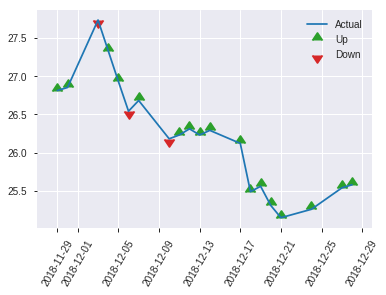


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21913300855181486
RMSE: 0.46811644764077115
LogLoss: 0.628071070260574
Mean Per-Class Error: 0.33512132822477647
AUC: 0.7051085568326948
pr_auc: 0.7215788677815267
Gini: 0.4102171136653896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31197646260261536: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   74   0.6379   (74.0/116.0)
1      9    126  0.0667   (9.0/135.0)
Total  51   200  0.3307   (83.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311976     0.752239  199
max f2                       0.184881     0.861842  219
max f0point5                 0.355068     0.686275  182
max accuracy                 0.355068     0.681275  182
max precision                0.875348     1         0
max recall                   0.0674277    1         249
max specificity              0.875348     1         0
max absolute_mcc             0.355068     0.369922  182
max min_per_class_accuracy   0.486686     0.62963   126
max mean_per_class_accuracy  0.355068     0.664879  182

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 47.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.806863           1.85926   1.85926            1                0.845953  1                           0.845953            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.794556           1.85926   1.85926            1                0.798755  1                           0.822354            0.0222222       0.0444444                  85.9259   85.9259
    3        0.0318725                   0.779544           1.85926   1.85926            1                0.782626  1                           0.812422            0.0148148       0.0592593                  85.9259   85.9259
    4        0.0438247                   0.764366           1.85926   1.85926            1                0.769674  1                           0.800763            0.0222222       0.0814815                  85.9259   85.9259
    5        0.0517928                   0.755499           0.92963   1.71624            0.5              0.759642  0.923077                    0.794437            0.00740741      0.0888889                  -7.03704  71.6239
    6        0.103586                    0.715715           1.4302    1.57322            0.769231         0.729715  0.846154                    0.762076            0.0740741       0.162963                   43.0199   57.3219
    7        0.151394                    0.689906           1.08457   1.41891            0.583333         0.704436  0.763158                    0.743874            0.0518519       0.214815                   8.45679   41.8908
    8        0.203187                    0.668756           1.28718   1.38533            0.692308         0.681697  0.745098                    0.728025            0.0666667       0.281481                   28.7179   38.533
    9        0.302789                    0.617973           1.2643    1.34552            0.68             0.643913  0.723684                    0.700356            0.125926        0.407407                   26.4296   34.5517
    10       0.40239                     0.554423           1.2643    1.32541            0.68             0.582561  0.712871                    0.671199            0.125926        0.533333                   26.4296   32.5413
    11       0.501992                    0.488277           0.892444  1.23951            0.48             0.524554  0.666667                    0.642103            0.0888889       0.622222                   -10.7556  23.9506
    12       0.601594                    0.427274           1.04119   1.20667            0.56             0.459127  0.649007                    0.611809            0.103704        0.725926                   4.11852   20.6672
    13       0.701195                    0.364969           1.18993   1.20429            0.64             0.39447   0.647727                    0.580937            0.118519        0.844444                   18.9926   20.4293
    14       0.800797                    0.310334           0.892444  1.16551            0.48             0.337155  0.626866                    0.550616            0.0888889       0.933333                   -10.7556  16.5506
    15       0.900398                    0.164175           0.371852  1.07771            0.2              0.225257  0.579646                    0.514625            0.037037        0.97037                    -62.8148  7.77122
    16       1                           0.0642711          0.297481  1                  0.16             0.124677  0.537849                    0.475785          

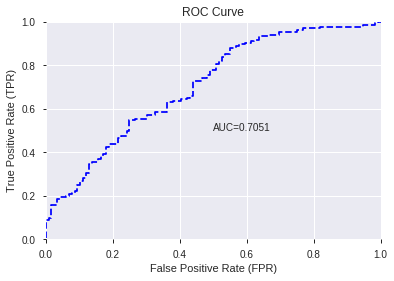

This function is available for GLM models only


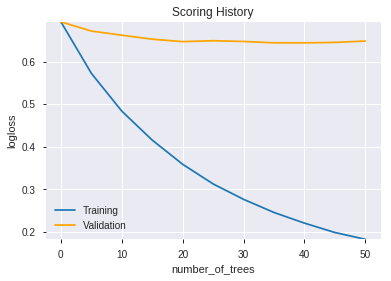

--2019-07-25 02:00:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_020011_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_020011_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_020106_model_6  0.724777  0.627729              0.360313  0.466097  0.217246
1  DeepLearning_grid_1_AutoML_20190725_020106_model_9  0.720434  0.619680              0.387388  0.463642  0.214964
2  DeepLearning_grid_1_AutoML_20190725_020106_model_5  0.710026  0.614981              0.362133  0.462183  0.213613
3  DeepLearning_grid_1_AutoML_20190725_020106_model_3  0.699617  1.026785              0.345562  0.491393  0.241467
4  DeepLearning_grid_1_AutoML_20190725_020106_model_8  0.692848  0.639971              0.370147  0.473511  0.224213
5  DeepLearning_grid_1_AutoML_20190725_020106_model_2  0.674074  0.986700              0.355460  0.493350  0.243394
6  DeepLearning_grid_1_AutoML_20190725_020106_model_4  0.662580  1.051742              0.360983  0.520238  0.270648
7  DeepLearning_grid_1_AutoML_20190725_020106_model_7  0.641124  1.041420              0.408269  0.531795  0.282806
8               DeepLearning_1_AutoML_20190725_020106  0.637612  0.770176              0.396616  0.504492  0.254512
9  DeepLearning_grid_1_AutoML_20190725_020106_model_1  0.610536  1.133333              0.447063  0.540058  0.291663

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.035765
1             CDLHAMMER             0.648964           0.648964    0.023210
2    CDLCLOSINGMARUBOZU             0.637400           0.637400    0.022797
3         CDLHANGINGMAN             0.601122           0.601122    0.021499
4                   SUB             0.600759           0.600759    0.021486
5          weekday_name             0.597033           0.597033    0.021353
6          STOCHF_fastk             0.589501           0.589501    0.021084
7                   DIV             0.579673           0.579673    0.020732
8           CDLLONGLINE             0.578671           0.578671    0.020696
9                TRANGE             0.575585           0.575585    0.020586
10         HT_TRENDMODE             0.573277           0.573277    0.020503
11                 TANH             0.569769           0.569769    0.020378
12              CDLDOJI             0.569407           0.569407    0.020365
13                  SIN             0.567700           0.567700    0.020304
14          STOCH_slowd             0.563872           0.563872    0.020167
15      CDLLADDERBOTTOM             0.558445           0.558445    0.019973
16                  day             0.558385           0.558385    0.019971
17       CDLRICKSHAWMAN             0.558322           0.558322    0.019969
18             WILLR_14             0.552564           0.552564    0.019763
19             CORREL_8             0.550299           0.550299    0.019682
20       STOCHRSI_fastk             0.548011           0.548011    0.019600
21       CDLSPINNINGTOP             0.547381           0.547381    0.019577
22              quarter             0.547341           0.547341    0.019576
23        CDLHIKKAKEMOD             0.546240           0.546240    0.019536
24               ULTOSC             0.545395           0.545395    0.019506
25              BETA_30             0.543502           0.543502    0.019439
26              WILLR_8             0.541405           0.541405    0.019364
27             WILLR_12             0.540845           0.540845    0.019343
28        days_in_month             0.540036           0.540036    0.019315
29           aroonup_20             0.537314           0.537314    0.019217
30               SAREXT             0.535134           0.535134    0.019139
31       STOCHRSI_fastd             0.534193           0.534193    0.019106
32                  COS             0.533860           0.533860    0.019094
33            aroonup_8             0.533094           0.533094    0.019066
34  CDLGAPSIDESIDEWHITE             0.532068           0.532068    0.019030
35    CDLDARKCLOUDCOVER             0.531937           0.531937    0.019025
36                  EXP             0.529874           0.529874    0.018951
37            CDLONNECK             0.528087           0.528087    0.018887
38    CDL3WHITESOLDIERS             0.527672           0.527672    0.018872
39     CDLSTICKSANDWICH             0.526198           0.526198    0.018820
40                ADOSC             0.526056           0.526056    0.018815
41    CDLSTALLEDPATTERN             0.524784           0.524784    0.018769
42       CDLEVENINGSTAR             0.520915           0.520915    0.018631
43            dayofweek             0.520661           0.520661    0.018622
44            CDL2CROWS             0.520583           0.520583    0.018619
45           weekofyear             0.519840           0.519840    0.018592
46              BETA_24             0.517523           0.517523    0.018509
47              weekday             0.515360           0.515360    0.018432
48           aroonup_14             0.510274           0.510274    0.018250
49   CDLEVENINGDOJISTAR             0.503748           0.503748    0.018017

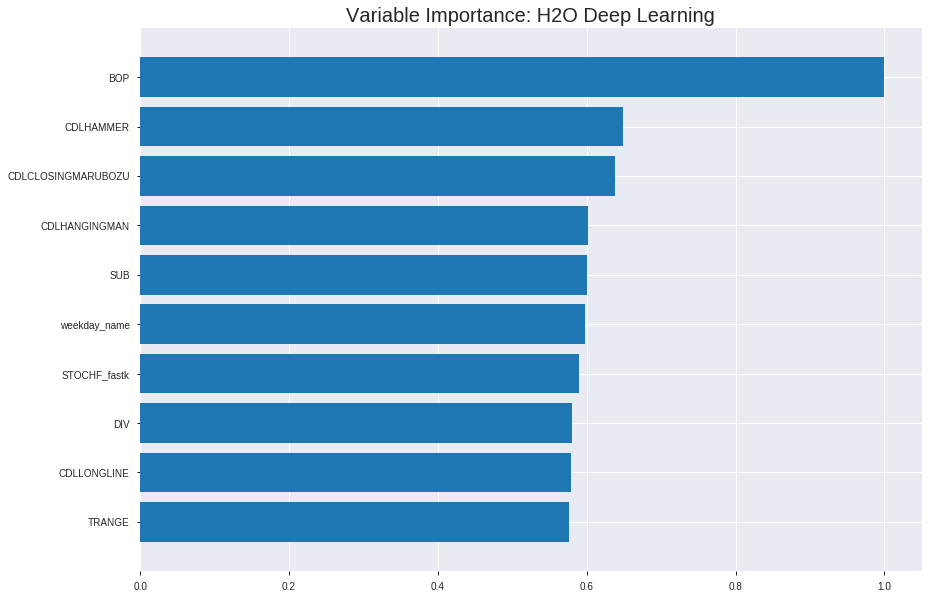

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_020106_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20059474755601162
RMSE: 0.44787804987073393
LogLoss: 0.5836741060077085
Mean Per-Class Error: 0.3070072681077929
AUC: 0.7560036080219917
pr_auc: 0.7510880634645097
Gini: 0.5120072160439835
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4276762805160306: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      452  396   0.467    (396.0/848.0)
1      152  754   0.1678   (152.0/906.0)
Total  604  1150  0.3124   (548.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427676     0.733463  238
max f2                       0.135774     0.855528  352
max f0point5                 0.527107     0.70104   185
max accuracy                 0.478296     0.695553  213
max precision                0.951621     1         0
max recall                   0.0484198    1         384
max specificity              0.951621     1         0
max absolute_mcc             0.473909     0.392001  215
max min_per_class_accuracy   0.524891     0.686534  187
max mean_per_class_accuracy  0.478296     0.692993  213

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 48.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.899086           1.72087   1.72087            0.888889         0.923758   0.888889                    0.923758            0.01766         0.01766                    72.0873   72.0873
    2        0.0205245                   0.867088           1.82843   1.77465            0.944444         0.883126   0.916667                    0.903442            0.0187638       0.0364238                  82.8428   77.465
    3        0.0302166                   0.841789           1.59434   1.71681            0.823529         0.849534   0.886792                    0.886151            0.0154525       0.0518764                  59.4338   71.6815
    4        0.0404789                   0.82012            1.82843   1.74511            0.944444         0.829607   0.901408                    0.871816            0.0187638       0.0706402                  82.8428   74.5111
    5        0.050171                    0.800628           1.8221    1.75998            0.941176         0.811907   0.909091                    0.860242            0.01766         0.0883002                  82.2101   75.9984
    6        0.100342                    0.738687           1.56199   1.66098            0.806818         0.768621   0.857955                    0.814432            0.0783664       0.166667                   56.1986   66.0985
    7        0.149943                    0.698556           1.53543   1.61945            0.793103         0.717457   0.836502                    0.782353            0.0761589       0.242826                   53.5434   61.9453
    8        0.200114                    0.669543           1.42999   1.57195            0.738636         0.683402   0.811966                    0.757545            0.0717439       0.31457                    42.9987   57.1951
    9        0.299886                    0.619376           1.23903   1.46119            0.64             0.64413    0.754753                    0.719811            0.12362         0.43819                    23.9029   46.1188
    10       0.400228                    0.571343           1.27599   1.41476            0.659091         0.59499    0.730769                    0.688517            0.128035        0.566225                   27.5988   41.4756
    11       0.5                         0.52681            1.17265   1.36645            0.605714         0.548027   0.705815                    0.660483            0.116998        0.683223                   17.2652   36.6446
    12       0.599772                    0.469792           1.00671   1.3066             0.52             0.498449   0.674905                    0.633529            0.100442        0.783664                   0.671082  30.6604
    13       0.700114                    0.378735           0.780993  1.23127            0.403409         0.427904   0.635993                    0.604058            0.0783664       0.862031                   -21.9007  23.1272
    14       0.799886                    0.287057           0.652703  1.15911            0.337143         0.338974   0.598717                    0.570994            0.0651214       0.927152                   -34.7297  15.9106
    15       0.899658                    0.144715           0.531012  1.08945            0.274286         0.2178     0.562738                    0.531824            0.0529801       0.980132                   -46.8988  8.94501
    16       1                           0.0070159          0.197998  1                  0.102273         0.0798215  0.516534                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2111249863140522
RMSE: 0.4594833906835504
LogLoss: 0.610695699425028
Mean Per-Class Error: 0.34295364323216804
AUC: 0.724804712511205
pr_auc: 0.7674137807379675
Gini: 0.4496094250224101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29800420484336226: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   150  0.6579   (150.0/228.0)
1      22   252  0.0803   (22.0/274.0)
Total  100  402  0.3426   (172.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298004     0.745562  308
max f2                       0.0765024    0.863492  379
max f0point5                 0.52284      0.688737  197
max accuracy                 0.410347     0.669323  266
max precision                0.953733     1         0
max recall                   0.030929     1         390
max specificity              0.953733     1         0
max absolute_mcc             0.410347     0.331513  266
max min_per_class_accuracy   0.523348     0.653509  196
max mean_per_class_accuracy  0.52284      0.657046  197

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 49.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.910783           1.83212   1.83212            1                0.931105   1                           0.931105            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.869683           1.83212   1.83212            1                0.882866   1                           0.909178            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.85526            1.83212   1.83212            1                0.862437   1                           0.894571            0.0182482       0.0583942                  83.2117   83.2117
    4        0.0418327                   0.837634           1.83212   1.83212            1                0.845462   1                           0.882879            0.0182482       0.0766423                  83.2117   83.2117
    5        0.0517928                   0.817348           1.83212   1.83212            1                0.827051   1                           0.872143            0.0182482       0.0948905                  83.2117   83.2117
    6        0.101594                    0.746109           1.46569   1.6525             0.8              0.772785   0.901961                    0.823438            0.0729927       0.167883                   46.5693   65.2497
    7        0.151394                    0.702634           1.53898   1.61516            0.84             0.726917   0.881579                    0.791688            0.0766423       0.244526                   53.8978   61.5156
    8        0.201195                    0.670541           1.31912   1.54188            0.72             0.684121   0.841584                    0.765062            0.0656934       0.310219                   31.9124   54.188
    9        0.300797                    0.622538           1.13591   1.40745            0.62             0.644856   0.768212                    0.725259            0.113139        0.423358                   13.5912   40.7454
    10       0.400398                    0.580839           1.09927   1.33079            0.6              0.605169   0.726368                    0.695386            0.109489        0.532847                   9.92701   33.0791
    11       0.5                         0.533987           0.989343  1.26277            0.54             0.560239   0.689243                    0.668464            0.0985401       0.631387                   -1.06569  26.2774
    12       0.599602                    0.475626           0.916058  1.20518            0.5              0.50677    0.657807                    0.641605            0.0912409       0.722628                   -8.39416  20.518
    13       0.699203                    0.413283           1.09927   1.19009            0.6              0.449131   0.649573                    0.614187            0.109489        0.832117                   9.92701   19.0093
    14       0.798805                    0.29886            0.842774  1.14679            0.46             0.360097   0.625935                    0.582505            0.0839416       0.916058                   -15.7226  14.6786
    15       0.898406                    0.13467            0.47635   1.07246            0.26             0.229336   0.585366                    0.543351            0.0474453       0.963504                   -52.365   7.24586
    16       1                           0.00481852         0.359239  1                  0.196078         0.0736524  0.545817                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:05:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 02:05:09  2 min 16.872 sec  1055 obs/sec      1.64025   1             2877       0.475749         0.66946             0.0936594      0.718667        0.701836           1.61332          0.358039                         0.499893           0.730546              -0.00803763      0.671557          0.690651             1.52676            0.340637
    2019-07-25 02:05:15  2 min 23.314 sec  2014 obs/sec      9.82497   6             17233      0.447878         0.583674            0.196743       0.756004        0.751088           1.72087          0.312429                         0.459483           0.610696              0.148349         0.724805          0.767414             1.83212            0.342629
    2019-07-25 02:05:22  2 min 30.082 sec  2537 obs/sec      21.2737   13            37314      0.436301         0.557702            0.237732       0.780196        0.780884           1.93598          0.302737                         0.459512           0.614901              0.148242         0.719618          0.758204             1.83212            0.336653
    2019-07-25 02:05:29  2 min 36.805 sec  2756 obs/sec      32.7235   20            57397      0.42878          0.542211            0.263785       0.797355        0.801057           1.93598          0.291904                         0.465849           0.632273              0.124588         0.718354          0.768405             1.83212            0.348606
    2019-07-25 02:05:36  2 min 43.549 sec  2878 obs/sec      44.1853   27            77501      0.41822          0.519996            0.299604       0.81491         0.817261           1.93598          0.279361                         0.468506           0.639784              0.114573         0.709934          0.756411             1.83212            0.338645
    2019-07-25 02:05:42  2 min 50.287 sec  2956 obs/sec      55.7115   34            97718      0.410251         0.503199            0.32604        0.831529        0.828548           1.93598          0.256556                         0.468757           0.64841               0.113623         0.718506          0.761098             1.83212            0.330677
    2019-07-25 02:05:49  2 min 56.819 sec  3023 obs/sec      67.1784   41            117831     0.399186         0.481075            0.361904       0.84973         0.846175           1.93598          0.236602                         0.467256           0.644193              0.119292         0.713384          0.7565               1.83212            0.346614
    2019-07-25 02:05:50  2 min 57.463 sec  3022 obs/sec      67.1784   41            117831     0.447878         0.583674            0.196743       0.756004        0.751088           1.72087          0.312429                         0.459483           0.610696              0.148349         0.724805          0.767414             1.83212            0.342629

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.035765281167172744
CDLHAMMER           0.6489642262458801     0.6489642262458801   0.023210388019120606
CDLCLOSINGMARUBOZU  0.6373997926712036     0.6373997926712036   0.02279678280078321
CDLHANGINGMAN       0.6011216044425964     0.6011216044425964   0.021499283198551458
SUB                 0.6007589101791382     0.6007589101791382   0.02148631133624115
---                 ---                    ---                  ---
weekofyear          0.5198397636413574     0.5198397636413574   0.01859221530850977
BETA_24             0.5175226926803589     0.5175226926803589   0.018509344614105364
weekday             0.5153602361679077     0.5153602361679077   0.018432003748925764
aroonup_14          0.510274350643158      0.510274350643158    0.01825010562314904
CDLEVENINGDOJISTAR  0.5037479996681213     0.5037479996681213   0.0180166888455312


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7462686567164178)

('auc', 0.7247765006385696)

('logloss', 0.6277294268818764)

('mean_per_class_error', 0.320434227330779)

('rmse', 0.4660968324156492)

('mse', 0.21724625718790178)

deeplearning prediction progress: |███████████████████████████████████████| 100%


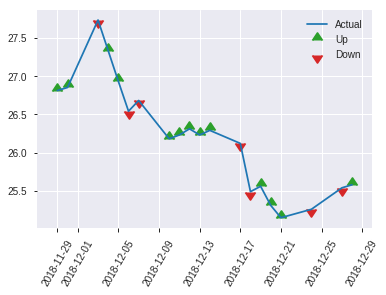


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21724625718790178
RMSE: 0.4660968324156492
LogLoss: 0.6277294268818764
Mean Per-Class Error: 0.320434227330779
AUC: 0.7247765006385696
pr_auc: 0.7196887297656436
Gini: 0.44955300127713915
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27828177400266574: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   75   0.6466   (75.0/116.0)
1      10   125  0.0741   (10.0/135.0)
Total  51   200  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278282     0.746269  199
max f2                       0.041165     0.859873  244
max f0point5                 0.399434     0.699615  160
max accuracy                 0.399434     0.689243  160
max precision                0.932565     1         0
max recall                   0.041165     1         244
max specificity              0.932565     1         0
max absolute_mcc             0.399434     0.373349  160
max min_per_class_accuracy   0.470594     0.666667  127
max mean_per_class_accuracy  0.399434     0.679566  160

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 45.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.849488           1.85926   1.85926            1                0.891705   1                           0.891705            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.808517           0.619753  1.23951            0.333333         0.823212   0.666667                    0.857458            0.00740741      0.0296296                  -38.0247  23.9506
    3        0.0318725                   0.797163           1.85926   1.39444            1                0.802244   0.75                        0.843655            0.0148148       0.0444444                  85.9259   39.4444
    4        0.0438247                   0.771843           1.85926   1.52121            1                0.785868   0.818182                    0.827894            0.0222222       0.0666667                  85.9259   52.1212
    5        0.0517928                   0.764671           1.85926   1.57322            1                0.765795   0.846154                    0.818341            0.0148148       0.0814815                  85.9259   57.3219
    6        0.103586                    0.709687           1.4302    1.50171            0.769231         0.73926    0.807692                    0.7788              0.0740741       0.155556                   43.0199   50.1709
    7        0.151394                    0.67464            1.08457   1.36998            0.583333         0.694218   0.736842                    0.75209             0.0518519       0.207407                   8.45679   36.9981
    8        0.203187                    0.640901           1.71624   1.45824            0.923077         0.655035   0.784314                    0.727351            0.0888889       0.296296                   71.6239   45.8243
    9        0.302789                    0.568253           1.33867   1.41891            0.72             0.605832   0.763158                    0.687377            0.133333        0.42963                    33.8667   41.8908
    10       0.40239                     0.535883           1.18993   1.36223            0.64             0.552435   0.732673                    0.653976            0.118519        0.548148                   18.9926   36.223
    11       0.501992                    0.479447           1.04119   1.29853            0.56             0.510545   0.698413                    0.625517            0.103704        0.651852                   4.11852   29.853
    12       0.601594                    0.417266           0.966815  1.24361            0.52             0.446686   0.668874                    0.595909            0.0962963       0.748148                   -3.31852  24.361
    13       0.701195                    0.354726           0.892444  1.19373            0.48             0.385504   0.642045                    0.566022            0.0888889       0.837037                   -10.7556  19.3729
    14       0.800797                    0.275246           0.892444  1.15626            0.48             0.313332   0.621891                    0.534593            0.0888889       0.925926                   -10.7556  15.6256
    15       0.900398                    0.149563           0.371852  1.06949            0.2              0.211001   0.575221                    0.498797            0.037037        0.962963                   -62.8148  6.94854
    16       1                           0.00191544         0.371852  1                  0.2              0.0747464  0.537849                    0.

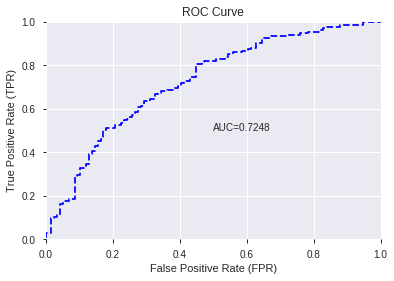

This function is available for GLM models only


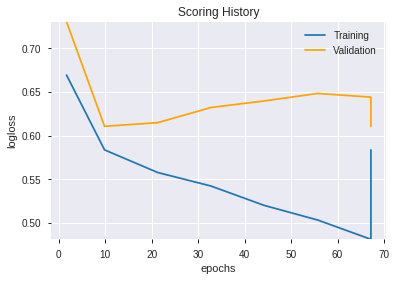

--2019-07-25 02:09:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_020106_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_020106_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'SUB',
 'weekday_name',
 'STOCHF_fastk',
 'DIV',
 'CDLLONGLINE',
 'TRANGE',
 'HT_TRENDMODE',
 'TANH',
 'CDLDOJI',
 'SIN',
 'STOCH_slowd',
 'CDLLADDERBOTTOM',
 'day',
 'CDLRICKSHAWMAN',
 'WILLR_14',
 'CORREL_8',
 'STOCHRSI_fastk',
 'CDLSPINNINGTOP',
 'quarter',
 'CDLHIKKAKEMOD',
 'ULTOSC',
 'BETA_30',
 'WILLR_8',
 'WILLR_12',
 'days_in_month',
 'aroonup_20',
 'SAREXT',
 'STOCHRSI_fastd',
 'COS',
 'aroonup_8',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'EXP',
 'CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'ADOSC',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'dayofweek',
 'CDL2CROWS',
 'weekofyear',
 'BETA_24',
 'weekday',
 'aroonup_14',
 'CDLEVENINGDOJISTAR']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190725_020947_model_1  0.700383  0.637336              0.389815  0.470808  0.22166

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.485164           1.000000    0.121552
1          STOCHF_fastk             0.247674           0.510495    0.062052
2                ULTOSC             0.228107           0.470164    0.057149
3             CDLHAMMER             0.194960           0.401843    0.048845
4           STOCH_slowd             0.174443           0.359554    0.043704
5             aroonup_8             0.153983           0.317383    0.038578
6         CDLHANGINGMAN             0.141519           0.291693    0.035456
7    CDLCLOSINGMARUBOZU             0.136732           0.281827    0.034257
8                   SUB             0.135140           0.278544    0.033858
9               CDLDOJI             0.126156           0.260028    0.031607
10             WILLR_14             0.116002           0.239098    0.029063
11              BETA_24             0.110852           0.228483    0.027773
12           aroonup_20             0.110435           0.227625    0.027668
13                  EXP             0.096382           0.198659    0.024147
14   CDLEVENINGDOJISTAR             0.094905           0.195615    0.023777
15               SAREXT             0.090201           0.185919    0.022599
16              WILLR_8             0.075206           0.155011    0.018842
17    CDLDARKCLOUDCOVER             0.074907           0.154396    0.018767
18       STOCHRSI_fastd             0.074402           0.153355    0.018641
19                  SIN             0.071950           0.148301    0.018026
20             WILLR_12             0.065533           0.135074    0.016418
21                  day             0.063116           0.130092    0.015813
22                 TANH             0.056613           0.116689    0.014184
23           aroonup_14             0.055505           0.114404    0.013906
24       STOCHRSI_fastk             0.053244           0.109744    0.013340
25             CORREL_8             0.047078           0.097036    0.011795
26       CDLEVENINGSTAR             0.045270           0.093309    0.011342
27     CDLSTICKSANDWICH             0.043073           0.088781    0.010791
28    CDL3WHITESOLDIERS             0.042045           0.086662    0.010534
29         HT_TRENDMODE             0.041952           0.086469    0.010510
30              BETA_30             0.041518           0.085575    0.010402
31           weekofyear             0.040676           0.083840    0.010191
32        CDLHIKKAKEMOD             0.038990           0.080365    0.009769
33  CDLGAPSIDESIDEWHITE             0.036688           0.075619    0.009192
34            dayofweek             0.036225           0.074666    0.009076
35              weekday             0.036007           0.074217    0.009021
36               TRANGE             0.035394           0.072953    0.008868
37                  COS             0.034160           0.070408    0.008558
38      CDLLADDERBOTTOM             0.034115           0.070317    0.008547
39            CDLONNECK             0.033951           0.069978    0.008506
40    CDLSTALLEDPATTERN             0.033278           0.068591    0.008337
41       CDLRICKSHAWMAN             0.031670           0.065276    0.007934
42          CDLLONGLINE             0.025538           0.052638    0.006398
43        days_in_month             0.023373           0.048176    0.005856
44         weekday_name             0.016338           0.033675    0.004093
45              quarter             0.013736           0.028312    0.003441
46            CDL2CROWS             0.009627           0.019842    0.002412
47                  DIV             0.006946           0.014316    0.001740
48                ADOSC             0.005774           0.011901    0.001447
49       CDLSPINNINGTOP             0.004869           0.010036    0.001220

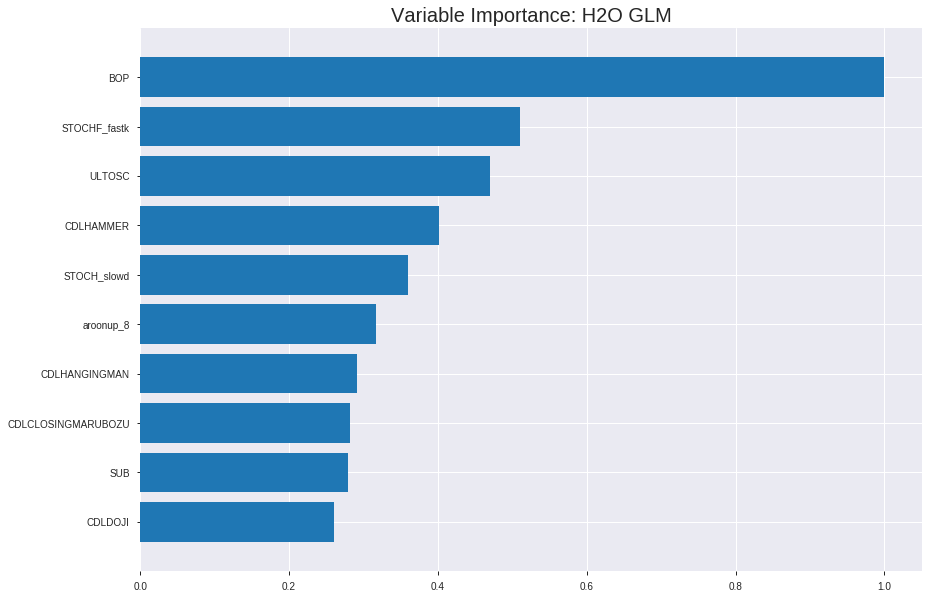

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_020947_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20131428728956435
RMSE: 0.4486806072135995
LogLoss: 0.5875366727597513
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2429.642057792962
Residual deviance: 2061.0786480412075
AIC: 2163.0786480412075
AUC: 0.7515293744012661
pr_auc: 0.7455610345522351
Gini: 0.5030587488025322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37899814830579365: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  459   0.5413   (459.0/848.0)
1      103  803   0.1137   (103.0/906.0)
Total  492  1262  0.3204   (562.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378998     0.740775  266
max f2                       0.257603     0.852018  322
max f0point5                 0.520767     0.700509  197
max accuracy                 0.520767     0.693843  197
max precision                0.967024     1         0
max recall                   0.113027     1         384
max specificity              0.967024     1         0
max absolute_mcc             0.435802     0.389809  237
max min_per_class_accuracy   0.550538     0.681604  182
max mean_per_class_accuracy  0.520767     0.69262   197

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.885034           1.93598   1.93598            1                0.910037  1                           0.910037            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.864968           1.50576   1.72087            0.777778         0.874768  0.888889                    0.892402            0.0154525       0.0353201                  50.5764   72.0873
    3        0.0302166                   0.848065           1.8221    1.75334            0.941176         0.854594  0.90566                     0.880275            0.01766         0.0529801                  82.2101   75.3342
    4        0.0404789                   0.831517           1.82843   1.77238            0.944444         0.840042  0.915493                    0.870075            0.0187638       0.0717439                  82.8428   77.2378
    5        0.050171                    0.816139           1.8221    1.78198            0.941176         0.824703  0.920455                    0.86131             0.01766         0.089404                   82.2101   78.1984
    6        0.100342                    0.765191           1.51799   1.64998            0.784091         0.78606   0.852273                    0.823685            0.0761589       0.165563                   51.7986   64.9985
    7        0.149943                    0.732953           1.46868   1.59001            0.758621         0.74733   0.821293                    0.798427            0.0728477       0.238411                   46.8676   59.0008
    8        0.200114                    0.703153           1.31999   1.52231            0.681818         0.71835   0.786325                    0.778351            0.0662252       0.304636                   31.9988   52.2311
    9        0.299886                    0.65187            1.34966   1.46487            0.697143         0.678475  0.756654                    0.745122            0.134658        0.439294                   34.9656   46.4869
    10       0.400228                    0.605928           1.19899   1.39821            0.619318         0.628766  0.722222                    0.71595             0.120309        0.559603                   19.8989   39.8209
    11       0.5                         0.553531           1.17265   1.3532             0.605714         0.581435  0.698974                    0.689108            0.116998        0.6766                     17.2652   35.3201
    12       0.599772                    0.473484           1.0399    1.30108            0.537143         0.514783  0.672053                    0.660109            0.103753        0.780353                   3.98991   30.1083
    13       0.700114                    0.392329           0.879992  1.24073            0.454545         0.432653  0.640879                    0.62751             0.0883002       0.868653                   -12.0008  24.0731
    14       0.799886                    0.312863           0.608452  1.16187            0.314286         0.354459  0.600143                    0.593451            0.0607064       0.92936                    -39.1548  16.1865
    15       0.899658                    0.213438           0.420385  1.07964            0.217143         0.263862  0.557668                    0.5569              0.0419426       0.971302                   -57.9615  7.96353
    16       1                           0.00932691         0.285997  1                  0.147727         0.154613  0.516534                    0.516534         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2090945917846186
RMSE: 0.457268621036496
LogLoss: 0.603523612799953
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 693.4256799911966
Residual deviance: 605.9377072511527
AIC: 707.9377072511527
AUC: 0.7301030861826099
pr_auc: 0.7658401509384737
Gini: 0.46020617236521977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3707853199063219: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   138  0.6053   (138.0/228.0)
1      29   245  0.1058   (29.0/274.0)
Total  119  383  0.3327   (167.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370785     0.745814  294
max f2                       0.205517     0.86483   365
max f0point5                 0.667334     0.705128  111
max accuracy                 0.410552     0.671315  269
max precision                0.902538     1         0
max recall                   0.102353     1         392
max specificity              0.902538     1         0
max absolute_mcc             0.667334     0.363934  111
max min_per_class_accuracy   0.564597     0.631387  194
max mean_per_class_accuracy  0.667334     0.665978  111

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.866156           1.83212   1.83212            1                0.888018  1                           0.888018            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.860224           1.46569   1.66556            0.8              0.861262  0.909091                    0.875856            0.0145985       0.0364964                  46.5693   66.5561
    3        0.0318725                   0.839934           1.46569   1.6031             0.8              0.846078  0.875                       0.866551            0.0145985       0.0510949                  46.5693   60.3102
    4        0.0418327                   0.83469            1.83212   1.65763            1                0.837221  0.904762                    0.859567            0.0182482       0.0693431                  83.2117   65.7629
    5        0.0517928                   0.824736           1.83212   1.69118            1                0.829494  0.923077                    0.853784            0.0182482       0.0875912                  83.2117   69.1185
    6        0.101594                    0.774043           1.61226   1.6525             0.88             0.794884  0.901961                    0.824912            0.080292        0.167883                   61.2263   65.2497
    7        0.151394                    0.732081           1.61226   1.63926            0.88             0.751244  0.894737                    0.800679            0.080292        0.248175                   61.2263   63.9262
    8        0.201195                    0.706987           1.39241   1.57816            0.76             0.716327  0.861386                    0.7798              0.0693431       0.317518                   39.2409   57.816
    9        0.300797                    0.66159            1.28248   1.48025            0.7              0.683445  0.807947                    0.747894            0.127737        0.445255                   28.2482   48.0253
    10       0.400398                    0.611422           0.916058  1.33991            0.5              0.636593  0.731343                    0.720207            0.0912409       0.536496                   -8.39416  33.9906
    11       0.5                         0.571226           0.916058  1.25547            0.5              0.591464  0.685259                    0.694561            0.0912409       0.627737                   -8.39416  25.5474
    12       0.599602                    0.493371           0.916058  1.19909            0.5              0.537581  0.654485                    0.668485            0.0912409       0.718978                   -8.39416  19.9093
    13       0.699203                    0.409345           1.2092    1.20053            0.66             0.450083  0.655271                    0.637374            0.120438        0.839416                   20.9197   20.0532
    14       0.798805                    0.333647           0.659562  1.13308            0.36             0.377236  0.618454                    0.604938            0.0656934       0.905109                   -34.0438  13.308
    15       0.898406                    0.234567           0.62292   1.07652            0.34             0.290397  0.587583                    0.570066            0.0620438       0.967153                   -37.708   7.6521
    16       1                           0.0587503          0.323315  1                  0.176471         0.162834  0.545817                    0.528694            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 02:09:47  0.000 sec   2            18        50            1.36843           1.36598
    2019-07-25 02:09:47  0.024 sec   4            11        51            1.35989           1.35817
    2019-07-25 02:09:47  0.043 sec   6            7         51            1.34811           1.34741
    2019-07-25 02:09:47  0.060 sec   8            4.4       51            1.33287           1.33351
    2019-07-25 02:09:47  0.078 sec   10           2.7       51            1.31443           1.31673
    2019-07-25 02:09:47  0.096 sec   12           1.7       51            1.29365           1.2979
    2019-07-25 02:09:47  0.114 sec   14           1         51            1.27186           1.27826
    2019-07-25 02:09:47  0.132 sec   16           0.65      51            1.25061           1.25933
    2019-07-25 02:09:47  0.154 sec   18           0.4       51            1.2313            1.24247
    2019-07-25 02:09:47  0.172 sec   20           0.25      51            1.21492           1.22877
    2019-07-25 02:09:47  0.189 sec   22           0.16      51            1.2018            1.21875
    2019-07-25 02:09:47  0.206 sec   24           0.096     51            1.19177           1.2123
    2019-07-25 02:09:47  0.223 sec   26           0.06      51            1.18435           1.20881
    2019-07-25 02:09:47  0.241 sec   28           0.037     51            1.17897           1.20736
    2019-07-25 02:09:47  0.259 sec   30           0.023     51            1.17507           1.20705
    2019-07-25 02:09:47  0.272 sec   32           0.014     51            1.17224           1.20721
    2019-07-25 02:09:47  0.287 sec   34           0.0089    51            1.17018           1.20757
    2019-07-25 02:09:47  0.304 sec   36           0.0055    51            1.16875           1.20799
    2019-07-25 02:09:47  0.322 sec   38           0.0034    51            1.16782           1.20847
    2019-07-25 02:09:47  0.340 sec   40           0.0021    51            1.16728           1.20896

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772908366533864)

('F1', 0.7422096317280452)

('auc', 0.7003831417624521)

('logloss', 0.637336220960133)

('mean_per_class_error', 0.3285121328224776)

('rmse', 0.47080767946387614)

('mse', 0.22165987104215992)

glm prediction progress: |████████████████████████████████████████████████| 100%


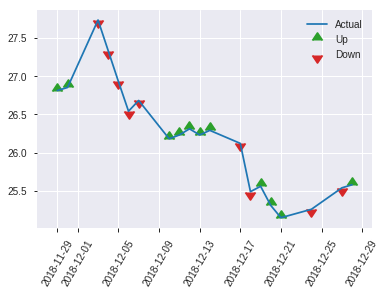


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22165987104215992
RMSE: 0.47080767946387614
LogLoss: 0.637336220960133
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.9774746766028
Residual deviance: 319.94278292198675
AIC: 421.94278292198675
AUC: 0.7003831417624521
pr_auc: 0.6756921308102863
Gini: 0.4007662835249042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607499156490512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   87   0.75     (87.0/116.0)
1      4    131  0.0296   (4.0/135.0)
Total  33   218  0.3625   (91.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.26075      0.74221   217
max f2                       0.26075      0.864116  217
max f0point5                 0.470675     0.694635  147
max accuracy                 0.470675     0.677291  147
max precision                0.914953     1         0
max recall                   0.0818126    1         249
max specificity              0.914953     1         0
max absolute_mcc             0.470675     0.347624  147
max min_per_class_accuracy   0.502481     0.655172  128
max mean_per_class_accuracy  0.470675     0.671488  147

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892346           1.23951   1.23951            0.666667         0.907112  0.666667                    0.907112            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.866781           1.23951   1.23951            0.666667         0.877059  0.666667                    0.892085            0.0148148       0.0296296                  23.9506   23.9506
    3        0.0318725                   0.846649           0.92963   1.16204            0.5              0.854925  0.625                       0.882795            0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.832145           1.23951   1.18316            0.666667         0.83666   0.636364                    0.870213            0.0148148       0.0518519                  23.9506   18.3165
    5        0.0517928                   0.799807           1.85926   1.28718            1                0.805764  0.692308                    0.860298            0.0148148       0.0666667                  85.9259   28.7179
    6        0.103586                    0.738989           1.28718   1.28718            0.692308         0.767829  0.692308                    0.814063            0.0666667       0.133333                   28.7179   28.7179
    7        0.151394                    0.697698           1.70432   1.41891            0.916667         0.718762  0.763158                    0.783968            0.0814815       0.214815                   70.4321   41.8908
    8        0.203187                    0.663447           1.14416   1.34887            0.615385         0.679115  0.72549                     0.757241            0.0592593       0.274074                   14.416    34.8874
    9        0.302789                    0.62371            1.41304   1.36998            0.76             0.643314  0.736842                    0.719765            0.140741        0.414815                   41.3037   36.9981
    10       0.40239                     0.547707           1.2643    1.34382            0.68             0.585155  0.722772                    0.686446            0.125926        0.540741                   26.4296   34.3821
    11       0.501992                    0.510156           1.04119   1.28377            0.56             0.529734  0.690476                    0.655352            0.103704        0.644444                   4.11852   28.3774
    12       0.601594                    0.453599           1.04119   1.24361            0.56             0.48373   0.668874                    0.626938            0.103704        0.748148                   4.11852   24.361
    13       0.701195                    0.368303           0.818074  1.18316            0.44             0.402931  0.636364                    0.595119            0.0814815       0.82963                    -18.1926  18.3165
    14       0.800797                    0.304959           0.594963  1.11001            0.32             0.333957  0.597015                    0.562636            0.0592593       0.888889                   -40.5037  11.0006
    15       0.900398                    0.212581           0.818074  1.07771            0.44             0.269998  0.579646                    0.530264            0.0814815       0.97037                    -18.1926  7.77122
    16       1                           0.051474           0.297481  1                  0.16             0.15085   0.537849                    0.492474          

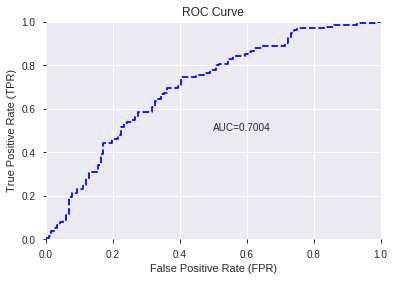

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


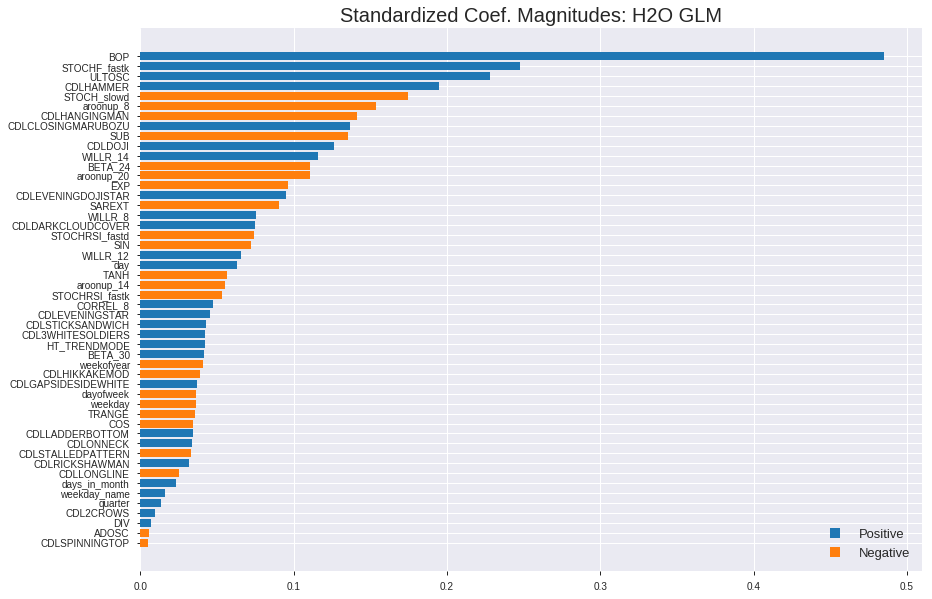

'log_likelihood'
--2019-07-25 02:09:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_020947_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_020947_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLHAMMER',
 'STOCH_slowd',
 'aroonup_8',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLDOJI',
 'WILLR_14',
 'BETA_24',
 'aroonup_20',
 'EXP',
 'CDLEVENINGDOJISTAR',
 'SAREXT',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastd',
 'SIN',
 'WILLR_12',
 'day',
 'TANH',
 'aroonup_14',
 'STOCHRSI_fastk',
 'CORREL_8',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH',
 'CDL3WHITESOLDIERS',
 'HT_TRENDMODE',
 'BETA_30',
 'weekofyear',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'dayofweek',
 'weekday',
 'TRANGE',
 'COS',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLSTALLEDPATTERN',
 'CDLRICKSHAWMAN',
 'CDLLONGLINE',
 'days_in_month',
 'weekday_name',
 'quarter',
 'CDL2CROWS',
 'DIV',
 'ADOSC',
 'CDLSPINNINGTOP']

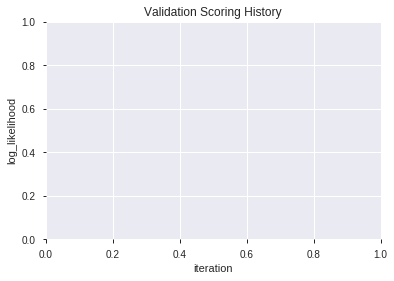

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_021001_model_2  0.712197  0.626137              0.330204  0.466482  0.217605
1  XGBoost_grid_1_AutoML_20190725_021001_model_6  0.703576  0.626478              0.336941  0.466578  0.217695
2  XGBoost_grid_1_AutoML_20190725_021001_model_4  0.702299  0.624901              0.336335  0.465879  0.217043
3               XGBoost_3_AutoML_20190725_021001  0.697637  0.631200              0.316124  0.468516  0.219507
4               XGBoost_2_AutoML_20190725_021001  0.694189  0.636945              0.318487  0.471045  0.221884
5  XGBoost_grid_1_AutoML_20190725_021001_model_1  0.690996  0.633772              0.357280  0.470552  0.221420
6  XGBoost_grid_1_AutoML_20190725_021001_model_3  0.685185  0.654876              0.321648  0.477343  0.227857
7               XGBoost_1_AutoML_20190725_021001  0.684291  0.645284              0.365900  0.474608  0.225252
8  XGBoost_grid_1_AutoML_20190725_021001_model_7  0.678799  0.653870              0.339496  0.478069  0.228550
9  XGBoost_grid_1_AutoML_20190725_021001_model_5  0.672031  0.658495              0.377554  0.481471  0.231814

variable  relative_importance  scaled_importance  percentage
0                  BOP          2152.103027           1.000000    0.300868
1         STOCHF_fastk           538.681824           0.250305    0.075309
2              BETA_30           279.281250           0.129771    0.039044
3                  SUB           277.614410           0.128997    0.038811
4                  EXP           261.503265           0.121511    0.036559
5                  DIV           250.024231           0.116177    0.034954
6       STOCHRSI_fastd           242.833496           0.112835    0.033949
7                ADOSC           229.101776           0.106455    0.032029
8                  COS           218.199417           0.101389    0.030505
9               SAREXT           216.157394           0.100440    0.030219
10            CORREL_8           209.156113           0.097187    0.029240
11                 SIN           207.497604           0.096416    0.029009
12         STOCH_slowd           204.492523           0.095020    0.028588
13             BETA_24           187.631363           0.087185    0.026231
14              ULTOSC           166.632126           0.077428    0.023295
15      STOCHRSI_fastk           160.156570           0.074419    0.022390
16          weekofyear           158.191772           0.073506    0.022115
17                 day           152.520462           0.070870    0.021323
18            WILLR_12           126.301720           0.058688    0.017657
19              TRANGE           125.047501           0.058105    0.017482
20           dayofweek           115.487152           0.053662    0.016145
21             WILLR_8           110.731506           0.051453    0.015480
22            WILLR_14           100.549835           0.046722    0.014057
23           CDLHAMMER            89.768753           0.041712    0.012550
24           aroonup_8            77.342049           0.035938    0.010813
25          aroonup_14            70.399582           0.032712    0.009842
26          aroonup_20            60.684807           0.028198    0.008484
27        weekday_name            33.720036           0.015668    0.004714
28      CDLSPINNINGTOP            28.328173           0.013163    0.003960
29             CDLDOJI            26.622087           0.012370    0.003722
30      CDLRICKSHAWMAN            17.238249           0.008010    0.002410
31             quarter            12.908432           0.005998    0.001805
32       days_in_month            12.554960           0.005834    0.001755
33         CDLLONGLINE             9.095932           0.004227    0.001272
34   CDLDARKCLOUDCOVER             8.116921           0.003772    0.001135
35  CDLCLOSINGMARUBOZU             7.643034           0.003551    0.001069
36             weekday             7.436315           0.003455    0.001040
37        HT_TRENDMODE             1.235263           0.000574    0.000173

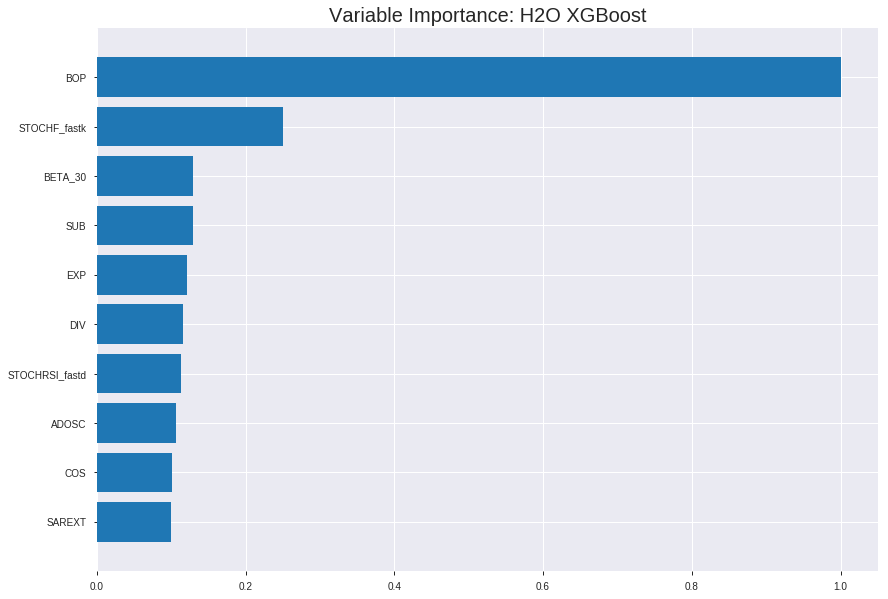

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_021001_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16674454358268895
RMSE: 0.40834365867818856
LogLoss: 0.5129031736595431
Mean Per-Class Error: 0.21293186929901287
AUC: 0.8693543306676663
pr_auc: 0.8804863368325632
Gini: 0.7387086613353326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4842221438884735: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      561  287   0.3384   (287.0/848.0)
1      119  787   0.1313   (119.0/906.0)
Total  680  1074  0.2315   (406.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484222     0.794949  215
max f2                       0.276929     0.878472  323
max f0point5                 0.593404     0.809536  149
max accuracy                 0.559149     0.786773  171
max precision                0.843765     1         0
max recall                   0.172341     1         379
max specificity              0.843765     1         0
max absolute_mcc             0.559149     0.573823  171
max min_per_class_accuracy   0.554891     0.784768  174
max mean_per_class_accuracy  0.559149     0.787068  171

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.812134           1.93598    1.93598            1                0.823153  1                           0.823153            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.788102           1.82843    1.88221            0.944444         0.795211  0.972222                    0.809182            0.0187638       0.0386313                  82.8428   88.2205
    3        0.0302166                   0.779402           1.93598    1.89945            1                0.784163  0.981132                    0.801157            0.0187638       0.0573951                  93.5982   89.9454
    4        0.0404789                   0.772097           1.93598    1.90871            1                0.774602  0.985915                    0.794425            0.0198675       0.0772627                  93.5982   90.8715
    5        0.050171                    0.765424           1.93598    1.91398            1                0.768931  0.988636                    0.7895              0.0187638       0.0960265                  93.5982   91.3983
    6        0.100342                    0.736551           1.93598    1.92498            1                0.749859  0.994318                    0.76968             0.0971302       0.193157                   93.5982   92.4982
    7        0.149943                    0.712184           1.86922    1.90654            0.965517         0.724708  0.984791                    0.754803            0.0927152       0.285872                   86.9224   90.6538
    8        0.200114                    0.690659           1.60599    1.83119            0.829545         0.70188   0.945869                    0.741535            0.080574        0.366446                   60.5985   83.1186
    9        0.299886                    0.648142           1.62623    1.763              0.84             0.668528  0.910646                    0.717245            0.162252        0.528698                   62.6225   76.2995
    10       0.400228                    0.605786           1.29799    1.64641            0.670455         0.626906  0.850427                    0.694596            0.130243        0.65894                    29.7988   64.6412
    11       0.5                         0.558566           1.18371    1.55408            0.611429         0.582749  0.802737                    0.672278            0.118102        0.777042                   18.3715   55.4084
    12       0.599772                    0.49475            0.818644   1.43174            0.422857         0.527668  0.739544                    0.648222            0.0816777       0.85872                    -18.1356  43.1744
    13       0.700114                    0.408469           0.604994   1.31325            0.3125           0.452387  0.678339                    0.620154            0.0607064       0.919426                   -39.5006  31.3252
    14       0.799886                    0.305409           0.542075   1.21706            0.28             0.358657  0.628653                    0.587537            0.0540839       0.97351                    -45.7925  21.7061
    15       0.899658                    0.217356           0.232318   1.10785            0.12             0.258895  0.572243                    0.551091            0.0231788       0.996689                   -76.7682  10.7853
    16       1                           0.125604           0.0329997  1                  0.0170455        0.178193  0.516534                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21710307919013366
RMSE: 0.46594321455530785
LogLoss: 0.6237838072844152
Mean Per-Class Error: 0.33189268792419013
AUC: 0.7084053656037904
pr_auc: 0.7225939834034724
Gini: 0.41681073120758083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3538801968097687: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   147  0.6447   (147.0/228.0)
1      31   243  0.1131   (31.0/274.0)
Total  112  390  0.3546   (178.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35388      0.731928  300
max f2                       0.204421     0.86471   369
max f0point5                 0.629637     0.703883  133
max accuracy                 0.49067      0.659363  239
max precision                0.81964      1         0
max recall                   0.15147      1         394
max specificity              0.81964      1         0
max absolute_mcc             0.629637     0.345507  133
max min_per_class_accuracy   0.579464     0.649123  183
max mean_per_class_accuracy  0.629637     0.668107  133

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.776675           1.52676   1.52676            0.833333         0.791897  0.833333                    0.791897            0.0182482       0.0182482                  52.6764   52.6764
    2        0.0219124                   0.769132           1.83212   1.66556            1                0.770363  0.909091                    0.782109            0.0182482       0.0364964                  83.2117   66.5561
    3        0.0318725                   0.756583           1.83212   1.71761            1                0.759018  0.9375                      0.774893            0.0182482       0.0547445                  83.2117   71.7609
    4        0.0418327                   0.750203           1.46569   1.65763            0.8              0.753175  0.904762                    0.769722            0.0145985       0.0693431                  46.5693   65.7629
    5        0.0517928                   0.745964           1.09927   1.55025            0.6              0.747033  0.846154                    0.765359            0.0109489       0.080292                   9.92701   55.0253
    6        0.101594                    0.717531           1.39241   1.47288            0.76             0.731355  0.803922                    0.74869             0.0693431       0.149635                   39.2409   47.2878
    7        0.151394                    0.697328           1.09927   1.34998            0.6              0.706914  0.736842                    0.734948            0.0547445       0.20438                    9.92701   34.9981
    8        0.201195                    0.679906           1.53898   1.39676            0.84             0.688013  0.762376                    0.72333             0.0766423       0.281022                   53.8978   39.6762
    9        0.300797                    0.65042            1.46569   1.41959            0.8              0.666368  0.774834                    0.704469            0.145985        0.427007                   46.5693   41.9587
    10       0.400398                    0.622726           1.24584   1.37637            0.68             0.636466  0.751244                    0.687553            0.124088        0.551095                   24.5839   37.6366
    11       0.5                         0.584687           0.806131  1.26277            0.44             0.609195  0.689243                    0.671944            0.080292        0.631387                   -19.3869  26.2774
    12       0.599602                    0.520702           1.02599   1.22344            0.56             0.556647  0.667774                    0.652791            0.10219         0.733577                   2.59854   22.344
    13       0.699203                    0.436747           0.842774  1.16921            0.46             0.480367  0.638177                    0.628229            0.0839416       0.817518                   -15.7226  16.9214
    14       0.798805                    0.33998            0.806131  1.12394            0.44             0.379642  0.613466                    0.597234            0.080292        0.89781                    -19.3869  12.3942
    15       0.898406                    0.246432           0.62292   1.0684             0.34             0.294819  0.583149                    0.563706            0.0620438       0.959854                   -37.708   6.83963
    16       1                           0.138546           0.395162  1                  0.215686         0.190624  0.545817                    0.525804          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:10:05  0.539 sec   0                  0.5              0.693147            0.5             0                  1                0.483466                         0.5                0.693147              0.5               0                    1                  0.454183
    2019-07-25 02:10:05  0.604 sec   5                  0.4812           0.656132            0.794738        0.655021           1.60699          0.27081                          0.488722           0.670778              0.690277          0.642533             1.42498            0.350598
    2019-07-25 02:10:05  0.648 sec   10                 0.466952         0.628542            0.805296        0.7874             1.83409          0.263968                         0.481609           0.6567                0.68762           0.702657             1.52676            0.364542
    2019-07-25 02:10:05  0.696 sec   15                 0.455428         0.606236            0.813977        0.803254           1.82843          0.27423                          0.475985           0.645473              0.695744          0.708345             1.52676            0.35259
    2019-07-25 02:10:05  0.754 sec   20                 0.446024         0.587907            0.822848        0.822501           1.93598          0.259977                         0.472373           0.638094              0.70069           0.715952             1.52676            0.36255
    2019-07-25 02:10:05  0.803 sec   25                 0.438502         0.573029            0.830135        0.835221           1.93598          0.266249                         0.471208           0.635518              0.699826          0.719178             1.52676            0.360558
    2019-07-25 02:10:05  0.853 sec   30                 0.431922         0.559915            0.837275        0.844684           1.93598          0.253136                         0.469696           0.632305              0.701818          0.714337             1.52676            0.368526
    2019-07-25 02:10:05  0.906 sec   35                 0.426581         0.549198            0.843242        0.851389           1.93598          0.257127                         0.46889            0.630464              0.702699          0.717095             1.52676            0.366534
    2019-07-25 02:10:05  0.979 sec   40                 0.421527         0.539074            0.849955        0.859707           1.93598          0.250855                         0.46777            0.627971              0.705876          0.723691             1.52676            0.370518
    2019-07-25 02:10:05  1.037 sec   45                 0.417102         0.530297            0.856554        0.866838           1.93598          0.244584                         0.466982           0.626213              0.707093          0.722429             1.52676            0.37251
    2019-07-25 02:10:05  1.093 sec   50                 0.412876         0.521889            0.862963        0.873374           1.93598          0.22577                          0.466677           0.62544               0.705532          0.720691             1.52676            0.354582
    2019-07-25 02:10:05  1.152 sec   55                 0.408344         0.512903            0.869354        0.880486           1.93598          0.231471                         0.465943           0.623784              0.708405          0.72

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2152.10302734375       1.0                    0.3008675738312025
STOCHF_fastk        538.6818237304688      0.2503048492038697     0.07530861269815327
BETA_30             279.28125              0.12977131970522113    0.0390439821125832
SUB                 277.6144104003906      0.12899680306803823    0.03881095517106208
EXP                 261.5032653808594      0.12151056992081918    0.036558590366923556
---                 ---                    ---                    ---
CDLLONGLINE         9.095932006835938      0.004226531858032216   0.0012716263858464374
CDLDARKCLOUDCOVER   8.116921424865723      0.003771623069033129   0.0011347590821857915
CDLCLOSINGMARUBOZU  7.6430344581604        0.0035514259127240183  0.0010685088980025392
weekday             7.436314582824707      0.0034553710897396194  0.0010396091164564375
HT_TRENDMODE        1.2352628707885742     0.0005739794308608019  0.00017269179879210388


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7492063492063492)

('auc', 0.7121966794380588)

('logloss', 0.6261374633489114)

('mean_per_class_error', 0.3295977011494253)

('rmse', 0.4664818902205955)

('mse', 0.21760535390377972)

xgboost prediction progress: |████████████████████████████████████████████| 100%


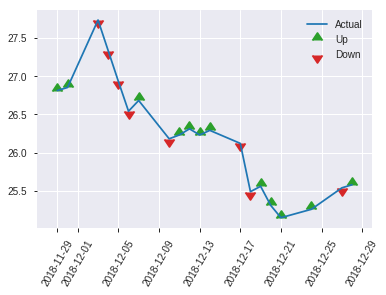


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21760535390377972
RMSE: 0.4664818902205955
LogLoss: 0.6261374633489114
Mean Per-Class Error: 0.3295977011494253
AUC: 0.7121966794380588
pr_auc: 0.7105485737853288
Gini: 0.4243933588761175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3690261244773865: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   62   0.5345   (62.0/116.0)
1      17   118  0.1259   (17.0/135.0)
Total  71   180  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369026     0.749206  179
max f2                       0.138755     0.85335   250
max f0point5                 0.372379     0.690673  177
max accuracy                 0.372379     0.685259  177
max precision                0.790888     1         0
max recall                   0.138755     1         250
max specificity              0.790888     1         0
max absolute_mcc             0.369026     0.375913  179
max min_per_class_accuracy   0.51423      0.637931  128
max mean_per_class_accuracy  0.372379     0.670402  177

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 47.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.77208            1.23951   1.23951            0.666667         0.789784  0.666667                    0.789784            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.727415           1.85926   1.54938            1                0.737326  0.833333                    0.763555            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.724187           0.92963   1.39444            0.5              0.725351  0.75                        0.754004            0.00740741      0.0444444                  -7.03704  39.4444
    4        0.0438247                   0.716276           1.85926   1.52121            1                0.720164  0.818182                    0.744775            0.0222222       0.0666667                  85.9259   52.1212
    5        0.0517928                   0.705773           1.85926   1.57322            1                0.710548  0.846154                    0.739509            0.0148148       0.0814815                  85.9259   57.3219
    6        0.103586                    0.677981           1.4302    1.50171            0.769231         0.69154   0.807692                    0.715525            0.0740741       0.155556                   43.0199   50.1709
    7        0.151394                    0.663544           1.39444   1.46784            0.75             0.671502  0.789474                    0.701623            0.0666667       0.222222                   39.4444   46.7836
    8        0.203187                    0.63434            1.14416   1.38533            0.615385         0.64733   0.745098                    0.687783            0.0592593       0.281481                   14.416    38.533
    9        0.302789                    0.596766           1.33867   1.36998            0.72             0.616378  0.736842                    0.664295            0.133333        0.414815                   33.8667   36.9981
    10       0.40239                     0.557471           1.18993   1.32541            0.64             0.579579  0.712871                    0.643325            0.118519        0.533333                   18.9926   32.5413
    11       0.501992                    0.517956           0.966815  1.25426            0.52             0.53544   0.674603                    0.62192             0.0962963       0.62963                    -3.31852  25.4262
    12       0.601594                    0.450304           1.18993   1.24361            0.64             0.49135   0.668874                    0.600302            0.118519        0.748148                   18.9926   24.361
    13       0.701195                    0.378658           1.04119   1.21486            0.56             0.414997  0.653409                    0.57398             0.103704        0.851852                   4.11852   21.4857
    14       0.800797                    0.299394           0.594963  1.13776            0.32             0.336938  0.61194                     0.544497            0.0592593       0.911111                   -40.5037  13.7756
    15       0.900398                    0.214946           0.520593  1.06949            0.28             0.251207  0.575221                    0.512054            0.0518519       0.962963                   -47.9407  6.94854
    16       1                           0.138755           0.371852  1                  0.2              0.176991  0.537849                    0.478681           

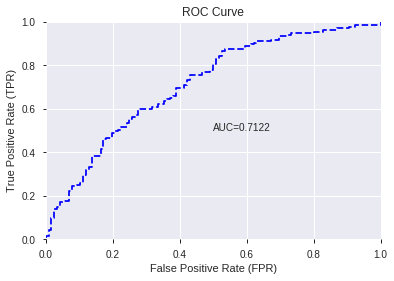

This function is available for GLM models only


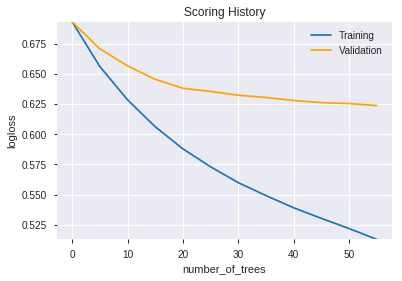

--2019-07-25 02:10:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_021001_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_021001_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'BETA_30',
 'SUB',
 'EXP',
 'DIV',
 'STOCHRSI_fastd',
 'ADOSC',
 'COS',
 'SAREXT',
 'CORREL_8',
 'SIN',
 'STOCH_slowd',
 'BETA_24',
 'ULTOSC',
 'STOCHRSI_fastk',
 'weekofyear',
 'day',
 'WILLR_12',
 'TRANGE',
 'dayofweek',
 'WILLR_8',
 'WILLR_14',
 'CDLHAMMER',
 'aroonup_8',
 'aroonup_14',
 'aroonup_20',
 'weekday_name',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'quarter',
 'days_in_month',
 'CDLLONGLINE',
 'CDLDARKCLOUDCOVER',
 'CDLCLOSINGMARUBOZU',
 'weekday',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [929 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


49

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'CDLHANGINGMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_021024_model_8  0.735632  0.613093              0.326437  0.457876  0.209650
1  DeepLearning_grid_1_AutoML_20190725_021024_model_9  0.729949  0.611875              0.320913  0.458397  0.210128
2  DeepLearning_grid_1_AutoML_20190725_021024_model_5  0.725223  0.625190              0.319093  0.462723  0.214113
3  DeepLearning_grid_1_AutoML_20190725_021024_model_6  0.724904  0.616010              0.338761  0.459983  0.211585
4  DeepLearning_grid_1_AutoML_20190725_021024_model_7  0.716092  0.716253              0.337548  0.478698  0.229152
5  DeepLearning_grid_1_AutoML_20190725_021024_model_4  0.709706  0.714600              0.354789  0.477926  0.228413
6  DeepLearning_grid_1_AutoML_20190725_021024_model_3  0.707088  0.714570              0.340038  0.474294  0.224955
7               DeepLearning_1_AutoML_20190725_021024  0.681481  0.642897              0.386111  0.472496  0.223252
8  DeepLearning_grid_1_AutoML_20190725_021024_model_2  0.669413  0.752922              0.396616  0.496862  0.246871
9  DeepLearning_grid_1_AutoML_20190725_021024_model_1  0.655556  0.962005              0.411367  0.532683  0.283751

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.042705
1                  SUB             0.750523           0.750523    0.032051
2         CDLSHORTLINE             0.683582           0.683582    0.029192
3              CDLDOJI             0.676997           0.676997    0.028911
4   CDLCLOSINGMARUBOZU             0.655998           0.655998    0.028014
5    CDLLONGLEGGEDDOJI             0.611480           0.611480    0.026113
6               TRANGE             0.608888           0.608888    0.026003
7               ULTOSC             0.604146           0.604146    0.025800
8        CDLHANGINGMAN             0.595356           0.595356    0.025425
9         STOCHF_fastk             0.592123           0.592123    0.025287
10                 DIV             0.549567           0.549567    0.023469
11      STOCHRSI_fastd             0.538107           0.538107    0.022980
12               ADOSC             0.536562           0.536562    0.022914
13         CDLLONGLINE             0.517254           0.517254    0.022089
14               CCI_8             0.505288           0.505288    0.021578
15             WILLR_8             0.493000           0.493000    0.021054
16            WILLR_30             0.486461           0.486461    0.020774
17         STOCH_slowk             0.474279           0.474279    0.020254
18            WILLR_20             0.472148           0.472148    0.020163
19      STOCHRSI_fastk             0.470043           0.470043    0.020073
20              CCI_20             0.448063           0.448063    0.019135
21          MINUS_DI_8             0.446508           0.446508    0.019068
22         CDLBELTHOLD             0.443359           0.443359    0.018934
23        STOCHF_fastd             0.437745           0.437745    0.018694
24         CDLMARUBOZU             0.435608           0.435608    0.018603
25              CMO_30             0.434331           0.434331    0.018548
26              RSI_30             0.430935           0.430935    0.018403
27            WILLR_24             0.427366           0.427366    0.018251
28               ROC_8             0.417213           0.417213    0.017817
29           ROCR100_8             0.416656           0.416656    0.017793
30              CCI_14             0.408084           0.408084    0.017427
31            WILLR_14             0.405652           0.405652    0.017323
32              CCI_30             0.402167           0.402167    0.017175
33              CCI_12             0.394288           0.394288    0.016838
34              CMO_24             0.391944           0.391944    0.016738
35              ROCP_8             0.389382           0.389382    0.016629
36              RSI_24             0.386965           0.386965    0.016525
37               RSI_8             0.385486           0.385486    0.016462
38              CCI_24             0.383882           0.383882    0.016394
39               CMO_8             0.381503           0.381503    0.016292
40            WILLR_12             0.379658           0.379658    0.016213
41              CMO_14             0.377479           0.377479    0.016120
42              RSI_12             0.374420           0.374420    0.015990
43              ROCR_8             0.370306           0.370306    0.015814
44              CMO_20             0.367796           0.367796    0.015707
45              RSI_20             0.367132           0.367132    0.015678
46               MOM_8             0.366482           0.366482    0.015651
47              CMO_12             0.364872           0.364872    0.015582
48              RSI_14             0.359395           0.359395    0.015348

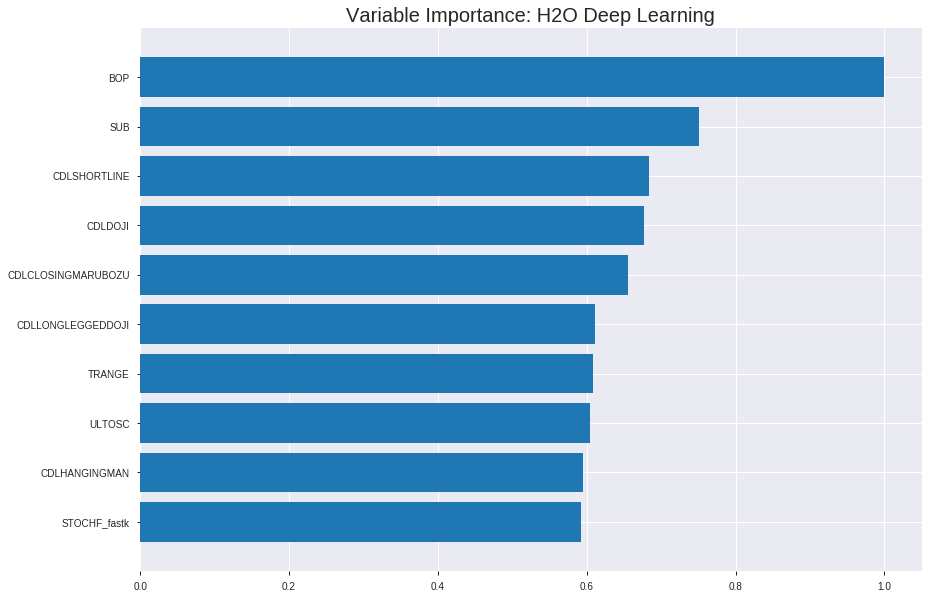

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_021024_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2028158051866518
RMSE: 0.4503507579505688
LogLoss: 0.5880892419133574
Mean Per-Class Error: 0.31497823732766883
AUC: 0.7533210202424092
pr_auc: 0.7524846240727975
Gini: 0.5066420404848184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.350859716654089: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      261  587   0.6922   (587.0/848.0)
1      37   869   0.0408   (37.0/906.0)
Total  298  1456  0.3558   (624.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35086      0.735817  288
max f2                       0.27925      0.859891  314
max f0point5                 0.555958     0.697674  173
max accuracy                 0.54824      0.685291  179
max precision                0.935442     1         0
max recall                   0.0960065    1         378
max specificity              0.935442     1         0
max absolute_mcc             0.521679     0.374388  204
max min_per_class_accuracy   0.549749     0.679245  178
max mean_per_class_accuracy  0.54824      0.685022  179

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.908239           1.93598   1.93598            1                0.921209  1                           0.921209            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.884218           1.72087   1.82843            0.888889         0.895372  0.944444                    0.908291            0.01766         0.0375276                  72.0873   82.8428
    3        0.0302166                   0.863307           1.70822   1.78987            0.882353         0.870721  0.924528                    0.89624             0.0165563       0.0540839                  70.822    78.987
    4        0.0404789                   0.835544           1.61332   1.74511            0.833333         0.847743  0.901408                    0.883945            0.0165563       0.0706402                  61.3319   74.5111
    5        0.050171                    0.821636           1.8221    1.75998            0.941176         0.829115  0.909091                    0.873353            0.01766         0.0883002                  82.2101   75.9984
    6        0.100342                    0.738683           1.62799   1.69398            0.840909         0.781177  0.875                       0.827265            0.0816777       0.169978                   62.7985   69.3985
    7        0.149943                    0.669972           1.44642   1.61209            0.747126         0.702448  0.8327                      0.785976            0.0717439       0.241722                   44.6424   61.2092
    8        0.200114                    0.607061           1.45199   1.57195            0.75             0.639245  0.811966                    0.749189            0.0728477       0.31457                    45.1987   57.1951
    9        0.299886                    0.57468            1.25009   1.46487            0.645714         0.587563  0.756654                    0.695416            0.124724        0.439294                   25.0091   46.4869
    10       0.400228                    0.560312           1.25399   1.412              0.647727         0.566881  0.729345                    0.663191            0.125828        0.565121                   25.3989   41.1999
    11       0.5                         0.550972           1.11734   1.3532             0.577143         0.555781  0.698974                    0.641758            0.111479        0.6766                     11.7338   35.3201
    12       0.599772                    0.529882           0.951397  1.28636            0.491429         0.540833  0.664449                    0.624969            0.0949227       0.771523                   -4.8603   28.6361
    13       0.700114                    0.484054           0.846992  1.22339            0.4375           0.512472  0.631922                    0.608846            0.084989        0.856512                   -15.3008  22.3389
    14       0.799886                    0.390852           0.752267  1.16463            0.388571         0.440506  0.601568                    0.587848            0.0750552       0.931567                   -24.7733  16.4625
    15       0.899658                    0.220574           0.51995   1.09313            0.268571         0.310828  0.564639                    0.557127            0.0518764       0.983444                   -48.005   9.31307
    16       1                           0.0243685          0.164998  1                  0.0852273        0.131412  0.516534                    0.51441           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21134542343123083
RMSE: 0.4597232030594397
LogLoss: 0.605572705807099
Mean Per-Class Error: 0.3428736073761045
AUC: 0.718113714944295
pr_auc: 0.7528272374057546
Gini: 0.43622742988859
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.217806949313968: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      43   185  0.8114   (185.0/228.0)
1      3    271  0.0109   (3.0/274.0)
Total  46   456  0.3745   (188.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217807     0.742466  355
max f2                       0.158066     0.873724  371
max f0point5                 0.560076     0.690128  163
max accuracy                 0.521197     0.657371  234
max precision                0.917934     1         0
max recall                   0.158066     1         371
max specificity              0.917934     1         0
max absolute_mcc             0.560076     0.318322  163
max min_per_class_accuracy   0.547649     0.631579  189
max mean_per_class_accuracy  0.560076     0.657126  163

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.897077           1.83212   1.83212            1                0.905283  1                           0.905283            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.853597           1.83212   1.83212            1                0.866775  1                           0.887779            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.834526           1.09927   1.6031             0.6              0.84381   0.875                       0.874039            0.0109489       0.0510949                  9.92701   60.3102
    4        0.0418327                   0.818887           1.83212   1.65763            1                0.824055  0.904762                    0.862138            0.0182482       0.0693431                  83.2117   65.7629
    5        0.0517928                   0.798217           1.46569   1.62072            0.8              0.80603   0.884615                    0.851348            0.0145985       0.0839416                  46.5693   62.0719
    6        0.101594                    0.732657           1.75883   1.68842            0.96             0.767521  0.921569                    0.810256            0.0875912       0.171533                   75.8832   68.8421
    7        0.151394                    0.645693           1.39241   1.59105            0.76             0.685548  0.868421                    0.769234            0.0693431       0.240876                   39.2409   59.1049
    8        0.201195                    0.595938           1.24584   1.5056             0.68             0.615716  0.821782                    0.731234            0.0620438       0.30292                    24.5839   50.5601
    9        0.300797                    0.574697           1.2092    1.40745            0.66             0.583586  0.768212                    0.682344            0.120438        0.423358                   20.9197   40.7454
    10       0.400398                    0.560268           1.17255   1.34902            0.64             0.56709   0.736318                    0.653674            0.116788        0.540146                   17.2555   34.9021
    11       0.5                         0.549357           0.769489  1.23358            0.42             0.555662  0.673307                    0.63415             0.0766423       0.616788                   -23.0511  23.3577
    12       0.599602                    0.532292           1.09927   1.21127            0.6              0.541484  0.66113                     0.618757            0.109489        0.726277                   9.92701   21.1267
    13       0.699203                    0.494263           0.952701  1.17443            0.52             0.514502  0.641026                    0.603906            0.0948905       0.821168                   -4.72993  17.4434
    14       0.798805                    0.400962           0.806131  1.12851            0.44             0.457567  0.61596                     0.585659            0.080292        0.90146                    -19.3869  12.8511
    15       0.898406                    0.230176           0.769489  1.08871            0.42             0.324753  0.594235                    0.556734            0.0766423       0.978102                   -23.0511  8.8708
    16       1                           0.0213802          0.215543  1                  0.117647         0.133418  0.545817                    0.513727          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:16:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 02:16:44  1 min 23.492 sec  710 obs/sec       0.792474  1             1390       0.460379         0.612219            0.151278       0.724978        0.71211            1.72087          0.351767                         0.469289           0.628746              0.11161          0.684923          0.6965               1.22141            0.360558
    2019-07-25 02:16:56  1 min 35.567 sec  1083 obs/sec      7.97891   10            13995      0.459128         0.607791            0.155884       0.733006        0.732122           1.72087          0.350057                         0.469397           0.627971              0.111204         0.702403          0.736662             1.52676            0.358566
    2019-07-25 02:17:07  1 min 46.679 sec  1220 obs/sec      15.9458   20            27969      0.454678         0.599687            0.172167       0.742787        0.74285            1.93598          0.340935                         0.470163           0.630804              0.108299         0.707013          0.740875             1.83212            0.37251
    2019-07-25 02:17:19  1 min 58.151 sec  1305 obs/sec      24.7497   31            43411      0.450351         0.588089            0.187849       0.753321        0.752485           1.93598          0.355758                         0.459723           0.605573              0.14746          0.718114          0.752827             1.83212            0.374502
    2019-07-25 02:17:30  2 min  9.981 sec  1370 obs/sec      34.3347   43            60223      0.446302         0.58025             0.202386       0.758332        0.756413           1.93598          0.327252                         0.459412           0.606194              0.148615         0.725101          0.755338             1.83212            0.346614
    2019-07-25 02:17:43  2 min 22.269 sec  1421 obs/sec      44.6739   56            78358      0.44178          0.569091            0.218468       0.765879        0.762367           1.93598          0.314139                         0.459813           0.606366              0.147125         0.71408           0.743503             1.83212            0.346614
    2019-07-25 02:17:54  2 min 33.543 sec  1456 obs/sec      54.2047   68            95075      0.438108         0.559762            0.231405       0.778024        0.783371           1.93598          0.310718                         0.46295            0.613113              0.135449         0.699377          0.727156             1.52676            0.346614
    2019-07-25 02:18:06  2 min 45.694 sec  1485 obs/sec      64.5906   81            113292     0.430299         0.539702            0.25856        0.78531         0.795714           1.93598          0.295895                         0.473343           0.644052              0.0961956        0.699089          0.725407             1.52676            0.380478
    2019-07-25 02:18:07 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04270496321691356
SUB                 0.7505233287811279     0.7505233287811279   0.03205107114903359
CDLSHORTLINE        0.6835818886756897     0.6835818886756897   0.02919233941164363
CDLDOJI             0.6769965291023254     0.6769965291023254   0.02891111187329296
CDLCLOSINGMARUBOZU  0.6559976935386658     0.6559976935386658   0.028014357372948856
---                 ---                    ---                  ---
CMO_20              0.367796391248703      0.367796391248703    0.015706731359589412
RSI_20              0.36713242530822754    0.36713242530822754  0.015678376718524123
MOM_8               0.3664822280406952     0.3664822280406952   0.015650610068130417
CMO_12              0.36487218737602234    0.36487218737602234  0.015581853340767827
RSI_14              0.35939502716064453    0.35939502716064453  0.015347951415236975


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.7659574468085106)

('auc', 0.735632183908046)

('logloss', 0.6130934454181818)

('mean_per_class_error', 0.2976692209450831)

('rmse', 0.4578760412242409)

('mse', 0.20965046912718274)

deeplearning prediction progress: |███████████████████████████████████████| 100%


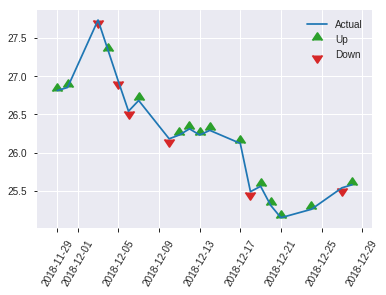


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20965046912718274
RMSE: 0.4578760412242409
LogLoss: 0.6130934454181818
Mean Per-Class Error: 0.2976692209450831
AUC: 0.735632183908046
pr_auc: 0.701793987695612
Gini: 0.47126436781609193
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36204271786301756: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   68   0.5862   (68.0/116.0)
1      9    126  0.0667   (9.0/135.0)
Total  57   194  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362043     0.765957  190
max f2                       0.306009     0.861373  199
max f0point5                 0.504623     0.720054  148
max accuracy                 0.504623     0.709163  148
max precision                0.921911     1         0
max recall                   0.0537397    1         243
max specificity              0.921911     1         0
max absolute_mcc             0.362043     0.413091  190
max min_per_class_accuracy   0.53921      0.666667  124
max mean_per_class_accuracy  0.504623     0.702331  148

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.904298           1.23951   1.23951            0.666667         0.916567   0.666667                    0.916567            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.891769           0.619753  0.92963            0.333333         0.895639   0.5                         0.906103            0.00740741      0.0222222                  -38.0247  -7.03704
    3        0.0318725                   0.850284           0.92963   0.92963            0.5              0.871742   0.5                         0.897513            0.00740741      0.0296296                  -7.03704  -7.03704
    4        0.0438247                   0.832369           1.85926   1.18316            1                0.838774   0.636364                    0.881493            0.0222222       0.0518519                  85.9259   18.3165
    5        0.0517928                   0.827773           1.85926   1.28718            1                0.830334   0.692308                    0.873622            0.0148148       0.0666667                  85.9259   28.7179
    6        0.103586                    0.745841           1.71624   1.50171            0.923077         0.776612   0.807692                    0.825117            0.0888889       0.155556                   71.6239   50.1709
    7        0.151394                    0.704934           1.08457   1.36998            0.583333         0.715471   0.736842                    0.790492            0.0518519       0.207407                   8.45679   36.9981
    8        0.203187                    0.650998           1.4302    1.38533            0.769231         0.678911   0.745098                    0.76205             0.0740741       0.281481                   43.0199   38.533
    9        0.302789                    0.57313            1.33867   1.36998            0.72             0.596004   0.736842                    0.70743             0.133333        0.414815                   33.8667   36.9981
    10       0.40239                     0.559648           1.33867   1.36223            0.72             0.566176   0.732673                    0.672466            0.133333        0.548148                   33.8667   36.223
    11       0.501992                    0.540489           1.04119   1.29853            0.56             0.553492   0.698413                    0.64886             0.103704        0.651852                   4.11852   29.853
    12       0.601594                    0.505942           1.33867   1.30518            0.72             0.526801   0.701987                    0.628651            0.133333        0.785185                   33.8667   30.5175
    13       0.701195                    0.427792           0.818074  1.23598            0.44             0.470558   0.664773                    0.606195            0.0814815       0.866667                   -18.1926  23.5985
    14       0.800797                    0.323119           0.743704  1.17476            0.4              0.382766   0.631841                    0.578405            0.0740741       0.940741                   -25.6296  17.4756
    15       0.900398                    0.199794           0.297481  1.07771            0.16             0.261035   0.579646                    0.543298            0.0296296       0.97037                    -70.2519  7.77122
    16       1                           0.0348175          0.297481  1                  0.16             0.0995627  0.537849                    

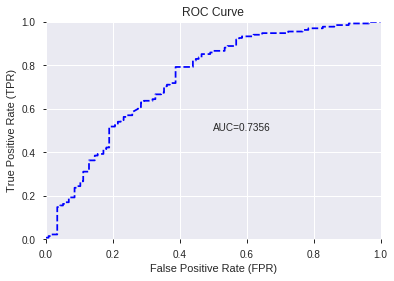

This function is available for GLM models only


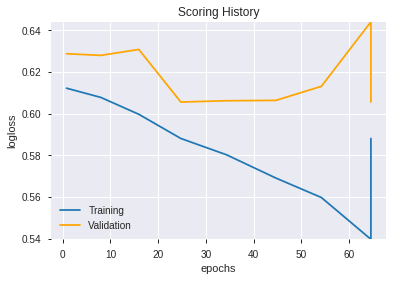

['BOP',
 'SUB',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'ULTOSC',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'DIV',
 'STOCHRSI_fastd',
 'ADOSC',
 'CDLLONGLINE',
 'CCI_8',
 'WILLR_8',
 'WILLR_30',
 'STOCH_slowk',
 'WILLR_20',
 'STOCHRSI_fastk',
 'CCI_20',
 'MINUS_DI_8',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLMARUBOZU',
 'CMO_30',
 'RSI_30',
 'WILLR_24',
 'ROC_8',
 'ROCR100_8',
 'CCI_14',
 'WILLR_14',
 'CCI_30',
 'CCI_12',
 'CMO_24',
 'ROCP_8',
 'RSI_24',
 'RSI_8',
 'CCI_24',
 'CMO_8',
 'WILLR_12',
 'CMO_14',
 'RSI_12',
 'ROCR_8',
 'CMO_20',
 'RSI_20',
 'MOM_8',
 'CMO_12',
 'RSI_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_021929_model_1  0.715581  0.617189              0.333238  0.464477  0.215739

variable  relative_importance  scaled_importance  percentage
0               CMO_12             1.286533           1.000000    0.076358
1               CCI_24             1.106884           0.860363    0.065696
2         STOCHF_fastk             1.053610           0.818954    0.062534
3                CMO_8             0.849299           0.660146    0.050408
4               CMO_20             0.789906           0.613981    0.046882
5                  SUB             0.740559           0.575624    0.043954
6               CCI_20             0.704756           0.547795    0.041829
7                  BOP             0.647124           0.502998    0.038408
8               CCI_12             0.642680           0.499544    0.038144
9             WILLR_24             0.622081           0.483533    0.036922
10            WILLR_30             0.559826           0.435143    0.033227
11              RSI_12             0.550915           0.428217    0.032698
12      STOCHRSI_fastk             0.520999           0.404964    0.030922
13              CCI_30             0.506065           0.393355    0.030036
14               CCI_8             0.487354           0.378812    0.028925
15               RSI_8             0.438181           0.340590    0.026007
16                 DIV             0.415871           0.323249    0.024683
17            WILLR_14             0.402717           0.313025    0.023902
18              ULTOSC             0.383563           0.298137    0.022765
19        STOCHF_fastd             0.357280           0.277707    0.021205
20            WILLR_12             0.355565           0.276374    0.021103
21         STOCH_slowk             0.321063           0.249557    0.019056
22              CMO_14             0.289285           0.224856    0.017170
23              CCI_14             0.269493           0.209472    0.015995
24      STOCHRSI_fastd             0.254420           0.197756    0.015100
25              CMO_30             0.246109           0.191296    0.014607
26              RSI_20             0.223089           0.173404    0.013241
27             WILLR_8             0.194727           0.151358    0.011557
28               MOM_8             0.188502           0.146519    0.011188
29              RSI_14             0.184807           0.143647    0.010969
30       CDLHANGINGMAN             0.153999           0.119701    0.009140
31              CMO_24             0.153411           0.119244    0.009105
32         CDLBELTHOLD             0.138372           0.107554    0.008213
33          MINUS_DI_8             0.124913           0.097093    0.007414
34  CDLCLOSINGMARUBOZU             0.119555           0.092928    0.007096
35            WILLR_20             0.093819           0.072924    0.005568
36   CDLLONGLEGGEDDOJI             0.076584           0.059528    0.004545
37             CDLDOJI             0.076220           0.059244    0.004524
38         CDLLONGLINE             0.065003           0.050526    0.003858
39              RSI_30             0.058338           0.045345    0.003462
40              TRANGE             0.055442           0.043094    0.003291
41              RSI_24             0.027609           0.021460    0.001639
42               ADOSC             0.026890           0.020901    0.001596
43         CDLMARUBOZU             0.025381           0.019728    0.001506
44           ROCR100_8             0.014658           0.011394    0.000870
45              ROCR_8             0.013642           0.010604    0.000810
46        CDLSHORTLINE             0.012666           0.009845    0.000752
47              ROCP_8             0.011140           0.008659    0.000661
48               ROC_8             0.007747           0.006022    0.000460

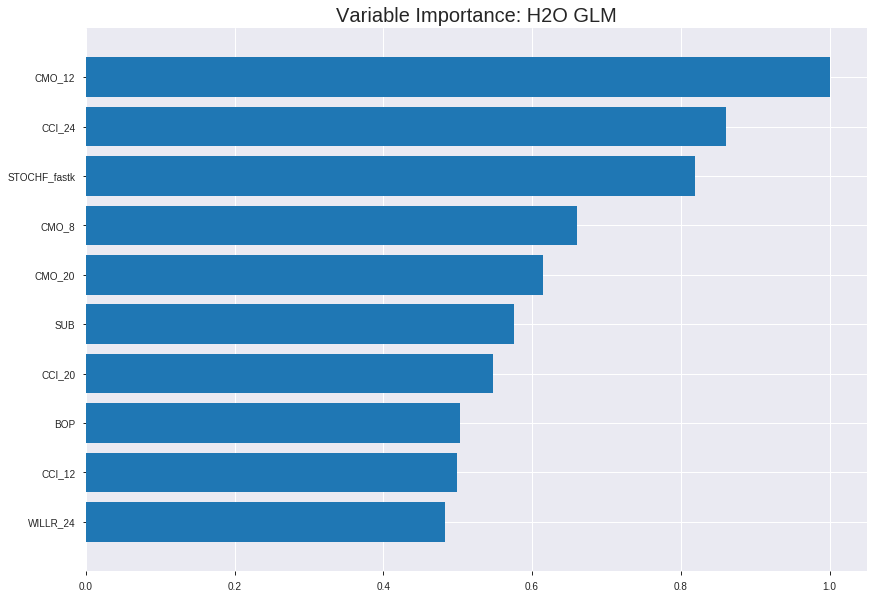

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_021929_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20285488087406323
RMSE: 0.45039413947570767
LogLoss: 0.5899365775398738
Null degrees of freedom: 1753
Residual degrees of freedom: 1704
Null deviance: 2429.642057792962
Residual deviance: 2069.4975140098772
AIC: 2169.4975140098772
AUC: 0.7468071868882502
pr_auc: 0.7348612578834991
Gini: 0.4936143737765004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35048887001211826: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      361  487   0.5743   (487.0/848.0)
1      97   809   0.1071   (97.0/906.0)
Total  458  1296  0.333    (584.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350489     0.734787  272
max f2                       0.163209     0.856138  358
max f0point5                 0.559055     0.696684  174
max accuracy                 0.490753     0.688712  206
max precision                0.931743     1         0
max recall                   0.105891     1         379
max specificity              0.931743     1         0
max absolute_mcc             0.490753     0.376667  206
max min_per_class_accuracy   0.548058     0.678066  180
max mean_per_class_accuracy  0.490753     0.686634  206

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.900952           1.82843   1.82843            0.944444         0.912856  0.944444                    0.912856            0.0187638       0.0187638                  82.8428   82.8428
    2        0.0205245                   0.879539           1.61332   1.72087            0.833333         0.887942  0.888889                    0.900399            0.0165563       0.0353201                  61.3319   72.0873
    3        0.0302166                   0.859161           1.8221    1.75334            0.941176         0.868481  0.90566                     0.890161            0.01766         0.0529801                  82.2101   75.3342
    4        0.0404789                   0.840928           1.50576   1.69058            0.777778         0.850667  0.873239                    0.880148            0.0154525       0.0684327                  50.5764   69.0576
    5        0.050171                    0.829256           1.36658   1.62799            0.705882         0.833263  0.840909                    0.871091            0.013245        0.0816777                  36.6576   62.7985
    6        0.100342                    0.782942           1.42999   1.52899            0.738636         0.802827  0.789773                    0.836959            0.0717439       0.153422                   42.9987   52.8986
    7        0.149943                    0.747894           1.6912    1.58265            0.873563         0.765603  0.81749                     0.813355            0.0838852       0.237307                   69.1203   58.2647
    8        0.200114                    0.719341           1.42999   1.54437            0.738636         0.733331  0.797721                    0.793292            0.0717439       0.309051                   42.9987   54.4373
    9        0.299886                    0.668178           1.28328   1.45751            0.662857         0.693543  0.752852                    0.760105            0.128035        0.437086                   28.328    45.7508
    10       0.400228                    0.616984           1.19899   1.39269            0.619318         0.64162   0.719373                    0.7304              0.120309        0.557395                   19.8989   39.2694
    11       0.5                         0.549758           1.18371   1.35099            0.611429         0.588109  0.697834                    0.702006            0.118102        0.675497                   18.3715   35.0993
    12       0.599772                    0.463771           0.984585  1.29004            0.508571         0.508972  0.66635                     0.669895            0.098234        0.773731                   -1.54147  29.0041
    13       0.700114                    0.381713           0.857992  1.22812            0.443182         0.422237  0.634365                    0.6344              0.0860927       0.859823                   -14.2008  22.8119
    14       0.799886                    0.295802           0.652703  1.15635            0.337143         0.341743  0.597292                    0.597896            0.0651214       0.924945                   -34.7297  15.6346
    15       0.899658                    0.198636           0.553138  1.08945            0.285714         0.245802  0.562738                    0.558849            0.0551876       0.980132                   -44.6862  8.94501
    16       1                           0.0214977          0.197998  1                  0.102273         0.137137  0.516534                    0.516534         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20595631720438123
RMSE: 0.45382410381598426
LogLoss: 0.5945088261647123
Null degrees of freedom: 501
Residual degrees of freedom: 452
Null deviance: 693.4256799911966
Residual deviance: 596.8868614693713
AIC: 696.8868614693713
AUC: 0.736433922397234
pr_auc: 0.763426240363226
Gini: 0.4728678447944681
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28893299130442096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      79   149  0.6535   (149.0/228.0)
1      16   258  0.0584   (16.0/274.0)
Total  95   407  0.3287   (165.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288933     0.757709  317
max f2                       0.169786     0.870122  366
max f0point5                 0.605551     0.705244  154
max accuracy                 0.382127     0.677291  279
max precision                0.924875     1         0
max recall                   0.117396     1         385
max specificity              0.924875     1         0
max absolute_mcc             0.288933     0.366204  317
max min_per_class_accuracy   0.539589     0.644737  189
max mean_per_class_accuracy  0.605551     0.670636  154

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.890252           1.83212   1.83212            1                0.899496  1                           0.899496            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.867817           1.83212   1.83212            1                0.879948  1                           0.890611            0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.850126           1.83212   1.83212            1                0.856057  1                           0.879813            0.0182482       0.0583942                  83.2117   83.2117
    4        0.0418327                   0.819263           1.46569   1.74487            0.8              0.831654  0.952381                    0.868347            0.0145985       0.0729927                  46.5693   74.4873
    5        0.0517928                   0.79555            1.46569   1.69118            0.8              0.804385  0.923077                    0.856046            0.0145985       0.0875912                  46.5693   69.1185
    6        0.101594                    0.773542           1.53898   1.61657            0.84             0.782532  0.882353                    0.82001             0.0766423       0.164234                   53.8978   61.6574
    7        0.151394                    0.749354           1.39241   1.54284            0.76             0.762037  0.842105                    0.80094             0.0693431       0.233577                   39.2409   54.2835
    8        0.201195                    0.712502           1.53898   1.54188            0.84             0.730241  0.841584                    0.78344             0.0766423       0.310219                   53.8978   54.188
    9        0.300797                    0.663333           1.2092    1.43172            0.66             0.688935  0.781457                    0.752147            0.120438        0.430657                   20.9197   43.172
    10       0.400398                    0.610688           1.17255   1.36725            0.64             0.63574   0.746269                    0.72319             0.116788        0.547445                   17.2555   36.7251
    11       0.5                         0.549237           0.879416  1.27007            0.48             0.58348   0.693227                    0.695359            0.0875912       0.635036                   -12.0584  27.0073
    12       0.599602                    0.472991           1.06263   1.23561            0.58             0.506248  0.674419                    0.663946            0.105839        0.740876                   6.26277   23.5614
    13       0.699203                    0.400364           0.916058  1.19009            0.5              0.437468  0.649573                    0.631684            0.0912409       0.832117                   -8.39416  19.0093
    14       0.798805                    0.299899           0.952701  1.16049            0.52             0.350968  0.633416                    0.596682            0.0948905       0.927007                   -4.72993  16.0493
    15       0.898406                    0.219347           0.512993  1.08871            0.28             0.261609  0.594235                    0.559534            0.0510949       0.978102                   -48.7007  8.8708
    16       1                           0.0288501          0.215543  1                  0.117647         0.137461  0.545817                    0.516654            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 02:19:29  0.000 sec   2            .18E2     50            1.362271376630376   1.361200034398312
     2019-07-25 02:19:29  0.009 sec   4            .11E2     50            1.3536231683520474  1.3535928780260131
     2019-07-25 02:19:29  0.019 sec   6            .7E1      50            1.3432255230173582  1.3443788716017506
     2019-07-25 02:19:29  0.028 sec   8            .44E1     50            1.331002852026103   1.3334073590350657
     2019-07-25 02:19:29  0.037 sec   10           .27E1     50            1.3167192447936447  1.3203828172805303
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 02:19:29  0.262 sec   48           .12E-3    50            1.1801379966201253  1.1892035775684582
     2019-07-25 02:19:29  0.268 sec   49           .76E-4    50            1.180041965742432   1.1892133132553984
     2019-07-25 02:19:29  0.275 sec   50           .47E-4    50            1.1799694649035397  1.1891605843880306
     2019-07-25 02:19:29  0.283 sec   51           .29E-4    50            1.179915217317392   1.1890914689135939
     2019-07-25 02:19:29  0.289 sec   52           .18E-4    50            1.1798731550797477  1.189017652329425


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.756923076923077)

('auc', 0.7155810983397191)

('logloss', 0.6171894557903996)

('mean_per_class_error', 0.32346743295019165)

('rmse', 0.4644773278447964)

('mse', 0.21573918808184248)

glm prediction progress: |████████████████████████████████████████████████| 100%


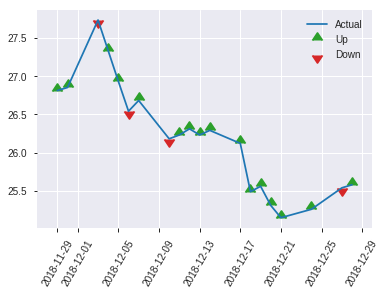


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21573918808184248
RMSE: 0.4644773278447964
LogLoss: 0.6171894557903996
Null degrees of freedom: 250
Residual degrees of freedom: 201
Null deviance: 346.9774746766028
Residual deviance: 309.8291068067806
AIC: 409.8291068067806
AUC: 0.7155810983397191
pr_auc: 0.7110886762672076
Gini: 0.4311621966794381
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2856943964980981: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   67   0.5776   (67.0/116.0)
1      12   123  0.0889   (12.0/135.0)
Total  61   190  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285694     0.756923  189
max f2                       0.129416     0.867876  231
max f0point5                 0.441663     0.696118  152
max accuracy                 0.38347      0.689243  170
max precision                0.902554     1         0
max recall                   0.105137     1         240
max specificity              0.902554     1         0
max absolute_mcc             0.285694     0.387688  189
max min_per_class_accuracy   0.474454     0.646552  128
max mean_per_class_accuracy  0.38347      0.676533  170

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 47.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.865655           1.85926   1.85926            1                0.88903   1                           0.88903             0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.847006           1.85926   1.85926            1                0.856544  1                           0.872787            0.0222222       0.0444444                  85.9259   85.9259
    3        0.0318725                   0.822863           0.92963   1.62685            0.5              0.832146  0.875                       0.862627            0.00740741      0.0518519                  -7.03704  62.6852
    4        0.0438247                   0.816893           1.85926   1.69024            1                0.817006  0.909091                    0.850185            0.0222222       0.0740741                  85.9259   69.0236
    5        0.0517928                   0.808881           0.92963   1.57322            0.5              0.81385   0.846154                    0.844595            0.00740741      0.0814815                  -7.03704  57.3219
    6        0.103586                    0.765674           1.28718   1.4302             0.692308         0.784651  0.769231                    0.814623            0.0666667       0.148148                   28.7179   43.0199
    7        0.151394                    0.715045           1.39444   1.41891            0.75             0.729963  0.763158                    0.787888            0.0666667       0.214815                   39.4444   41.8908
    8        0.203187                    0.683065           1.57322   1.45824            0.846154         0.701138  0.784314                    0.765776            0.0814815       0.296296                   57.3219   45.8243
    9        0.302789                    0.617309           1.04119   1.32105            0.56             0.646673  0.710526                    0.726597            0.103704        0.4                        4.11852   32.1053
    10       0.40239                     0.562768           1.11556   1.27019            0.6              0.586419  0.683168                    0.6919              0.111111        0.511111                   11.5556   27.0187
    11       0.501992                    0.482501           1.18993   1.25426            0.64             0.515983  0.674603                    0.656996            0.118519        0.62963                    18.9926   25.4262
    12       0.601594                    0.44231            1.2643    1.25592            0.68             0.463108  0.675497                    0.624895            0.125926        0.755556                   26.4296   25.5923
    13       0.701195                    0.341025           1.04119   1.22542            0.56             0.401974  0.659091                    0.59323             0.103704        0.859259                   4.11852   22.5421
    14       0.800797                    0.260307           0.669333  1.15626            0.36             0.296137  0.621891                    0.556278            0.0666667       0.925926                   -33.0667  15.6256
    15       0.900398                    0.151113           0.520593  1.08594            0.28             0.215986  0.584071                    0.518635            0.0518519       0.977778                   -47.9407  8.5939
    16       1                           0.0404074          0.223111  1                  0.12             0.10451   0.537849                    0.477388          

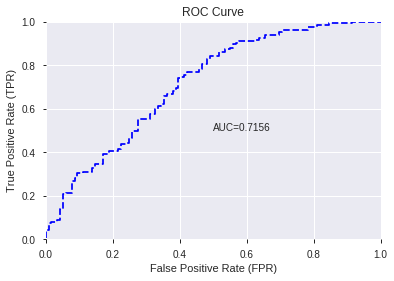

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


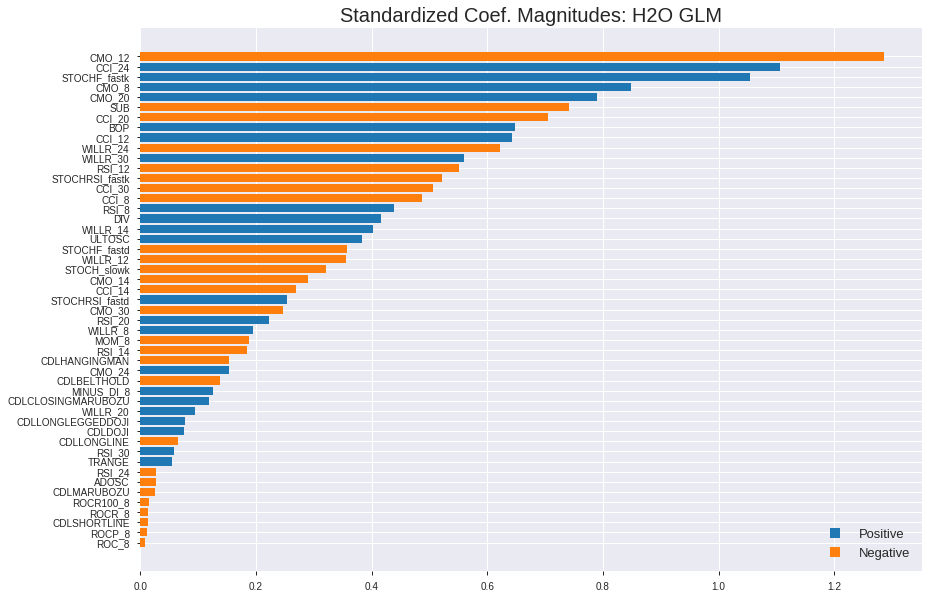

'log_likelihood'
--2019-07-25 02:19:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_021929_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_021929_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CMO_12',
 'CCI_24',
 'STOCHF_fastk',
 'CMO_8',
 'CMO_20',
 'SUB',
 'CCI_20',
 'BOP',
 'CCI_12',
 'WILLR_24',
 'WILLR_30',
 'RSI_12',
 'STOCHRSI_fastk',
 'CCI_30',
 'CCI_8',
 'RSI_8',
 'DIV',
 'WILLR_14',
 'ULTOSC',
 'STOCHF_fastd',
 'WILLR_12',
 'STOCH_slowk',
 'CMO_14',
 'CCI_14',
 'STOCHRSI_fastd',
 'CMO_30',
 'RSI_20',
 'WILLR_8',
 'MOM_8',
 'RSI_14',
 'CDLHANGINGMAN',
 'CMO_24',
 'CDLBELTHOLD',
 'MINUS_DI_8',
 'CDLCLOSINGMARUBOZU',
 'WILLR_20',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLLONGLINE',
 'RSI_30',
 'TRANGE',
 'RSI_24',
 'ADOSC',
 'CDLMARUBOZU',
 'ROCR100_8',
 'ROCR_8',
 'CDLSHORTLINE',
 'ROCP_8',
 'ROC_8']

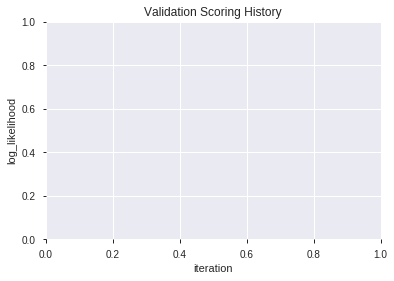

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190725_021943  0.719413  0.612624              0.346775  0.460665  0.212212
1  XGBoost_grid_1_AutoML_20190725_021943_model_5  0.714304  0.623319              0.338155  0.464275  0.215551
2               XGBoost_1_AutoML_20190725_021943  0.709642  0.621791              0.372573  0.464520  0.215779
3  XGBoost_grid_1_AutoML_20190725_021943_model_2  0.704342  0.619087              0.336941  0.463917  0.215219
4  XGBoost_grid_1_AutoML_20190725_021943_model_4  0.701660  0.623451              0.337548  0.465361  0.216561
5  XGBoost_grid_1_AutoML_20190725_021943_model_6  0.700958  0.619274              0.325287  0.463802  0.215112
6  XGBoost_grid_1_AutoML_20190725_021943_model_1  0.699042  0.623280              0.347989  0.465151  0.216366
7               XGBoost_3_AutoML_20190725_021943  0.697573  0.620560              0.351692  0.464506  0.215765
8  XGBoost_grid_1_AutoML_20190725_021943_model_7  0.696616  0.627283              0.346169  0.466598  0.217714
9  XGBoost_grid_1_AutoML_20190725_021943_model_3  0.696552  0.625551              0.324681  0.466537  0.217656

variable  relative_importance  scaled_importance  percentage
0                  BOP          1519.014160           1.000000    0.250868
1         STOCHF_fastk           654.938232           0.431160    0.108164
2                  SUB           249.302780           0.164121    0.041173
3       STOCHRSI_fastd           208.880341           0.137510    0.034497
4                  DIV           198.812775           0.130883    0.032834
5               ULTOSC           194.126526           0.127798    0.032060
6                ADOSC           194.048431           0.127746    0.032047
7          STOCH_slowk           192.789749           0.126918    0.031840
8              WILLR_8           179.837997           0.118391    0.029701
9             WILLR_20           150.230728           0.098900    0.024811
10               CCI_8           137.493149           0.090515    0.022707
11          MINUS_DI_8           129.811874           0.085458    0.021439
12              CCI_14           127.702133           0.084069    0.021090
13            WILLR_30           121.753448           0.080153    0.020108
14      STOCHRSI_fastk           113.588425           0.074778    0.018759
15              CCI_20           113.573082           0.074768    0.018757
16              TRANGE           112.020111           0.073745    0.018500
17               CMO_8           110.845406           0.072972    0.018306
18               ROC_8           109.907364           0.072354    0.018151
19              CCI_30           108.866402           0.071669    0.017979
20              CCI_24           100.923958           0.066440    0.016668
21            WILLR_12            95.236565           0.062696    0.015728
22              CMO_20            90.977379           0.059892    0.015025
23              CMO_30            89.367149           0.058832    0.014759
24              CCI_12            74.422607           0.048994    0.012291
25            WILLR_24            71.089630           0.046800    0.011741
26              CMO_24            66.810783           0.043983    0.011034
27            WILLR_14            66.195244           0.043578    0.010932
28        STOCHF_fastd            65.316116           0.042999    0.010787
29              CMO_12            56.938366           0.037484    0.009403
30               MOM_8            52.791119           0.034754    0.008719
31              RSI_12            52.380558           0.034483    0.008651
32              ROCP_8            41.645462           0.027416    0.006878
33              CMO_14            35.301270           0.023240    0.005830
34               RSI_8            34.710136           0.022850    0.005732
35              RSI_20            29.647278           0.019517    0.004896
36              RSI_30            27.114990           0.017850    0.004478
37              RSI_24            17.196310           0.011321    0.002840
38              RSI_14            16.776966           0.011045    0.002771
39         CDLBELTHOLD            15.928288           0.010486    0.002631
40         CDLLONGLINE             9.001882           0.005926    0.001487
41  CDLCLOSINGMARUBOZU             6.171889           0.004063    0.001019
42   CDLLONGLEGGEDDOJI             5.027463           0.003310    0.000830
43        CDLSHORTLINE             3.440914           0.002265    0.000568
44              ROCR_8             3.081601           0.002029    0.000509

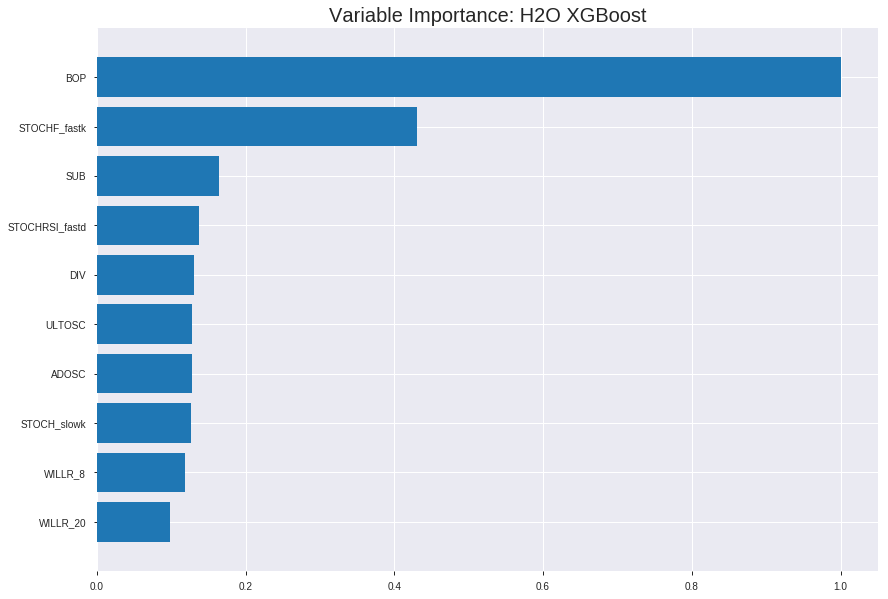

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190725_021943


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16310645613615346
RMSE: 0.4038644031555065
LogLoss: 0.5023603745121101
Mean Per-Class Error: 0.21154436877837468
AUC: 0.8674982558623849
pr_auc: 0.879505044852593
Gini: 0.7349965117247699
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5098322289330619: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      625  223  0.263    (223.0/848.0)
1      166  740  0.1832   (166.0/906.0)
Total  791  963  0.2218   (389.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509832     0.791867  201
max f2                       0.3184       0.872524  300
max f0point5                 0.58111      0.820818  160
max accuracy                 0.579305     0.785633  161
max precision                0.895661     1         0
max recall                   0.206572     1         352
max specificity              0.895661     1         0
max absolute_mcc             0.579305     0.583343  161
max min_per_class_accuracy   0.53559      0.778302  188
max mean_per_class_accuracy  0.579305     0.788456  161

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.865338           1.93598    1.93598            1                0.878047  1                           0.878047            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.848637           1.93598    1.93598            1                0.857343  1                           0.867695            0.0198675       0.0397351                  93.5982   93.5982
    3        0.0302166                   0.837378           1.93598    1.93598            1                0.842337  1                           0.859561            0.0187638       0.0584989                  93.5982   93.5982
    4        0.0404789                   0.827178           1.93598    1.93598            1                0.832571  1                           0.852719            0.0198675       0.0783664                  93.5982   93.5982
    5        0.050171                    0.817267           1.93598    1.93598            1                0.822053  1                           0.846795            0.0187638       0.0971302                  93.5982   93.5982
    6        0.100342                    0.776158           1.86998    1.90298            0.965909         0.795421  0.982955                    0.821108            0.093819        0.190949                   86.9983   90.2983
    7        0.149943                    0.737593           1.80247    1.86973            0.931034         0.755744  0.965779                    0.799486            0.089404        0.280353                   80.2466   86.9732
    8        0.200114                    0.709092           1.71598    1.83119            0.886364         0.722785  0.945869                    0.780256            0.0860927       0.366446                   71.5984   83.1186
    9        0.299886                    0.653964           1.67048    1.77772            0.862857         0.68152   0.918251                    0.747406            0.166667        0.533113                   67.0476   77.7718
    10       0.400228                    0.59404            1.34199    1.66847            0.693182         0.625384  0.861823                    0.716814            0.134658        0.66777                    34.1988   66.8475
    11       0.5                         0.539262           1.06202    1.54746            0.548571         0.566708  0.799316                    0.686861            0.10596         0.773731                   6.20246   54.7461
    12       0.599772                    0.475244           0.807581   1.42438            0.417143         0.506771  0.735741                    0.656903            0.080574        0.854305                   -19.2419  42.4382
    13       0.700114                    0.395412           0.626994   1.3101             0.323864         0.435332  0.67671                     0.625147            0.0629139       0.917219                   -37.3006  31.0099
    14       0.799886                    0.307007           0.497824   1.20878            0.257143         0.350488  0.624376                    0.590888            0.0496689       0.966887                   -50.2176  20.8782
    15       0.899658                    0.217595           0.298694   1.10785            0.154286         0.259034  0.572243                    0.554086            0.0298013       0.996689                   -70.1306  10.7853
    16       1                           0.0763018          0.0329997  1                  0.0170455        0.165529  0.516534                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2165146602950009
RMSE: 0.4653113584418512
LogLoss: 0.6208937896769672
Mean Per-Class Error: 0.34437828147009863
AUC: 0.7074289281598155
pr_auc: 0.7282660450308939
Gini: 0.414857856319631
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2648053467273712: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   171  0.75     (171.0/228.0)
1      14   260  0.0511   (14.0/274.0)
Total  71   431  0.3685   (185.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.264805     0.737589  336
max f2                       0.170289     0.867638  383
max f0point5                 0.554019     0.687809  181
max accuracy                 0.486902     0.653386  232
max precision                0.872348     1         0
max recall                   0.170289     1         383
max specificity              0.872348     1         0
max absolute_mcc             0.626611     0.321388  131
max min_per_class_accuracy   0.524072     0.640351  199
max mean_per_class_accuracy  0.554019     0.655622  181

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.847321           1.83212   1.83212            1                0.858086  1                           0.858086            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.795863           1.46569   1.66556            0.8              0.806221  0.909091                    0.834511            0.0145985       0.0364964                  46.5693   66.5561
    3        0.0318725                   0.784873           1.46569   1.6031             0.8              0.788067  0.875                       0.819997            0.0145985       0.0510949                  46.5693   60.3102
    4        0.0418327                   0.773197           1.83212   1.65763            1                0.777891  0.904762                    0.809972            0.0182482       0.0693431                  83.2117   65.7629
    5        0.0517928                   0.764011           1.46569   1.62072            0.8              0.769027  0.884615                    0.802098            0.0145985       0.0839416                  46.5693   62.0719
    6        0.101594                    0.731405           1.17255   1.40103            0.64             0.746854  0.764706                    0.775018            0.0583942       0.142336                   17.2555   40.103
    7        0.151394                    0.704191           1.53898   1.44641            0.84             0.718273  0.789474                    0.756352            0.0766423       0.218978                   53.8978   44.6408
    8        0.201195                    0.683973           1.39241   1.43304            0.76             0.693136  0.782178                    0.740704            0.0693431       0.288321                   39.2409   43.3042
    9        0.300797                    0.638387           1.31912   1.39532            0.72             0.661823  0.761589                    0.714585            0.131387        0.419708                   31.9124   39.5321
    10       0.400398                    0.598436           1.09927   1.32168            0.6              0.618818  0.721393                    0.690762            0.109489        0.529197                   9.92701   32.1676
    11       0.5                         0.53223            0.952701  1.24818            0.52             0.569515  0.681275                    0.666609            0.0948905       0.624088                   -4.72993  24.8175
    12       0.599602                    0.486889           1.06263   1.21735            0.58             0.506162  0.664452                    0.639957            0.105839        0.729927                   6.26277   21.7353
    13       0.699203                    0.42045            0.842774  1.16399            0.46             0.458813  0.635328                    0.614153            0.0839416       0.813869                   -15.7226  16.3994
    14       0.798805                    0.329544           0.806131  1.11937            0.44             0.374193  0.610973                    0.584233            0.080292        0.894161                   -19.3869  11.9373
    15       0.898406                    0.236895           0.732847  1.07652            0.4              0.28066   0.587583                    0.550577            0.0729927       0.967153                   -26.7153  7.6521
    16       1                           0.0894789          0.323315  1                  0.176471         0.1744    0.545817                    0.51236            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:19:45  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.483466                         0.5                0.693147              0.5               0                    1                  0.454183
    2019-07-25 02:19:45  0.074 sec   5                  0.478915         0.651625            0.784738        0.791748           1.93598          0.31984                          0.487588           0.668499              0.676383          0.696824             1.83212            0.368526
    2019-07-25 02:19:45  0.114 sec   10                 0.463669         0.621928            0.800181        0.808771           1.82843          0.309578                         0.478267           0.649962              0.701562          0.732516             1.83212            0.35259
    2019-07-25 02:19:45  0.160 sec   15                 0.45231          0.599654            0.811022        0.817604           1.82843          0.292474                         0.473062           0.639236              0.704588          0.745179             1.83212            0.376494
    2019-07-25 02:19:45  0.204 sec   20                 0.443123         0.581397            0.819642        0.829057           1.93598          0.267389                         0.470484           0.63366               0.704788          0.740393             1.83212            0.378486
    2019-07-25 02:19:45  0.251 sec   25                 0.435643         0.566364            0.828002        0.839907           1.93598          0.254276                         0.467561           0.627355              0.708774          0.743692             1.83212            0.374502
    2019-07-25 02:19:45  0.297 sec   30                 0.429227         0.553457            0.83733         0.848936           1.93598          0.254276                         0.46583            0.623482              0.712343          0.743957             1.83212            0.374502
    2019-07-25 02:19:45  0.343 sec   35                 0.423495         0.541916            0.843951        0.853834           1.93598          0.236032                         0.464518           0.620421              0.712015          0.740404             1.83212            0.380478
    2019-07-25 02:19:45  0.397 sec   40                 0.418191         0.531249            0.850162        0.860069           1.93598          0.236602                         0.464403           0.619786              0.710686          0.736488             1.83212            0.364542
    2019-07-25 02:19:45  0.445 sec   45                 0.413394         0.521354            0.854644        0.864561           1.93598          0.236032                         0.464241           0.619062              0.710174          0.736157             1.83212            0.366534
    2019-07-25 02:19:45  0.497 sec   50                 0.408678         0.511909            0.860764        0.873359           1.93598          0.233751                         0.465463           0.621564              0.707021          0.729175             1.83212            0.370518
    2019-07-25 02:19:45  0.558 sec   55                 0.403864         0.50236             0.867498        0.879505           1.93598          0.221779                         0.465311           0.620894              0.707429          0.

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1519.01416015625       1.0                    0.250867856117195
STOCHF_fastk        654.938232421875       0.4311600573588506     0.10816419923298165
SUB                 249.3027801513672      0.1641214326308342     0.04117279194698002
STOCHRSI_fastd      208.88034057617188     0.13751046307210585    0.0344969550645819
DIV                 198.81277465820312     0.1308827658576617     0.032834278873400395
---                 ---                    ---                    ---
CDLLONGLINE         9.00188159942627       0.005926134091139948   0.0014866765545073002
CDLCLOSINGMARUBOZU  6.171889305114746      0.004063088723596816   0.0010192983573026832
CDLLONGLEGGEDDOJI   5.027462959289551      0.0033096880142133842  0.000830294336542488
CDLSHORTLINE        3.4409141540527344     0.002265228491154284   0.0005682730151914636
ROCR_8              3.081601142883301      0.002028684935080736   0.0005089318404009551


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7515151515151516)

('auc', 0.7194125159642402)

('logloss', 0.6126240641530944)

('mean_per_class_error', 0.3143039591315453)

('rmse', 0.4606650925393085)

('mse', 0.21221232748424965)

xgboost prediction progress: |████████████████████████████████████████████| 100%


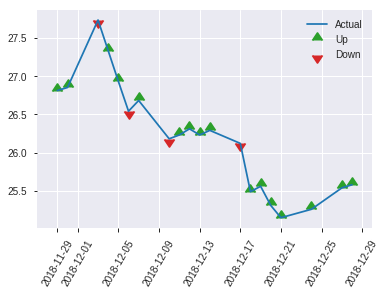


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21221232748424965
RMSE: 0.4606650925393085
LogLoss: 0.6126240641530944
Mean Per-Class Error: 0.3143039591315453
AUC: 0.7194125159642402
pr_auc: 0.6952583306251254
Gini: 0.4388250319284803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31210023164749146: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   71   0.6121   (71.0/116.0)
1      11   124  0.0815   (11.0/135.0)
Total  56   195  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3121       0.751515  194
max f2                       0.205675     0.870419  223
max f0point5                 0.482331     0.708155  140
max accuracy                 0.459085     0.693227  153
max precision                0.862273     1         0
max recall                   0.138152     1         244
max specificity              0.862273     1         0
max absolute_mcc             0.449481     0.380901  157
max min_per_class_accuracy   0.522118     0.659259  127
max mean_per_class_accuracy  0.459085     0.685696  153

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.858549           1.23951   1.23951            0.666667         0.860228  0.666667                    0.860228            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.810112           1.85926   1.54938            1                0.829469  0.833333                    0.844849            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.800323           0         1.16204            0                0.805753  0.625                       0.835075            0               0.037037                   -100      16.2037
    4        0.0438247                   0.780745           1.85926   1.35219            1                0.788859  0.727273                    0.82247             0.0222222       0.0592593                  85.9259   35.2189
    5        0.0517928                   0.779218           1.85926   1.4302             1                0.780194  0.769231                    0.815966            0.0148148       0.0740741                  85.9259   43.0199
    6        0.103586                    0.729216           1.4302    1.4302             0.769231         0.751172  0.769231                    0.783569            0.0740741       0.148148                   43.0199   43.0199
    7        0.151394                    0.695681           1.54938   1.46784            0.833333         0.713845  0.789474                    0.761551            0.0740741       0.222222                   54.9383   46.7836
    8        0.203187                    0.669937           0.7151    1.27596            0.384615         0.681257  0.686275                    0.741084            0.037037        0.259259                   -28.49    27.5962
    9        0.302789                    0.61008            1.56178   1.36998            0.84             0.641264  0.736842                    0.708249            0.155556        0.414815                   56.1778   36.9981
    10       0.40239                     0.574863           1.11556   1.307              0.6              0.59164   0.70297                     0.679385            0.111111        0.525926                   11.5556   30.7004
    11       0.501992                    0.529528           1.18993   1.28377            0.64             0.55154   0.690476                    0.654019            0.118519        0.644444                   18.9926   28.3774
    12       0.601594                    0.46717            1.18993   1.26824            0.64             0.492774  0.682119                    0.627323            0.118519        0.762963                   18.9926   26.8236
    13       0.701195                    0.393241           0.818074  1.20429            0.44             0.430528  0.647727                    0.599369            0.0814815       0.844444                   -18.1926  20.4293
    14       0.800797                    0.30581            0.818074  1.15626            0.44             0.343251  0.621891                    0.567514            0.0814815       0.925926                   -18.1926  15.6256
    15       0.900398                    0.203119           0.594963  1.09417            0.32             0.249695  0.588496                    0.532357            0.0592593       0.985185                   -40.5037  9.41658
    16       1                           0.113303           0.148741  1                  0.08             0.156843  0.537849                    0.494955         

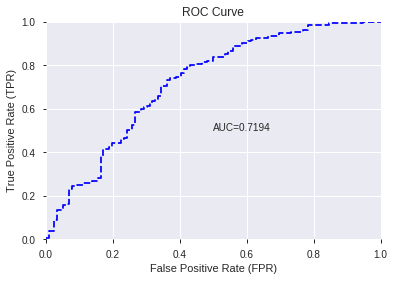

This function is available for GLM models only


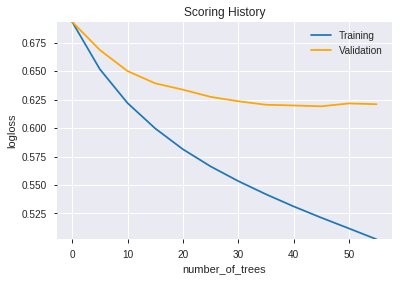

--2019-07-25 02:20:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


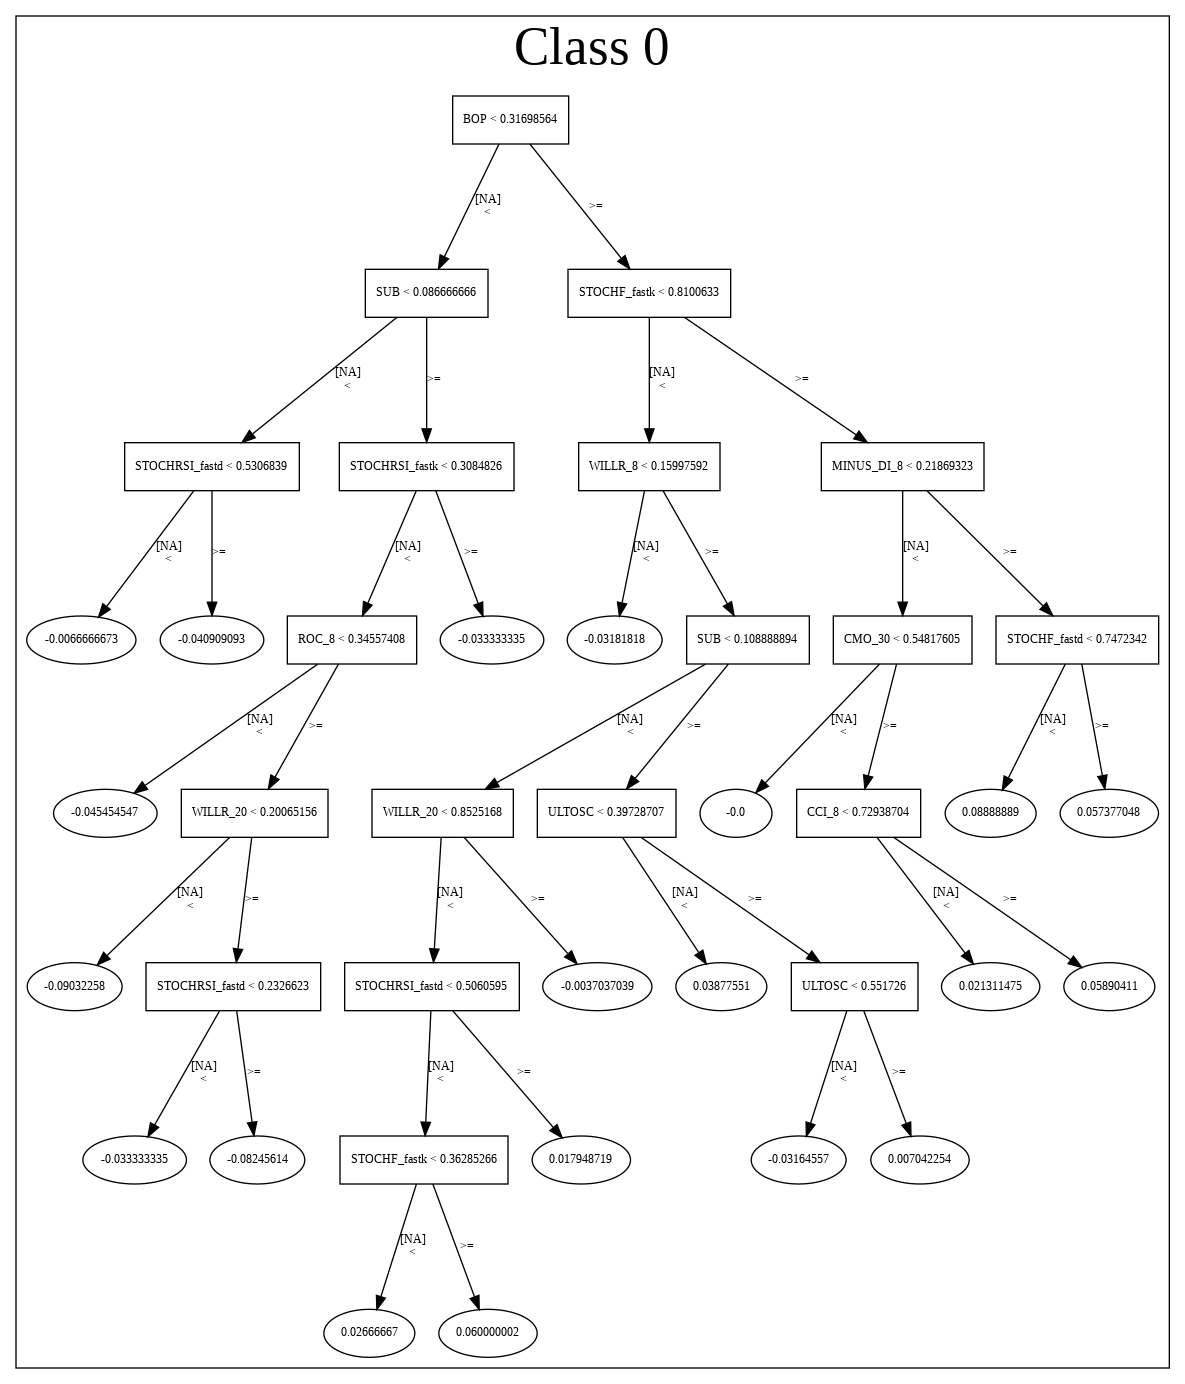

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190725_021943',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190725_021943',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_bd87',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastd',
 'DIV',
 'ULTOSC',
 'ADOSC',
 'STOCH_slowk',
 'WILLR_8',
 'WILLR_20',
 'CCI_8',
 'MINUS_DI_8',
 'CCI_14',
 'WILLR_30',
 'STOCHRSI_fastk',
 'CCI_20',
 'TRANGE',
 'CMO_8',
 'ROC_8',
 'CCI_30',
 'CCI_24',
 'WILLR_12',
 'CMO_20',
 'CMO_30',
 'CCI_12',
 'WILLR_24',
 'CMO_24',
 'WILLR_14',
 'STOCHF_fastd',
 'CMO_12',
 'MOM_8',
 'RSI_12',
 'ROCP_8',
 'CMO_14',
 'RSI_8',
 'RSI_20',
 'RSI_30',
 'RSI_24',
 'RSI_14',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'CDLSHORTLINE',
 'ROCR_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

70

['MAVP_14_3',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_5',
 'MA_14_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_upperband_14_5_5',
 'BBANDS_upperband_20_1_5',
 'BBANDS_middleband_20_7_2',
 'BBANDS_lowerband_24_5_2',
 'BOP',
 'aroondown_8',
 'AROONOSC_8',
 'CCI_8',
 'MOM_8',
 'PLUS_DI_8',
 'RSI_8',
 'TRIX_8',
 'WILLR_8',
 'ADXR_12',
 'CCI_12',
 'MACDFIX_signal_12',
 'MACDFIX_hist_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'ADXR_14',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'CMO_14',
 'MINUS_DI_14',
 'MOM_14',
 'ROC_14',
 'WILLR_14',
 'aroondown_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'RSI_20',
 'aroondown_24',
 'AROONOSC_24',
 'CCI_24',
 'DX_24',
 'MINUS_DI_24',
 'PLUS_DM_24',
 'ROC_24',
 'AROONOSC_30',
 'CCI_30',
 'ROCR100_30',
 'MACDEXT',
 'MACDEXT_hist',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ATR_24',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLSPINNIN

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_022113_model_3  0.716922  0.837432              0.370147  0.524287  0.274876
1  DeepLearning_grid_1_AutoML_20190725_022113_model_7  0.715645  0.687429              0.357822  0.485912  0.236110
2  DeepLearning_grid_1_AutoML_20190725_022113_model_8  0.710441  0.639841              0.337548  0.466882  0.217979
3  DeepLearning_grid_1_AutoML_20190725_022113_model_9  0.707088  0.615269              0.344285  0.463102  0.214463
4  DeepLearning_grid_1_AutoML_20190725_022113_model_6  0.706833  0.627753              0.353512  0.469069  0.220026
5  DeepLearning_grid_1_AutoML_20190725_022113_model_5  0.695977  0.642485              0.336335  0.466187  0.217330
6  DeepLearning_grid_1_AutoML_20190725_022113_model_4  0.692401  0.717667              0.375128  0.493066  0.243114
7               DeepLearning_1_AutoML_20190725_022113  0.691731  0.682302              0.373787  0.492870  0.242920
8  DeepLearning_grid_1_AutoML_20190725_022113_model_2  0.680651  1.148524              0.396616  0.587961  0.345698
9  DeepLearning_grid_1_AutoML_20190725_022113_model_1  0.658685  1.196051              0.421871  0.573994  0.329470

variable  relative_importance  scaled_importance  percentage
0        TRANGE             1.000000           1.000000    0.026624
1           BOP             0.741684           0.741684    0.019746
2       ADXR_14             0.704292           0.704292    0.018751
3     CORREL_12             0.703279           0.703279    0.018724
4   CDLLONGLINE             0.685030           0.685030    0.018238
..          ...                  ...                ...         ...
65       CCI_14             0.451929           0.451929    0.012032
66       RSI_12             0.440154           0.440154    0.011718
67       CCI_30             0.437604           0.437604    0.011651
68       CMO_14             0.437556           0.437556    0.011649
69      MA_14_4             0.430070           0.430070    0.011450

[70 rows x 4 columns]

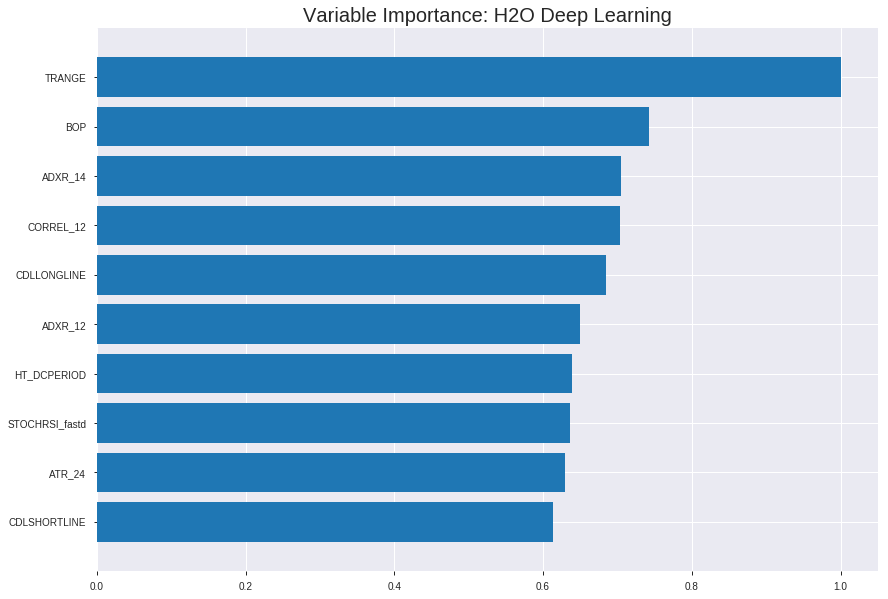

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_022113_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2187723166190133
RMSE: 0.4677310302075471
LogLoss: 0.646908054627664
Mean Per-Class Error: 0.31918108834187175
AUC: 0.7357748656753718
pr_auc: 0.7428947286340367
Gini: 0.4715497313507435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25737520126260477: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      390  458   0.5401   (458.0/848.0)
1      141  765   0.1556   (141.0/906.0)
Total  531  1223  0.3415   (599.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257375     0.718647  285
max f2                       0.0582164    0.850575  370
max f0point5                 0.412015     0.691093  218
max accuracy                 0.412015     0.6813    218
max precision                0.987886     1         0
max recall                   0.000558043  1         399
max specificity              0.987886     1         0
max absolute_mcc             0.412015     0.361745  218
max min_per_class_accuracy   0.422161     0.675708  213
max mean_per_class_accuracy  0.412015     0.680819  218

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 43.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.954355           1.82843   1.82843            0.944444         0.969287   0.944444                    0.969287            0.0187638       0.0187638                  82.8428   82.8428
    2        0.0205245                   0.933615           1.93598   1.88221            1                0.943717   0.972222                    0.956502            0.0198675       0.0386313                  93.5982   88.2205
    3        0.0302166                   0.915556           1.93598   1.89945            1                0.921841   0.981132                    0.945385            0.0187638       0.0573951                  93.5982   89.9454
    4        0.0404789                   0.896711           1.61332   1.82691            0.833333         0.906422   0.943662                    0.935507            0.0165563       0.0739514                  61.3319   82.6913
    5        0.050171                    0.88318            1.70822   1.80398            0.882353         0.888743   0.931818                    0.926473            0.0165563       0.0905077                  70.822    80.3984
    6        0.100342                    0.823423           1.53999   1.67198            0.795455         0.854464   0.863636                    0.890468            0.0772627       0.16777                    53.9986   67.1985
    7        0.149943                    0.769573           1.33516   1.56056            0.689655         0.796604   0.806084                    0.859418            0.0662252       0.233996                   33.516    56.0564
    8        0.200114                    0.722466           1.47399   1.53886            0.761364         0.746115   0.794872                    0.831012            0.0739514       0.307947                   47.3987   53.8858
    9        0.299886                    0.616442           1.34966   1.47591            0.697143         0.668454   0.762357                    0.776929            0.134658        0.442605                   34.9656   47.591
    10       0.400228                    0.51954            1.14399   1.39269            0.590909         0.568539   0.719373                    0.724683            0.11479         0.557395                   14.399    39.2694
    11       0.5                         0.426779           1.09521   1.33333            0.565714         0.472477   0.688712                    0.674357            0.109272        0.666667                   9.52129   33.3333
    12       0.599772                    0.344338           0.951397  1.2698             0.491429         0.386646   0.655894                    0.626496            0.0949227       0.761589                   -4.8603   26.9798
    13       0.700114                    0.253956           0.835992  1.20762            0.431818         0.296821   0.623779                    0.579246            0.0838852       0.845475                   -16.4008  20.7624
    14       0.799886                    0.156647           0.619514  1.13427            0.32             0.202469   0.585887                    0.53225             0.0618102       0.907285                   -38.0486  13.4268
    15       0.899658                    0.0659465          0.674828  1.08332            0.348571         0.112012   0.559569                    0.485645            0.0673289       0.974614                   -32.5172  8.33158
    16       1                           2.89153e-05        0.252998  1                  0.130682         0.0288495  0.516534                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2432638391369995
RMSE: 0.4932178414625727
LogLoss: 0.6911023254106968
Mean Per-Class Error: 0.3575041618645153
AUC: 0.6956396465616596
pr_auc: 0.7102866597375537
Gini: 0.3912792931233191
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13819402728767513: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   165  0.7237   (165.0/228.0)
1      13   261  0.0474   (13.0/274.0)
Total  76   426  0.3546   (178.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.138194     0.745714  341
max f2                       0.0219234    0.864899  390
max f0point5                 0.463783     0.673913  183
max accuracy                 0.251112     0.655378  283
max precision                0.962981     1         0
max recall                   0.0219234    1         390
max specificity              0.962981     1         0
max absolute_mcc             0.166682     0.320631  324
max min_per_class_accuracy   0.403143     0.622807  214
max mean_per_class_accuracy  0.463783     0.642496  183

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 42.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.924002           1.52676   1.52676            0.833333         0.946765  0.833333                    0.946765            0.0182482       0.0182482                  52.6764   52.6764
    2        0.0219124                   0.902299           1.83212   1.66556            1                0.908052  0.909091                    0.929168            0.0182482       0.0364964                  83.2117   66.5561
    3        0.0318725                   0.879621           1.46569   1.6031             0.8              0.887366  0.875                       0.916105            0.0145985       0.0510949                  46.5693   60.3102
    4        0.0418327                   0.865505           1.46569   1.57039            0.8              0.870983  0.857143                    0.905362            0.0145985       0.0656934                  46.5693   57.0386
    5        0.0517928                   0.85371            1.46569   1.55025            0.8              0.858641  0.846154                    0.896377            0.0145985       0.080292                   46.5693   55.0253
    6        0.101594                    0.79375            1.39241   1.47288            0.76             0.823272  0.803922                    0.860541            0.0693431       0.149635                   39.2409   47.2878
    7        0.151394                    0.724009           1.31912   1.4223             0.72             0.757561  0.776316                    0.826666            0.0656934       0.215328                   31.9124   42.2301
    8        0.201195                    0.671496           1.17255   1.36048            0.64             0.702516  0.742574                    0.795936            0.0583942       0.273723                   17.2555   36.0483
    9        0.300797                    0.572604           1.28248   1.33465            0.7              0.626118  0.728477                    0.739705            0.127737        0.40146                    28.2482   33.4655
    10       0.400398                    0.490899           1.13591   1.28522            0.62             0.53148   0.701493                    0.687907            0.113139        0.514599                   13.5912   28.5216
    11       0.5                         0.415975           1.02599   1.23358            0.56             0.453693  0.673307                    0.641251            0.10219         0.616788                   2.59854   23.3577
    12       0.599602                    0.324438           1.06263   1.20518            0.58             0.364476  0.657807                    0.595275            0.105839        0.722628                   6.26277   20.518
    13       0.699203                    0.243092           0.952701  1.16921            0.52             0.277862  0.638177                    0.55006             0.0948905       0.817518                   -4.72993  16.9214
    14       0.798805                    0.164592           0.989343  1.14679            0.54             0.201803  0.625935                    0.506636            0.0985401       0.916058                   -1.06569  14.6786
    15       0.898406                    0.0917383          0.549635  1.08058            0.3              0.133385  0.5898                      0.465256            0.0547445       0.970803                   -45.0365  8.05833
    16       1                           0.000168985        0.287391  1                  0.156863         0.04758   0.545817                    0.422822          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:22:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 02:22:49  1 min 34.581 sec  5341 obs/sec      8         1             14032      0.516143         0.846764            -0.0667801     0.677474        0.689541           1.93598          0.430445                         0.545435           0.892484              -0.200072        0.650587          0.671372             1.83212            0.398406
    2019-07-25 02:22:55  1 min 40.915 sec  6332 obs/sec      32        4             56128      0.467731         0.646908            0.123953       0.735775        0.742895           1.82843          0.341505                         0.493218           0.691102              0.018705         0.69564           0.710287             1.52676            0.354582
    2019-07-25 02:23:01  1 min 46.224 sec  6982 obs/sec      56        7             98224      0.449935         0.600715            0.189349       0.766131        0.773178           1.93598          0.322691                         0.491357           0.69148               0.0260953        0.687004          0.696581             1.83212            0.344622
    2019-07-25 02:23:07  1 min 52.477 sec  7633 obs/sec      88        11            154352     0.433379         0.564829            0.247909       0.798274        0.806417           1.93598          0.295325                         0.504341           0.729904              -0.0260543       0.665634          0.688885             1.83212            0.38247
    2019-07-25 02:23:12  1 min 58.179 sec  8149 obs/sec      120       15            210480     0.415488         0.520048            0.308721       0.829276        0.834445           1.93598          0.27138                          0.515023           0.775844              -0.0699795       0.660552          0.679042             1.83212            0.390438
    2019-07-25 02:23:18  2 min  3.506 sec  8585 obs/sec      152       19            266608     0.397619         0.480719            0.366905       0.85191         0.854756           1.93598          0.244584                         0.516002           0.787969              -0.0740494       0.656846          0.685863             1.83212            0.376494
    2019-07-25 02:23:23  2 min  8.640 sec  8942 obs/sec      184       23            322736     0.380892         0.4475              0.41905        0.875054        0.876614           1.93598          0.220068                         0.529623           0.839846              -0.131501        0.638414          0.670685             1.83212            0.40239
    2019-07-25 02:23:23  2 min  8.755 sec  8941 obs/sec      184       23            322736     0.467731         0.646908            0.123953       0.735775        0.742895           1.82843          0.341505                         0.493218           0.691102              0.018705         0.69564           0.710287             1.52676            0.354582

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  --------------------
TRANGE       1.0                    1.0                  0.026623523244912392
BOP          0.7416844964027405     0.7416844964027405   0.0197462544303695
ADXR_14      0.7042920589447021     0.7042920589447021   0.018750736002521484
CORREL_12    0.7032794952392578     0.7032794952392578   0.018723777989172633
CDLLONGLINE  0.685030460357666      0.685030460357666    0.018237924384805357
---          ---                    ---                  ---
CCI_14       0.45192885398864746    0.45192885398864746  0.012031938349213374
RSI_12       0.4401542544364929     0.4401542544364929   0.011718457024337051
CCI_30       0.4376038908958435     0.4376038908958435   0.011650557361329595
CMO_14       0.4375556707382202     0.4375556707382202   0.011649273570842238
MA_14_4      0.4300696551799774     0.4300696551799774   0.011449969461615585


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6852589641434262)

('F1', 0.7448680351906158)

('auc', 0.7169220945083015)

('logloss', 0.8374319460961681)

('mean_per_class_error', 0.31625159642401024)

('rmse', 0.5242866438953118)

('mse', 0.2748764849670094)

deeplearning prediction progress: |███████████████████████████████████████| 100%


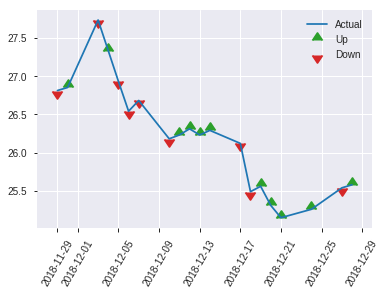


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2748764849670094
RMSE: 0.5242866438953118
LogLoss: 0.8374319460961681
Mean Per-Class Error: 0.31625159642401024
AUC: 0.7169220945083015
pr_auc: 0.7174721486060386
Gini: 0.43384418901660293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06406338381574535: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   79   0.681    (79.0/116.0)
1      8    127  0.0593   (8.0/135.0)
Total  45   206  0.3466   (87.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0640634    0.744868  205
max f2                       0.0483158    0.859788  215
max f0point5                 0.236682     0.707899  133
max accuracy                 0.236682     0.685259  133
max precision                0.973278     1         0
max recall                   8.68061e-05  1         250
max specificity              0.973278     1         0
max absolute_mcc             0.124595     0.371076  173
max min_per_class_accuracy   0.246466     0.672414  128
max mean_per_class_accuracy  0.236682     0.683748  133

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 31.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.934648           1.85926   1.85926            1                0.957816   1                           0.957816            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.87262            1.85926   1.85926            1                0.896461   1                           0.927139            0.0222222       0.0444444                  85.9259   85.9259
    3        0.0318725                   0.857273           0.92963   1.62685            0.5              0.864123   0.875                       0.911385            0.00740741      0.0518519                  -7.03704  62.6852
    4        0.0438247                   0.831227           1.23951   1.52121            0.666667         0.845281   0.818182                    0.893356            0.0148148       0.0666667                  23.9506   52.1212
    5        0.0517928                   0.807974           1.85926   1.57322            1                0.820761   0.846154                    0.882188            0.0148148       0.0814815                  85.9259   57.3219
    6        0.103586                    0.710445           1.28718   1.4302             0.692308         0.765427   0.769231                    0.823807            0.0666667       0.148148                   28.7179   43.0199
    7        0.151394                    0.630832           1.54938   1.46784            0.833333         0.662234   0.789474                    0.772784            0.0740741       0.222222                   54.9383   46.7836
    8        0.203187                    0.57116            1.28718   1.42179            0.692308         0.596355   0.764706                    0.727812            0.0666667       0.288889                   28.7179   42.1786
    9        0.302789                    0.436196           1.11556   1.32105            0.6              0.498517   0.710526                    0.652386            0.111111        0.4                        11.5556   32.1053
    10       0.40239                     0.332826           1.2643    1.307              0.68             0.381197   0.70297                     0.58526             0.125926        0.525926                   26.4296   30.7004
    11       0.501992                    0.256381           1.2643    1.29853            0.68             0.299741   0.698413                    0.52861             0.125926        0.651852                   26.4296   29.853
    12       0.601594                    0.172126           1.04119   1.25592            0.56             0.213389   0.675497                    0.476421            0.103704        0.755556                   4.11852   25.5923
    13       0.701195                    0.122566           0.966815  1.21486            0.52             0.147552   0.653409                    0.429706            0.0962963       0.851852                   -3.31852  21.4857
    14       0.800797                    0.073132           0.669333  1.14701            0.36             0.0982692  0.616915                    0.388483            0.0666667       0.918519                   -33.0667  14.7006
    15       0.900398                    0.0348132          0.446222  1.06949            0.24             0.0532032  0.575221                    0.351394            0.0444444       0.962963                   -55.3778  6.94854
    16       1                           8.68061e-05        0.371852  1                  0.2              0.0115998  0.537849                    

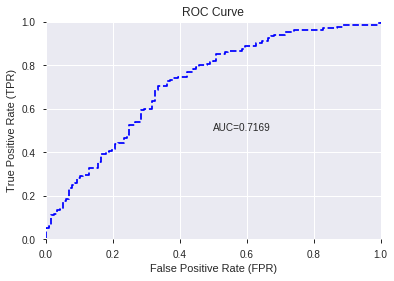

This function is available for GLM models only


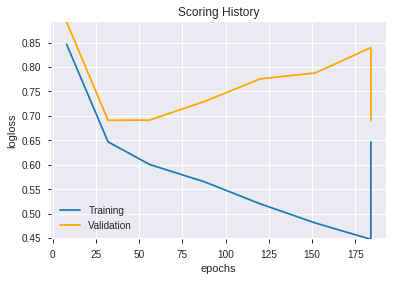

--2019-07-25 02:30:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


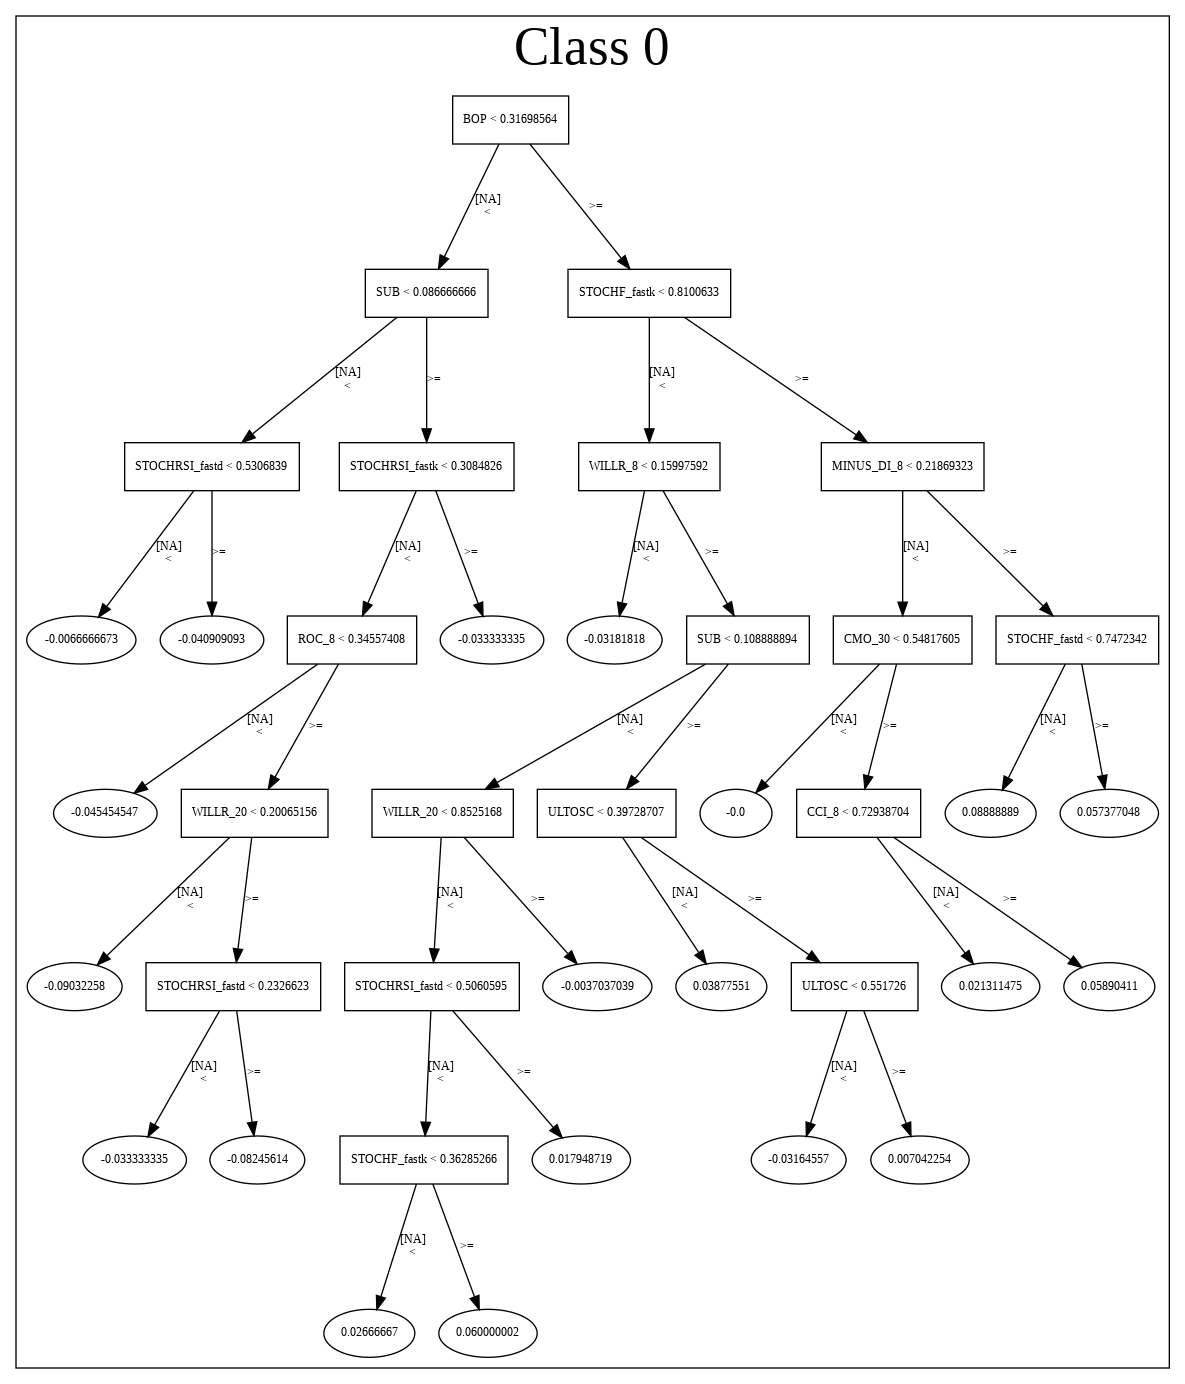

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_022113_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_022113_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'ADXR_14',
 'CORREL_12',
 'CDLLONGLINE',
 'ADXR_12',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'ATR_24',
 'CDLSHORTLINE',
 'PLUS_DM_24',
 'CCI_8',
 'aroonup_14',
 'aroondown_8',
 'STDDEV_8',
 'aroondown_24',
 'HT_PHASOR_inphase',
 'AROONOSC_30',
 'HT_PHASOR_quadrature',
 'BETA_12',
 'MACDEXT_hist',
 'CDLSPINNINGTOP',
 'BETA_8',
 'AROONOSC_8',
 'DX_24',
 'aroondown_14',
 'ULTOSC',
 'aroondown_20',
 'ROCR100_12',
 'STOCHF_fastd',
 'MACDFIX_signal_12',
 'AROONOSC_24',
 'BBANDS_lowerband_24_5_2',
 'BBANDS_upperband_20_1_5',
 'WILLR_8',
 'ROC_12',
 'MOM_14',
 'MACDEXT',
 'PLUS_DI_12',
 'PLUS_DI_8',
 'ROC_14',
 'CCI_12',
 'MACDFIX_hist_12',
 'ROC_20',
 'ROCP_20',
 'LINEARREG_ANGLE_8',
 'WILLR_14',
 'MOM_8',
 'CCI_24',
 'BBANDS_middleband_14_3_5',
 'BBANDS_upperband_14_5_5',
 'RSI_20',
 'MAVP_14_3',
 'RSI_8',
 'ROCR100_30',
 'BBANDS_upperband_14_3_3',
 'ROC_24',
 'MINUS_DI_24',
 'BBANDS_upperband_14_4_5',
 'MINUS_DI_12',
 'WILLR_12',
 'MINUS_DI_14',
 'TRIX_8',
 'ROCR_20',
 'BBAN

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_023028_model_1  0.699425  0.633573              0.325223  0.469678  0.220597

variable  relative_importance  scaled_importance  percentage
0              BOP             0.579350           1.000000    0.084423
1           TRANGE             0.427838           0.738479    0.062344
2           ULTOSC             0.350099           0.604296    0.051016
3          WILLR_8             0.343873           0.593550    0.050109
4            CCI_8             0.307165           0.530189    0.044760
..             ...                  ...                ...         ...
65          CCI_30             0.008113           0.014003    0.001182
66         ADXR_14             0.007988           0.013789    0.001164
67  CDLSPINNINGTOP             0.007505           0.012955    0.001094
68          CCI_14             0.007073           0.012209    0.001031
69     CDLLONGLINE             0.000325           0.000561    0.000047

[70 rows x 4 columns]

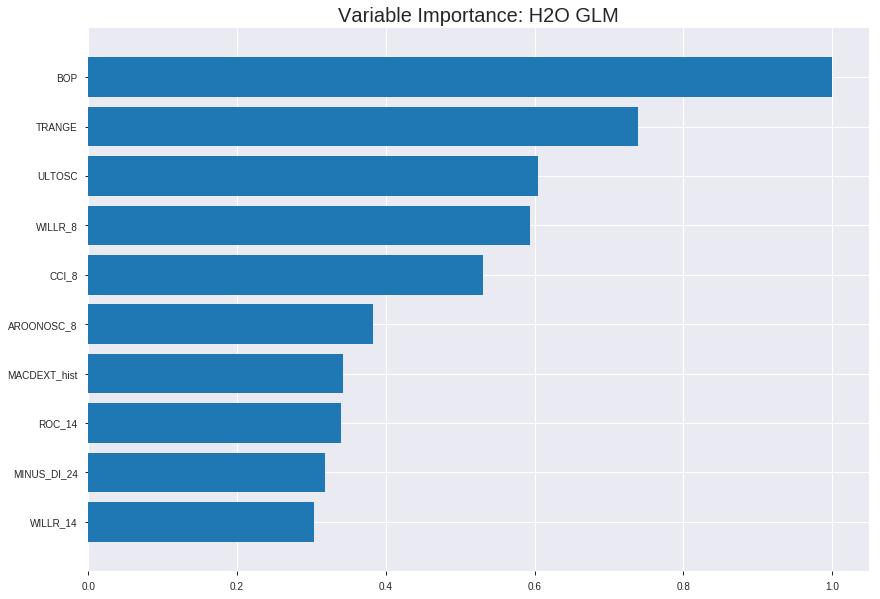

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_023028_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20476818800454294
RMSE: 0.45251319097297366
LogLoss: 0.5947166254153546
Null degrees of freedom: 1753
Residual degrees of freedom: 1683
Null deviance: 2429.642057792962
Residual deviance: 2086.2659219570646
AIC: 2228.2659219570646
AUC: 0.7413170581865134
pr_auc: 0.7344541098260363
Gini: 0.4826341163730268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3738860481632369: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      381  467   0.5507   (467.0/848.0)
1      108  798   0.1192   (108.0/906.0)
Total  489  1265  0.3278   (575.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373886     0.735145  264
max f2                       0.228564     0.854882  334
max f0point5                 0.474351     0.686255  215
max accuracy                 0.474351     0.684151  215
max precision                0.932627     1         0
max recall                   0.0398038    1         397
max specificity              0.932627     1         0
max absolute_mcc             0.448002     0.372188  229
max min_per_class_accuracy   0.54448      0.667453  178
max mean_per_class_accuracy  0.474351     0.681012  215

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.863478           1.72087   1.72087            0.888889         0.882732  0.888889                    0.882732            0.01766         0.01766                    72.0873   72.0873
    2        0.0205245                   0.841147           1.72087   1.72087            0.888889         0.851111  0.888889                    0.866922            0.01766         0.0353201                  72.0873   72.0873
    3        0.0302166                   0.82636            1.8221    1.75334            0.941176         0.832766  0.90566                     0.855966            0.01766         0.0529801                  82.2101   75.3342
    4        0.0404789                   0.814339           1.61332   1.71784            0.833333         0.819861  0.887324                    0.846813            0.0165563       0.0695364                  61.3319   71.7843
    5        0.050171                    0.804005           1.8221    1.73798            0.941176         0.809043  0.897727                    0.839516            0.01766         0.0871965                  82.2101   73.7984
    6        0.100342                    0.772911           1.49599   1.61699            0.772727         0.788494  0.835227                    0.814005            0.0750552       0.162252                   49.5986   61.6985
    7        0.149943                    0.738935           1.42417   1.5532             0.735632         0.753498  0.802281                    0.793989            0.0706402       0.232892                   42.4171   55.3203
    8        0.200114                    0.714817           1.40799   1.5168             0.727273         0.725888  0.783476                    0.776915            0.0706402       0.303532                   40.7987   51.6795
    9        0.299886                    0.662285           1.29434   1.44279            0.668571         0.688791  0.745247                    0.747596            0.129139        0.432671                   29.4342   44.2785
    10       0.400228                    0.604026           1.18799   1.3789             0.613636         0.633675  0.712251                    0.719035            0.119205        0.551876                   18.7989   37.8905
    11       0.5                         0.548356           1.11734   1.32671            0.577143         0.573636  0.685291                    0.690021            0.111479        0.663355                   11.7338   32.6711
    12       0.599772                    0.474369           1.11734   1.29188            0.577143         0.513014  0.6673                      0.660576            0.111479        0.774834                   11.7338   29.1882
    13       0.700114                    0.389166           0.890992  1.23443            0.460227         0.433338  0.637622                    0.628008            0.089404        0.864238                   -10.9008  23.4425
    14       0.799886                    0.306686           0.630577  1.15911            0.325714         0.35078   0.598717                    0.593429            0.0629139       0.927152                   -36.9423  15.9106
    15       0.899658                    0.220963           0.542075  1.09068            0.28             0.263387  0.563371                    0.556827            0.0540839       0.981236                   -45.7925  9.0677
    16       1                           0.026865           0.186998  1                  0.0965909        0.155267  0.516534                    0.516534          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20426456654279002
RMSE: 0.4519563768139465
LogLoss: 0.5917634349044052
Null degrees of freedom: 501
Residual degrees of freedom: 431
Null deviance: 693.4256799911966
Residual deviance: 594.1304886440228
AIC: 736.1304886440228
AUC: 0.7408438980663337
pr_auc: 0.7664520035769492
Gini: 0.4816877961326673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3457580506702093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   142  0.6228   (142.0/228.0)
1      26   248  0.0949   (26.0/274.0)
Total  112  390  0.3347   (168.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345758     0.746988  305
max f2                       0.222733     0.872505  359
max f0point5                 0.505151     0.707681  216
max accuracy                 0.505151     0.683267  216
max precision                0.909194     1         0
max recall                   0.135818     1         383
max specificity              0.909194     1         0
max absolute_mcc             0.505151     0.359283  216
max min_per_class_accuracy   0.538567     0.666667  196
max mean_per_class_accuracy  0.505151     0.678928  216

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.848357           1.83212   1.83212            1                0.873054  1                           0.873054            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0219124                   0.832451           1.83212   1.83212            1                0.839474  1                           0.85779             0.0182482       0.040146                   83.2117   83.2117
    3        0.0318725                   0.824725           1.83212   1.83212            1                0.826743  1                           0.848088            0.0182482       0.0583942                  83.2117   83.2117
    4        0.0418327                   0.813729           1.46569   1.74487            0.8              0.816957  0.952381                    0.840676            0.0145985       0.0729927                  46.5693   74.4873
    5        0.0517928                   0.804452           1.46569   1.69118            0.8              0.806576  0.923077                    0.834118            0.0145985       0.0875912                  46.5693   69.1185
    6        0.101594                    0.764349           1.68555   1.68842            0.92             0.782025  0.921569                    0.808582            0.0839416       0.171533                   68.5547   68.8421
    7        0.151394                    0.732593           1.31912   1.56694            0.72             0.746464  0.855263                    0.788149            0.0656934       0.237226                   31.9124   56.6942
    8        0.201195                    0.710602           1.17255   1.46932            0.64             0.720334  0.80198                     0.771363            0.0583942       0.29562                    17.2555   46.9321
    9        0.300797                    0.667984           1.46569   1.46812            0.8              0.686821  0.801325                    0.743369            0.145985        0.441606                   46.5693   46.812
    10       0.400398                    0.605987           1.06263   1.36725            0.58             0.6369    0.746269                    0.716884            0.105839        0.547445                   6.26277   36.7251
    11       0.5                         0.552532           1.06263   1.30657            0.58             0.581326  0.713147                    0.68988             0.105839        0.653285                   6.26277   30.6569
    12       0.599602                    0.474856           1.02599   1.25996            0.56             0.51346   0.687708                    0.660575            0.10219         0.755474                   2.59854   25.9961
    13       0.699203                    0.397273           0.842774  1.20053            0.46             0.438145  0.655271                    0.62889             0.0839416       0.839416                   -15.7226  20.0532
    14       0.798805                    0.327325           0.769489  1.14679            0.42             0.364503  0.625935                    0.595924            0.0766423       0.916058                   -23.0511  14.6786
    15       0.898406                    0.229706           0.659562  1.09277            0.36             0.285318  0.596452                    0.561488            0.0656934       0.981752                   -34.0438  9.27703
    16       1                           0.0516665          0.179619  1                  0.0980392        0.15674   0.545817                    0.520369          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 02:30:28  0.000 sec   2            .18E2     71            1.3698486187335637  1.3678805464271455
     2019-07-25 02:30:28  0.026 sec   4            .11E2     71            1.3632466721016836  1.3619824853323084
     2019-07-25 02:30:28  0.041 sec   6            .7E1      71            1.3546945225017835  1.3541945817126047
     2019-07-25 02:30:28  0.056 sec   8            .44E1     71            1.3438744596887078  1.3440808834169888
     2019-07-25 02:30:28  0.071 sec   10           .27E1     71            1.3305434474655407  1.3312319828182746
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 02:30:29  0.341 sec   38           .34E-2    71            1.1877744897980742  1.1837543884255362
     2019-07-25 02:30:29  0.356 sec   40           .21E-2    71            1.1862345697154308  1.184667429969823
     2019-07-25 02:30:29  0.373 sec   42           .13E-2    71            1.1850916718017712  1.1856994912319083
     2019-07-25 02:30:29  0.390 sec   44           .82E-3    71            1.1838020784685364  1.1873777658377194
     2019-07-25 02:30:29  0.405 sec   46           .51E-3    71            1.1830420657802345  1.1888213909385288


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7630769230769231)

('auc', 0.6994252873563219)

('logloss', 0.6335732420651256)

('mean_per_class_error', 0.3211047254150703)

('rmse', 0.4696775656949282)

('mse', 0.22059701571711357)

glm prediction progress: |████████████████████████████████████████████████| 100%


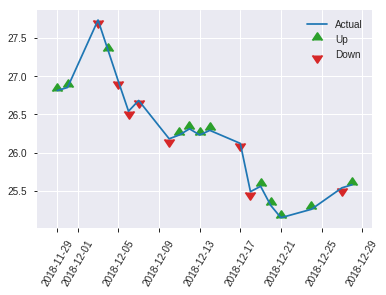


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22059701571711357
RMSE: 0.4696775656949282
LogLoss: 0.6335732420651256
Null degrees of freedom: 250
Residual degrees of freedom: 180
Null deviance: 346.9774746766028
Residual deviance: 318.05376751669303
AIC: 460.05376751669303
AUC: 0.6994252873563219
pr_auc: 0.6835486003498669
Gini: 0.39885057471264385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32525604291570925: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   66   0.569    (66.0/116.0)
1      11   124  0.0815   (11.0/135.0)
Total  61   190  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325256     0.763077  189
max f2                       0.257617     0.865513  210
max f0point5                 0.445962     0.70068   149
max accuracy                 0.331524     0.693227  185
max precision                0.923152     1         0
max recall                   0.0373394    1         250
max specificity              0.923152     1         0
max absolute_mcc             0.325256     0.406319  189
max min_per_class_accuracy   0.498253     0.644444  127
max mean_per_class_accuracy  0.445962     0.678895  149

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.879992           1.85926   1.85926            1                0.895211  1                           0.895211            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.85195            1.23951   1.54938            0.666667         0.865371  0.833333                    0.880291            0.0148148       0.037037                   23.9506   54.9383
    3        0.0318725                   0.845007           1.85926   1.62685            1                0.847419  0.875                       0.872073            0.0148148       0.0518519                  85.9259   62.6852
    4        0.0438247                   0.839145           1.85926   1.69024            1                0.842703  0.909091                    0.864063            0.0222222       0.0740741                  85.9259   69.0236
    5        0.0517928                   0.836411           1.85926   1.71624            1                0.838203  0.923077                    0.860084            0.0148148       0.0888889                  85.9259   71.6239
    6        0.103586                    0.748394           0.85812   1.28718            0.461538         0.788008  0.692308                    0.824046            0.0444444       0.133333                   -14.188   28.7179
    7        0.151394                    0.715849           0.92963   1.17427            0.5              0.733577  0.631579                    0.795477            0.0444444       0.177778                   -7.03704  17.4269
    8        0.203187                    0.66881            1.57322   1.27596            0.846154         0.691816  0.686275                    0.769053            0.0814815       0.259259                   57.3219   27.5962
    9        0.302789                    0.617227           1.18993   1.24766            0.64             0.643647  0.671053                    0.727801            0.118519        0.377778                   18.9926   24.7661
    10       0.40239                     0.558003           1.2643    1.25178            0.68             0.585346  0.673267                    0.69254             0.125926        0.503704                   26.4296   25.1779
    11       0.501992                    0.49968            1.2643    1.25426            0.68             0.525573  0.674603                    0.659412            0.125926        0.62963                    26.4296   25.4262
    12       0.601594                    0.441176           1.33867   1.26824            0.72             0.47492   0.682119                    0.628867            0.133333        0.762963                   33.8667   26.8236
    13       0.701195                    0.354355           0.892444  1.21486            0.48             0.404405  0.653409                    0.596983            0.0888889       0.851852                   -10.7556  21.4857
    14       0.800797                    0.299772           0.892444  1.17476            0.48             0.325132  0.631841                    0.56317             0.0888889       0.940741                   -10.7556  17.4756
    15       0.900398                    0.183727           0.297481  1.07771            0.16             0.243398  0.579646                    0.527797            0.0296296       0.97037                    -70.2519  7.77122
    16       1                           0.0373394          0.297481  1                  0.16             0.109699  0.537849                    0.486154         

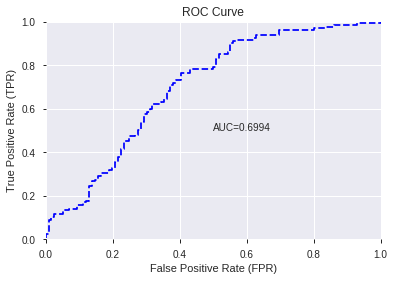

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


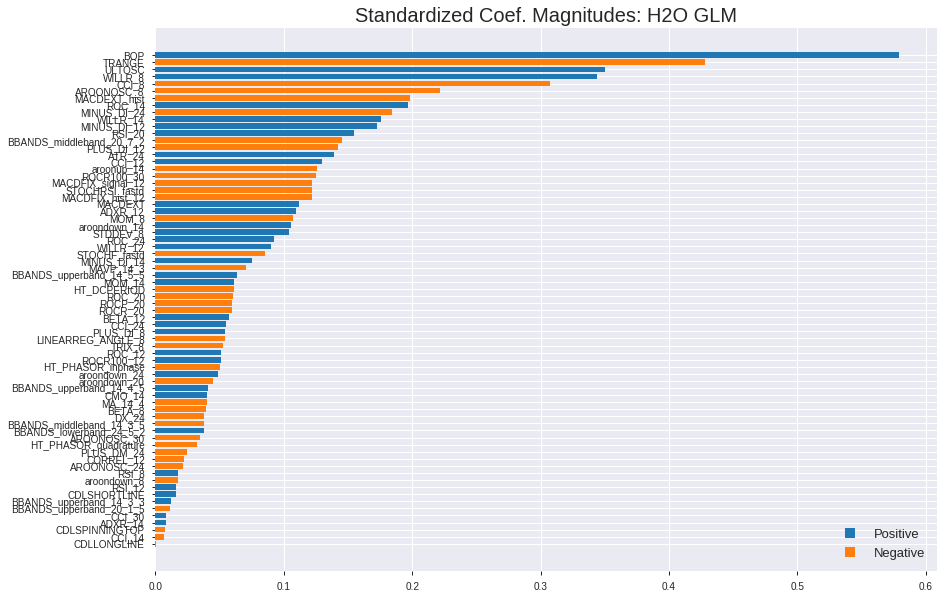

'log_likelihood'
--2019-07-25 02:30:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


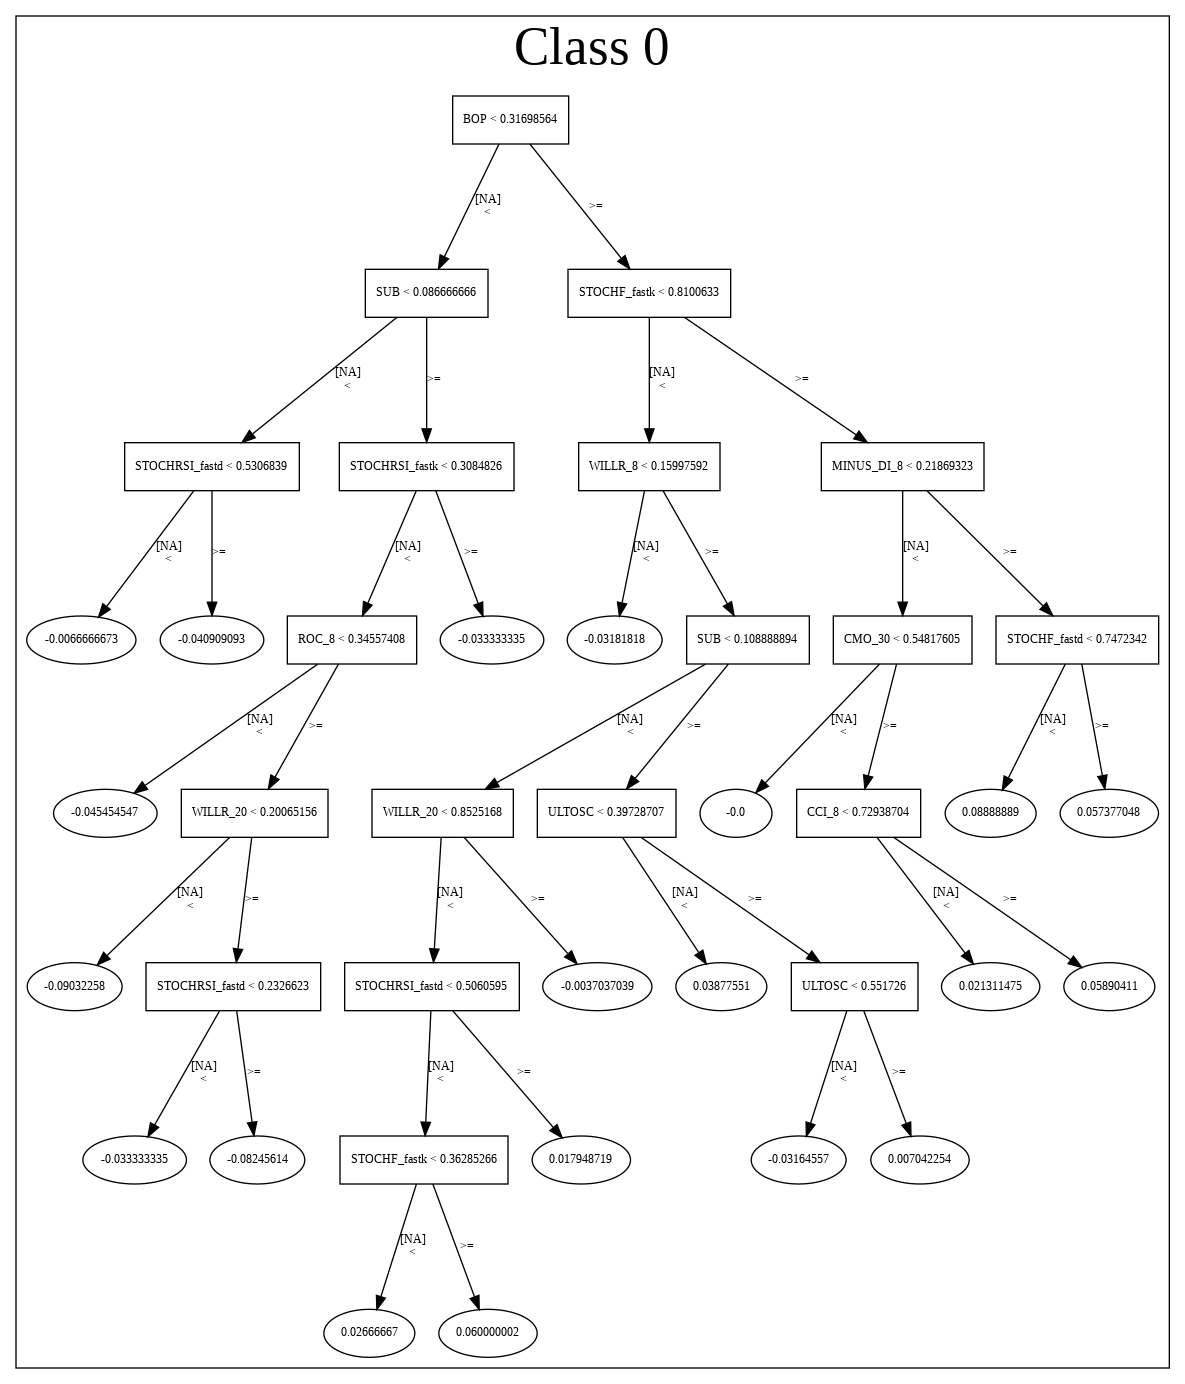

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_023028_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_023028_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'ULTOSC',
 'WILLR_8',
 'CCI_8',
 'AROONOSC_8',
 'MACDEXT_hist',
 'ROC_14',
 'MINUS_DI_24',
 'WILLR_14',
 'MINUS_DI_12',
 'RSI_20',
 'BBANDS_middleband_20_7_2',
 'PLUS_DI_12',
 'ATR_24',
 'CCI_12',
 'aroonup_14',
 'ROCR100_30',
 'MACDFIX_signal_12',
 'STOCHRSI_fastd',
 'MACDFIX_hist_12',
 'MACDEXT',
 'ADXR_12',
 'MOM_8',
 'aroondown_14',
 'STDDEV_8',
 'ROC_24',
 'WILLR_12',
 'STOCHF_fastd',
 'MINUS_DI_14',
 'MAVP_14_3',
 'BBANDS_upperband_14_5_5',
 'MOM_14',
 'HT_DCPERIOD',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'BETA_12',
 'CCI_24',
 'PLUS_DI_8',
 'LINEARREG_ANGLE_8',
 'TRIX_8',
 'ROC_12',
 'ROCR100_12',
 'HT_PHASOR_inphase',
 'aroondown_24',
 'aroondown_20',
 'BBANDS_upperband_14_4_5',
 'CMO_14',
 'MA_14_4',
 'BETA_8',
 'DX_24',
 'BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_24_5_2',
 'AROONOSC_30',
 'HT_PHASOR_quadrature',
 'PLUS_DM_24',
 'CORREL_12',
 'AROONOSC_24',
 'RSI_8',
 'aroondown_8',
 'RSI_12',
 'CDLSHORTLINE',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband

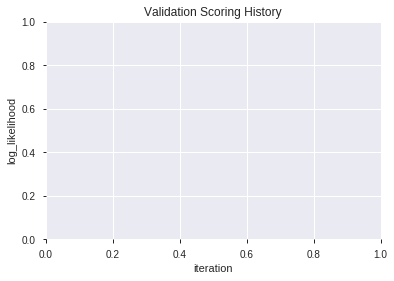

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190725_023044  0.728161  0.606672              0.329534  0.457256  0.209083
1  XGBoost_grid_1_AutoML_20190725_023044_model_2  0.712069  0.616205              0.339974  0.462379  0.213794
2  XGBoost_grid_1_AutoML_20190725_023044_model_3  0.709515  0.619009              0.346775  0.463709  0.215026
3               XGBoost_3_AutoML_20190725_023044  0.708429  0.616965              0.363346  0.462815  0.214198
4  XGBoost_grid_1_AutoML_20190725_023044_model_4  0.702937  0.622752              0.345562  0.465764  0.216936
5  XGBoost_grid_1_AutoML_20190725_023044_model_5  0.697063  0.632498              0.397829  0.470401  0.221277
6               XGBoost_1_AutoML_20190725_023044  0.696296  0.626265              0.367050  0.466773  0.217877
7  XGBoost_grid_1_AutoML_20190725_023044_model_6  0.693934  0.629566              0.356003  0.468187  0.219199
8  XGBoost_grid_1_AutoML_20190725_023044_model_1  0.680396  0.634131              0.375670  0.470718  0.221576
9  XGBoost_grid_1_AutoML_20190725_023044_model_7  0.675798  0.635505              0.357822  0.472272  0.223041

variable  relative_importance  scaled_importance  percentage
0            BOP          1551.741089           1.000000    0.220492
1         TRANGE           326.627380           0.210491    0.046411
2        WILLR_8           311.112213           0.200492    0.044207
3      CORREL_12           261.276367           0.168376    0.037126
4         ULTOSC           191.695343           0.123536    0.027239
..           ...                  ...                ...         ...
64     MAVP_14_3            22.119745           0.014255    0.003143
65       ROCP_20            19.973206           0.012871    0.002838
66  CDLSHORTLINE            15.909169           0.010252    0.002261
67  aroondown_24            10.802271           0.006961    0.001535
68       ROCR_20             7.566678           0.004876    0.001075

[69 rows x 4 columns]

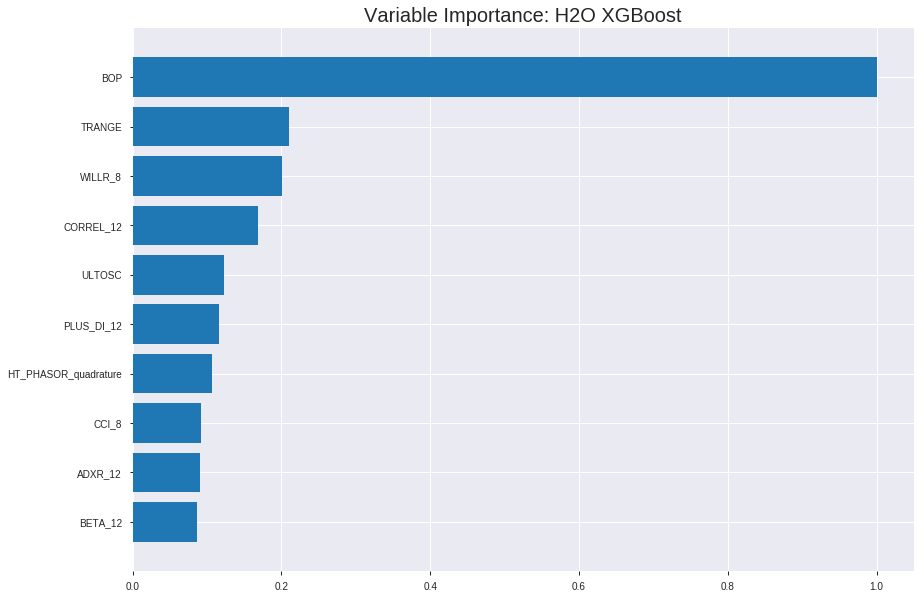

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190725_023044


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15233750300814036
RMSE: 0.3903043722636737
LogLoss: 0.47942496874506646
Mean Per-Class Error: 0.1710920904660752
AUC: 0.9017302105460453
pr_auc: 0.9176934092006622
Gini: 0.8034604210920906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5340643127759298: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      692  156  0.184    (156.0/848.0)
1      165  741  0.1821   (165.0/906.0)
Total  857  897  0.183    (321.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534064     0.821963  190
max f2                       0.307308     0.884225  302
max f0point5                 0.626346     0.86287   135
max accuracy                 0.579415     0.826682  165
max precision                0.908933     1         0
max recall                   0.176546     1         365
max specificity              0.908933     1         0
max absolute_mcc             0.579415     0.661686  165
max min_per_class_accuracy   0.534064     0.816038  190
max mean_per_class_accuracy  0.579415     0.828908  165

Gains/Lift Table: Avg response rate: 51.65 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.851961           1.93598    1.93598            1                0.872159  1                           0.872159            0.0198675       0.0198675                  93.5982   93.5982
    2        0.0205245                   0.833731           1.93598    1.93598            1                0.841683  1                           0.856921            0.0198675       0.0397351                  93.5982   93.5982
    3        0.0302166                   0.819716           1.93598    1.93598            1                0.826877  1                           0.847284            0.0187638       0.0584989                  93.5982   93.5982
    4        0.0404789                   0.808444           1.93598    1.93598            1                0.813163  1                           0.838634            0.0198675       0.0783664                  93.5982   93.5982
    5        0.050171                    0.7962             1.93598    1.93598            1                0.802392  1                           0.831633            0.0187638       0.0971302                  93.5982   93.5982
    6        0.100342                    0.756663           1.93598    1.93598            1                0.774967  1                           0.8033              0.0971302       0.19426                    93.5982   93.5982
    7        0.149943                    0.7345             1.93598    1.93598            1                0.747007  1                           0.784678            0.0960265       0.290287                   93.5982   93.5982
    8        0.200114                    0.713197           1.84798    1.91392            0.954545         0.723974  0.988604                    0.769459            0.0927152       0.383002                   84.7983   91.392
    9        0.299886                    0.659338           1.71473    1.84765            0.885714         0.687321  0.954373                    0.742132            0.171082        0.554084                   71.4727   84.7649
    10       0.400228                    0.607098           1.50699    1.76224            0.778409         0.633197  0.910256                    0.714821            0.151214        0.705298                   50.6986   76.224
    11       0.5                         0.541939           1.01777    1.61369            0.525714         0.572885  0.833523                    0.686498            0.101545        0.806843                   1.77736   61.3687
    12       0.599772                    0.478008           0.696954   1.46119            0.36             0.509184  0.754753                    0.657002            0.0695364       0.87638                    -30.3046  46.1188
    13       0.700114                    0.398679           0.549995   1.33059            0.284091         0.439818  0.687296                    0.625875            0.0551876       0.931567                   -45.0005  33.0594
    14       0.799886                    0.306804           0.497824   1.22672            0.257143         0.35318   0.633642                    0.591861            0.0496689       0.981236                   -50.2176  22.672
    15       0.899658                    0.213481           0.154879   1.10785            0.08             0.257151  0.572243                    0.554741            0.0154525       0.996689                   -84.5121  10.7853
    16       1                           0.083873           0.0329997  1                  0.0170455        0.157573  0.516534                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21520452085619848
RMSE: 0.463901412862904
LogLoss: 0.6181820892722102
Mean Per-Class Error: 0.34689140735049295
AUC: 0.7077170572416442
pr_auc: 0.7142158507151731
Gini: 0.4154341144832885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26051077246665955: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      51   177  0.7763   (177.0/228.0)
1      7    267  0.0255   (7.0/274.0)
Total  58   444  0.3665   (184.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260511     0.743733  350
max f2                       0.201243     0.869981  372
max f0point5                 0.598976     0.685558  151
max accuracy                 0.450752     0.667331  260
max precision                0.887103     1         0
max recall                   0.147751     1         386
max specificity              0.887103     1         0
max absolute_mcc             0.433111     0.326024  268
max min_per_class_accuracy   0.558059     0.635965  188
max mean_per_class_accuracy  0.598976     0.653109  151

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.805057           1.52676   1.52676            0.833333         0.835464  0.833333                    0.835464            0.0182482       0.0182482                  52.6764   52.6764
    2        0.0219124                   0.790087           1.09927   1.33245            0.6              0.797223  0.727273                    0.818082            0.0109489       0.0291971                  9.92701   33.2449
    3        0.0318725                   0.778018           1.46569   1.37409            0.8              0.781965  0.75                        0.806795            0.0145985       0.0437956                  46.5693   37.4088
    4        0.0418327                   0.770436           1.09927   1.30865            0.6              0.772801  0.714286                    0.798701            0.0109489       0.0547445                  9.92701   30.8655
    5        0.0517928                   0.758208           1.83212   1.40932            1                0.763382  0.769231                    0.791909            0.0182482       0.0729927                  83.2117   40.9321
    6        0.101594                    0.732031           1.39241   1.40103            0.76             0.742888  0.764706                    0.767879            0.0693431       0.142336                   39.2409   40.103
    7        0.151394                    0.703121           1.61226   1.47051            0.88             0.71659   0.802632                    0.751008            0.080292        0.222628                   61.2263   47.0515
    8        0.201195                    0.682397           1.46569   1.46932            0.8              0.690815  0.80198                     0.736108            0.0729927       0.29562                    46.5693   46.9321
    9        0.300797                    0.634505           1.31912   1.41959            0.72             0.657244  0.774834                    0.709995            0.131387        0.427007                   31.9124   41.9587
    10       0.400398                    0.600013           1.09927   1.33991            0.6              0.617633  0.731343                    0.687019            0.109489        0.536496                   9.92701   33.9906
    11       0.5                         0.563105           0.806131  1.23358            0.44             0.579941  0.673307                    0.665689            0.080292        0.616788                   -19.3869  23.3577
    12       0.599602                    0.504998           1.09927   1.21127            0.6              0.535163  0.66113                     0.644007            0.109489        0.726277                   9.92701   21.1267
    13       0.699203                    0.431334           1.06263   1.19009            0.58             0.471181  0.649573                    0.619388            0.105839        0.832117                   6.26277   19.0093
    14       0.798805                    0.341592           0.696204  1.12851            0.38             0.384583  0.61596                     0.59011             0.0693431       0.90146                    -30.3796  12.8511
    15       0.898406                    0.240812           0.769489  1.08871            0.42             0.293304  0.594235                    0.557205            0.0766423       0.978102                   -23.0511  8.8708
    16       1                           0.0883999          0.215543  1                  0.117647         0.181158  0.545817                    0.519001           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 02:30:47  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.483466                         0.5                0.693147              0.5               0                    1                  0.454183
    2019-07-25 02:30:47  0.076 sec   5                  0.480726         0.655179            0.796973        0.800329           1.93598          0.315279                         0.489638           0.672566              0.679793          0.692924             1.52676            0.376494
    2019-07-25 02:30:47  0.127 sec   10                 0.464323         0.62334             0.814155        0.821581           1.93598          0.314709                         0.480202           0.653832              0.694847          0.721275             1.83212            0.346614
    2019-07-25 02:30:47  0.182 sec   15                 0.450774         0.597176            0.834217        0.84695            1.93598          0.252566                         0.475724           0.644775              0.694055          0.702127             1.52676            0.334661
    2019-07-25 02:30:47  0.238 sec   20                 0.440098         0.576267            0.84332         0.855323           1.93598          0.222919                         0.471388           0.635652              0.701026          0.71618              1.83212            0.346614
    2019-07-25 02:30:47  0.297 sec   25                 0.431866         0.560112            0.85154         0.863881           1.93598          0.220068                         0.468924           0.630247              0.702203          0.719958             1.52676            0.342629
    2019-07-25 02:30:47  0.361 sec   30                 0.423692         0.544047            0.861231        0.874024           1.93598          0.214367                         0.467343           0.626394              0.702603          0.715345             1.52676            0.364542
    2019-07-25 02:30:47  0.419 sec   35                 0.417134         0.531186            0.869246        0.884308           1.93598          0.212087                         0.465881           0.623101              0.702947          0.711314             1.52676            0.356574
    2019-07-25 02:30:47  0.477 sec   40                 0.411314         0.519723            0.876634        0.892118           1.93598          0.201254                         0.464832           0.620595              0.704644          0.715762             1.52676            0.360558
    2019-07-25 02:30:47  0.536 sec   45                 0.405499         0.508311            0.882908        0.89893            1.93598          0.197263                         0.464916           0.620411              0.702043          0.707888             1.83212            0.364542
    2019-07-25 02:30:47  0.601 sec   50                 0.400246         0.498378            0.890276        0.907152           1.93598          0.195553                         0.464225           0.618823              0.703947          0.707852             1.83212            0.356574
    2019-07-25 02:30:47  0.662 sec   55                 0.395468         0.489019            0.895436        0.912107           1.93598          0.190992                         0.46424            0.618832              0.7059            0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1551.7410888671875     1.0                    0.22049160169974294
TRANGE        326.62738037109375     0.2104909012943264     0.046411475969608526
WILLR_8       311.1122131347656      0.20049234718781975    0.04420687875998333
CORREL_12     261.2763671875         0.16837626396697322    0.03712555213029664
ULTOSC        191.69534301757812     0.1235356493379452     0.027238573189541326
---           ---                    ---                    ---
MAVP_14_3     22.1197452545166       0.014254791223363561   0.00314306174873487
ROCP_20       19.97320556640625      0.012871480757777203   0.0028380534085297167
CDLSHORTLINE  15.90916919708252      0.01025246370752265    0.0022605821442401542
aroondown_24  10.802270889282227     0.0069613874162268745  0.0015349274614562987
ROCR_20       7.566678047180176      0.00487625036255504    0.001075172252728713


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7607361963190183)

('auc', 0.7281609195402299)

('logloss', 0.6066718440164066)

('mean_per_class_error', 0.310727969348659)

('rmse', 0.4572563238862383)

('mse', 0.20908334573395648)

xgboost prediction progress: |████████████████████████████████████████████| 100%


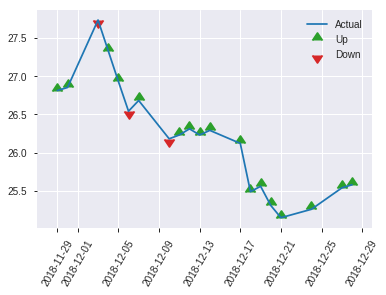


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20908334573395648
RMSE: 0.4572563238862383
LogLoss: 0.6066718440164066
Mean Per-Class Error: 0.310727969348659
AUC: 0.7281609195402299
pr_auc: 0.7079830646267694
Gini: 0.45632183908045976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3614438772201538: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   67   0.5776   (67.0/116.0)
1      11   124  0.0815   (11.0/135.0)
Total  60   191  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361444     0.760736  190
max f2                       0.263857     0.869854  212
max f0point5                 0.530064     0.714286  128
max accuracy                 0.530064     0.689243  128
max precision                0.820921     1         0
max recall                   0.099689     1         250
max specificity              0.820921     1         0
max absolute_mcc             0.361444     0.39854   190
max min_per_class_accuracy   0.530064     0.688889  128
max mean_per_class_accuracy  0.530064     0.689272  128

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.807649           0.619753  0.619753           0.333333         0.814357  0.333333                    0.814357            0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.782276           1.85926   1.23951            1                0.796876  0.666667                    0.805616            0.0222222       0.0296296                  85.9259   23.9506
    3        0.0318725                   0.76657            1.85926   1.39444            1                0.767414  0.75                        0.796066            0.0148148       0.0444444                  85.9259   39.4444
    4        0.0438247                   0.765173           1.85926   1.52121            1                0.765619  0.818182                    0.787762            0.0222222       0.0666667                  85.9259   52.1212
    5        0.0517928                   0.758252           1.85926   1.57322            1                0.759391  0.846154                    0.783397            0.0148148       0.0814815                  85.9259   57.3219
    6        0.103586                    0.707793           1.4302    1.50171            0.769231         0.729715  0.807692                    0.756556            0.0740741       0.155556                   43.0199   50.1709
    7        0.151394                    0.687832           1.23951   1.41891            0.666667         0.697958  0.763158                    0.738051            0.0592593       0.214815                   23.9506   41.8908
    8        0.203187                    0.655887           1.4302    1.42179            0.769231         0.666912  0.764706                    0.719918            0.0740741       0.288889                   43.0199   42.1786
    9        0.302789                    0.616891           1.04119   1.29659            0.56             0.636221  0.697368                    0.692386            0.103704        0.392593                   4.11852   29.6589
    10       0.40239                     0.574652           1.41304   1.32541            0.76             0.594568  0.712871                    0.668174            0.140741        0.533333                   41.3037   32.5413
    11       0.501992                    0.533252           1.33867   1.32804            0.72             0.552395  0.714286                    0.645202            0.133333        0.666667                   33.8667   32.8042
    12       0.601594                    0.480072           0.966815  1.26824            0.52             0.509923  0.682119                    0.622804            0.0962963       0.762963                   -3.31852  26.8236
    13       0.701195                    0.41262            0.818074  1.20429            0.44             0.446612  0.647727                    0.597777            0.0814815       0.844444                   -18.1926  20.4293
    14       0.800797                    0.318111           0.892444  1.16551            0.48             0.366457  0.626866                    0.569006            0.0888889       0.933333                   -10.7556  16.5506
    15       0.900398                    0.21253            0.371852  1.07771            0.2              0.262261  0.579646                    0.535074            0.037037        0.97037                    -62.8148  7.77122
    16       1                           0.099689           0.297481  1                  0.16             0.162152  0.537849                    0.49793         

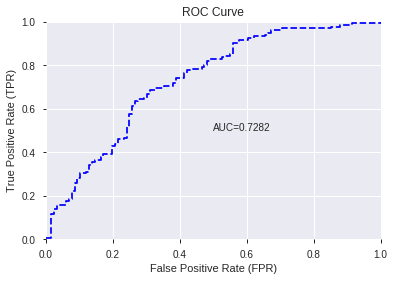

This function is available for GLM models only


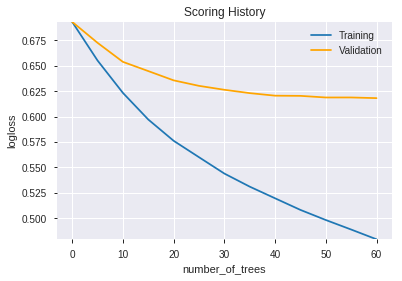

--2019-07-25 02:31:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.114.50
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.114.50|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


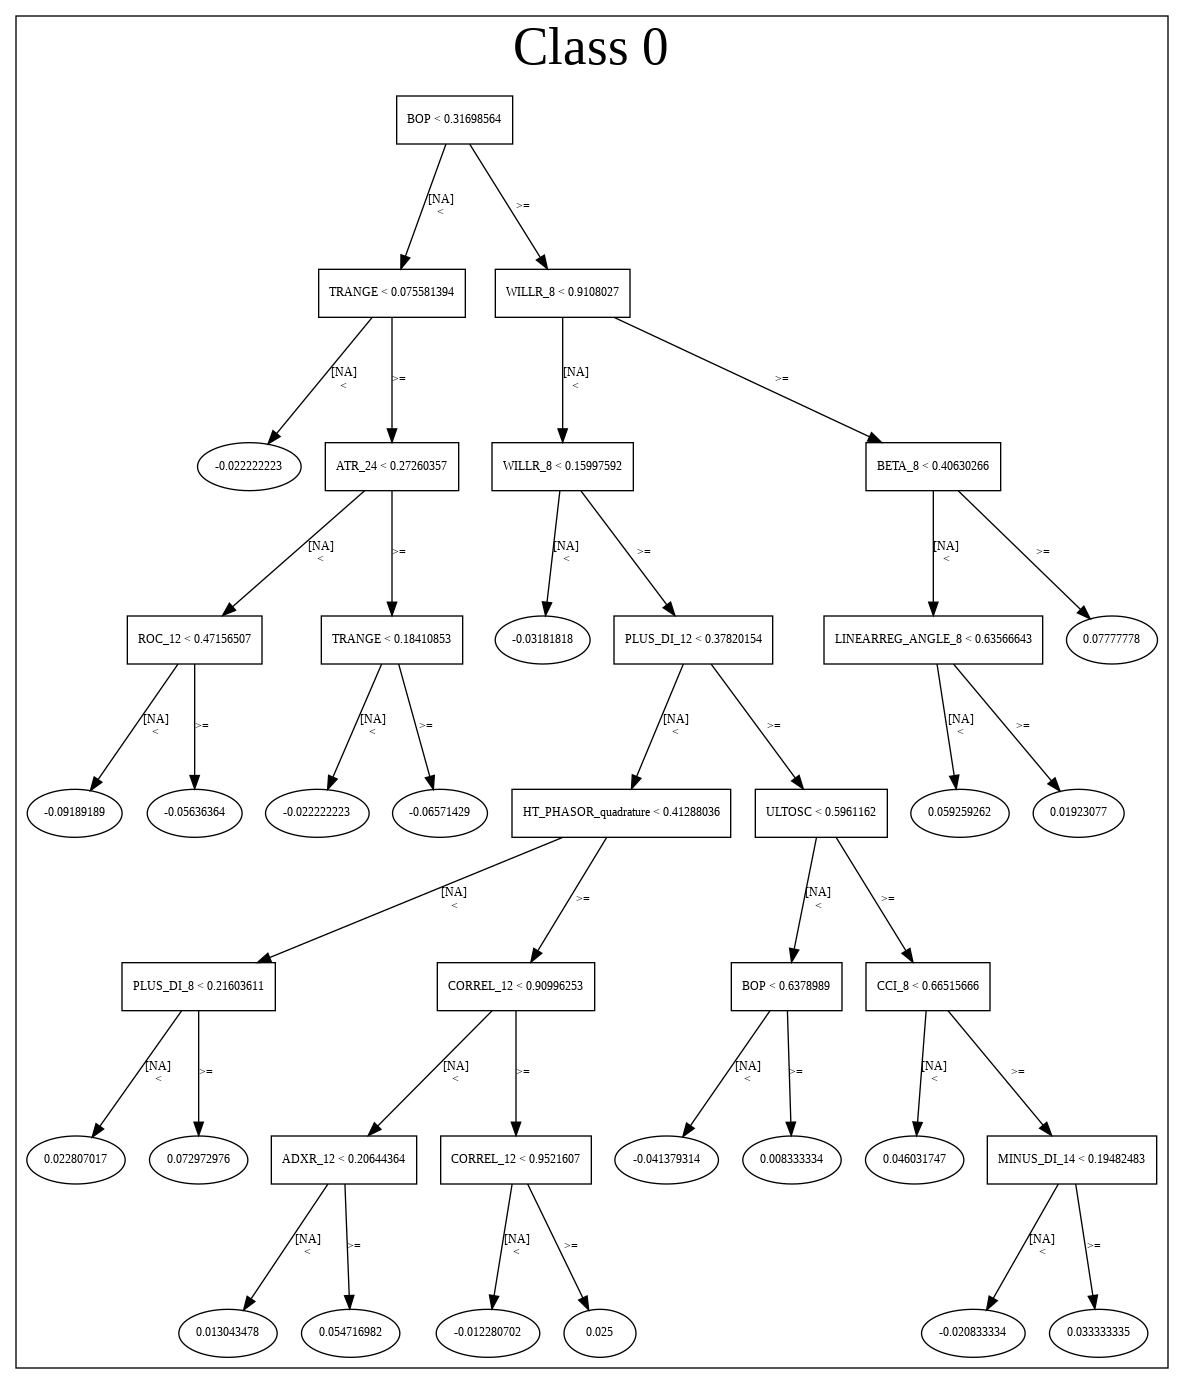

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190725_023044',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190725_023044',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bd87',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_bd87',
   'ty

['BOP',
 'TRANGE',
 'WILLR_8',
 'CORREL_12',
 'ULTOSC',
 'PLUS_DI_12',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'ADXR_12',
 'BETA_12',
 'MACDFIX_hist_12',
 'STOCHF_fastd',
 'WILLR_14',
 'ATR_24',
 'ADXR_14',
 'MACDEXT_hist',
 'BETA_8',
 'MACDFIX_signal_12',
 'TRIX_8',
 'HT_DCPERIOD',
 'ROCR100_30',
 'ROC_20',
 'ROC_14',
 'STOCHRSI_fastd',
 'BBANDS_upperband_20_1_5',
 'ROC_24',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'PLUS_DI_8',
 'MINUS_DI_14',
 'ROC_12',
 'AROONOSC_24',
 'LINEARREG_ANGLE_8',
 'aroondown_8',
 'RSI_8',
 'PLUS_DM_24',
 'DX_24',
 'ROCR100_12',
 'CDLLONGLINE',
 'BBANDS_lowerband_24_5_2',
 'MINUS_DI_24',
 'BBANDS_upperband_14_5_5',
 'aroonup_14',
 'CCI_12',
 'CCI_24',
 'CCI_14',
 'BBANDS_upperband_14_3_3',
 'MOM_8',
 'AROONOSC_8',
 'CMO_14',
 'RSI_20',
 'MINUS_DI_12',
 'MACDEXT',
 'RSI_12',
 'AROONOSC_30',
 'MA_14_4',
 'MOM_14',
 'BBANDS_middleband_14_3_5',
 'BBANDS_middleband_20_7_2',
 'aroondown_14',
 'CCI_30',
 'BBANDS_upperband_14_4_5',
 'aroondown_20',
 'MAVP_14_3'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.725
GLM             0.693
XGBoost         0.693
dtype: float64

DeepLearning    GLM  XGBoost
All          0.725  0.689    0.681
DLF          0.681  0.677    0.685
Fwe          0.709  0.689    0.693
RFE          0.685  0.693    0.689
XGBF         0.689  0.677    0.685





F1


DeepLearning    0.766
GLM             0.766
XGBoost         0.761
dtype: float64

DeepLearning    GLM  XGBoost
All          0.758  0.766    0.752
DLF          0.746  0.742    0.749
Fwe          0.766  0.757    0.752
RFE          0.745  0.763    0.761
XGBF         0.746  0.742    0.749





auc


DeepLearning    0.739
GLM             0.716
XGBoost         0.728
dtype: float64

DeepLearning    GLM  XGBoost
All          0.739  0.714    0.705
DLF          0.712  0.700    0.712
Fwe          0.736  0.716    0.719
RFE          0.717  0.699    0.728
XGBF         0.725  0.700    0.712





logloss


DeepLearning    0.974
GLM             0.637
XGBoost         0.628
dtype: float64

DeepLearning    GLM  XGBoost
All          0.974  0.627    0.628
DLF          0.714  0.637    0.626
Fwe          0.613  0.617    0.613
RFE          0.837  0.634    0.607
XGBF         0.628  0.637    0.626





mean_per_class_error


DeepLearning    0.321
GLM             0.329
XGBoost         0.335
dtype: float64

DeepLearning    GLM  XGBoost
All          0.278  0.325    0.335
DLF          0.321  0.329    0.330
Fwe          0.298  0.323    0.314
RFE          0.316  0.321    0.311
XGBF         0.320  0.329    0.330





rmse


DeepLearning    0.560
GLM             0.471
XGBoost         0.468
dtype: float64

DeepLearning    GLM  XGBoost
All          0.560  0.468    0.468
DLF          0.494  0.471    0.466
Fwe          0.458  0.464    0.461
RFE          0.524  0.470    0.457
XGBF         0.466  0.471    0.466





mse


DeepLearning    0.313
GLM             0.222
XGBoost         0.219
dtype: float64

DeepLearning    GLM  XGBoost
All          0.313  0.219    0.219
DLF          0.244  0.222    0.218
Fwe          0.210  0.216    0.212
RFE          0.275  0.221    0.209
XGBF         0.217  0.222    0.218

{'F1':       DeepLearning    GLM  XGBoost
 All          0.758    NaN      NaN
 DLF          0.746    NaN      NaN
 DLF            NaN  0.742      NaN
 DLF            NaN    NaN    0.749
 All            NaN  0.766      NaN
 All            NaN    NaN    0.752
 XGBF         0.746    NaN      NaN
 XGBF           NaN  0.742      NaN
 XGBF           NaN    NaN    0.749
 Fwe          0.766    NaN      NaN
 Fwe            NaN  0.757      NaN
 Fwe            NaN    NaN    0.752
 RFE          0.745    NaN      NaN
 RFE            NaN  0.763      NaN
 RFE            NaN    NaN    0.761,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.725    NaN      NaN
 DLF          0.681    NaN      NaN
 DLF            NaN  0.677      NaN
 DLF            NaN    NaN    0.685
 All            NaN  0.689      NaN
 All            NaN    NaN    0.681
 XGBF         0.689    NaN      NaN
 XGBF           NaN  0.677      NaN
 XGBF           NaN    NaN    0.685
 Fwe          0.709    NaN      NaN
 Fwe     